# Factors of a Box Office Success

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Markdown
import difflib
import re
import requests
from bs4 import BeautifulSoup
import time
import math
import tempfile
import scipy.stats as stats
import locale

# Loading the Data

## im.db sqlite file
github only allows files up to 100MB so we must keep the im.db zipped and also work on it.

In [2]:
# Create a temporary file
with tempfile.NamedTemporaryFile(delete=False) as temp_db:
    # Extract the database file from the zip archive to the temporary file
    with zipfile.ZipFile('zippedData/im.db.zip', 'r') as z:
        with z.open('im.db') as f:
            temp_db.write(f.read())
    temp_db_path = temp_db.name

# Connect to the database
conn = sqlite3.connect(temp_db_path)

# Query to get the list of tables
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
display(tables)

# Query to get the first 10 rows from the movie_basics table
df = pd.read_sql_query("SELECT * FROM movie_basics limit 10", conn)
display(df.info())


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         10 non-null     object 
 1   primary_title    10 non-null     object 
 2   original_title   10 non-null     object 
 3   start_year       10 non-null     int64  
 4   runtime_minutes  7 non-null      float64
 5   genres           10 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 608.0+ bytes


None

## CSVs
Again we leave them zipped, pandas handles that for us.

In [3]:
bom_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
display(bom_movie_gross.head())

tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
display(tmdb_movies.head())

tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
display(tn_movie_budgets.head())

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## TSVs
They needed latin encoding or they didn't load right

In [4]:
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', encoding='latin1')
display(rt_movie_info.head())

rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')
display(rt_reviews.head())

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


## Recent IMDb Info from Flat Files

We obtained recent data from the [IMDb Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/) and trimmed it down to the last 10 years to fit within GitHub's file size limits.

This data was merged with reviews from the same source and saved as a DataFrame pickle file. The processing was done in a separate folder to avoid kernel crashes caused by the large file size. Chunking solved this issue, but to keep this notebook manageable, we store and load the pickle file here.

The file is `additional_data/imdb_flat_files/filtered_title_basics.tsv.gz`. From this, we parsed out the last 3 years of movie data to focus on what currently works at the box office and saved it as a pickle file `additional_data/last_three_years_movies_with_ratings.pkl`. However, it is used as a base for API calls to get more data, so it is not loaded here either.

### IMDb Flat File Last Ten Years

While we won't load the last 3 years pickle file we will load the last 10 years of IMDb data to check if the `im.db` and the flat files we have agree data-wise.

In [5]:
def load_gzipped_tsv_in_chunks(file_path, chunk_size=10000):
    chunks = []
    for chunk in pd.read_csv(file_path, delimiter='\t', encoding='utf-8', chunksize=chunk_size):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

imdb_last_ten_years = load_gzipped_tsv_in_chunks('additional_data/imdb_flat_files/filtered_title_basics.tsv.gz')
#display(imdb_last_ten_years.head())

imdb_last_ten_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195091 entries, 0 to 195090
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         195091 non-null  object 
 1   title_type       195091 non-null  object 
 2   primary_title    195091 non-null  object 
 3   original_title   195091 non-null  object 
 4   is_adult         195091 non-null  int64  
 5   start_year       195091 non-null  int64  
 6   end_year         0 non-null       float64
 7   runtime_minutes  145508 non-null  float64
 8   genres           195091 non-null  object 
 9   averagerating    101899 non-null  float64
 10  numvotes         101899 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 16.4+ MB


In [6]:
imdb_last_ten_years['movie_id'].value_counts()

tt0011801     1
tt4481484     1
tt4480930     1
tt4480936     1
tt4481066     1
             ..
tt21029334    1
tt21029338    1
tt21029594    1
tt21029660    1
tt9916730     1
Name: movie_id, Length: 195091, dtype: int64

### Lets Select From im.db To Match The Format


In [7]:
sql = """
SELECT mb.*,mr.averagerating,mr.numvotes
FROM movie_basics mb
JOIN movie_ratings mr on mr.movie_id=mb.movie_id
WHERE start_year >= strftime('%Y', 'now', '-10 years')
"""
im_db = pd.read_sql_query(sql,conn)
display(im_db.info())
display(im_db.head())

display(im_db['movie_id'].isnull().sum())
display(im_db['movie_id'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44005 entries, 0 to 44004
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         44005 non-null  object 
 1   primary_title    44005 non-null  object 
 2   original_title   44005 non-null  object 
 3   start_year       44005 non-null  int64  
 4   runtime_minutes  39314 non-null  float64
 5   genres           43570 non-null  object 
 6   averagerating    44005 non-null  float64
 7   numvotes         44005 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 2.7+ MB


None

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
2,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
3,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
4,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",4.1,32


0

tt0066787    1
tt6084816    1
tt6083652    1
tt6083734    1
tt6084014    1
            ..
tt4180640    1
tt4180650    1
tt4181052    1
tt4181194    1
tt9916160    1
Name: movie_id, Length: 44005, dtype: int64

## Comparing The Two
There is a huge difference in the size of the datasets for the last 10 years.

In [8]:
# Merge both datasets on the movie_id using an inner join
merged_df = pd.merge(imdb_last_ten_years, im_db, on='movie_id', suffixes=('_flat', '_sql'), how='inner')

# Function to calculate scores
def calculate_scores(row, col):
    score_flat = 0
    score_sql = 0

    value_flat = row[col + '_flat']
    value_sql = row[col + '_sql']

    if pd.isna(value_flat) and pd.notna(value_sql):
        score_sql += 1
    elif pd.notna(value_flat) and pd.isna(value_sql):
        score_flat += 1
    elif pd.notna(value_flat) and pd.notna(value_sql):
        # Give them both a point if values are equal, this will make the score more intuitively correct if the two data sets mostly agree
        if value_flat == value_sql:
            score_flat += 1
            score_sql += 1
        # Penalize both for numeric discrepancies
        elif isinstance(value_flat, (int, float)) and isinstance(value_sql, (int, float)):
            score_flat -= 1
            score_sql -= 1
        elif isinstance(value_flat, str) and isinstance(value_sql, str):
            if len(value_flat) > len(value_sql):
                score_flat += 0.5
            elif len(value_flat) < len(value_sql):
                score_sql += 0.5

    return score_flat, score_sql

# Initialize scores
total_score_flat = 0
total_score_sql = 0

# Calculate scores for each row and column
for col in ['primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']:
    for _, row in merged_df.iterrows():
        rflat, rsql = calculate_scores(row, col)
        total_score_flat += rflat
        total_score_sql += rsql

# Print total scores
print(f"Total Score for IMDb Flat Files: {total_score_flat}")
print(f"Total Score for IMDb SQL Database: {total_score_sql}")

Total Score for IMDb Flat Files: 202377.5
Total Score for IMDb SQL Database: 198181.5


## Make movies_df
merge the two dataframes preferring the more up to date info where they overlap

In [9]:
# Merging im_db and imdb_last_ten_years dataframes, preferring values from imdb_last_ten_years
# Concatenate the DataFrames
combined_df = pd.concat([im_db, imdb_last_ten_years], ignore_index=True)

# Drop duplicates based on 'movie_id', keeping the first occurrence (from imdb_last_ten_years)
movies_df = combined_df.drop_duplicates(subset='movie_id', keep='last').reset_index(drop=True)

# Optional: Display the resulting DataFrame
display(movies_df)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
195957,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0.0,NaN
195958,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0.0,NaN
195959,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0.0,NaN
195960,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0.0,NaN


In [10]:
#Clear up memory
merged_df = None
im_db = None
imdb_last_ten_years = None

### Results of Comparison
It seems the data isn't too different, but as might be expected the newer data scores better.  This makes sense because newer data is often more filled out on sites that collect data.
So we would benefit with preferring the updated data set for both the score and reasoning.

We could merge the data sets to fill in missing, but missing info could be corrections in the new data set.  Likewise changes to genres could be intentional and more correct.

However, later on, we can leverage the fact the im.db goes further back and has things on actors etc if we need to.



## [Rapid API Movies Database](https://rapidapi.com/SAdrian/api/moviesdatabase)
This Movies Database has info we need, mainly box office data and production costs.  We also got as much else as we could though.

The `additional_data/last_three_years_movies_with_ratings.pkl` was used as the base and using the imdb id we fetched additional info on the following:
```python
infos = ["base_info", "genres", "revenue_budget", "releaseDate", "rating", "awards"]
```

The final merged results are loaded below in a pickle file, giving us comprehensive data on the last three years of movie data!

In [11]:
movie_detailed = pd.read_pickle('additional_data/final_filtered_last_three_years_data.pkl')
movie_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68006 entries, 0 to 68005
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movie_id               68006 non-null  object 
 1   title_type             68006 non-null  object 
 2   primary_title          68006 non-null  object 
 3   original_title         68006 non-null  object 
 4   is_adult               68006 non-null  object 
 5   start_year             68006 non-null  int64  
 6   end_year               68006 non-null  object 
 7   runtime_minutes        68006 non-null  object 
 8   genres                 68006 non-null  object 
 9   average_rating         32777 non-null  float64
 10  num_votes              32777 non-null  float64
 11  md_average_rating      32854 non-null  float64
 12  md_num_votes           67871 non-null  float64
 13  image_url              47166 non-null  object 
 14  image_caption          47166 non-null  object 
 15  md

Unfortunately after all that work (over 12 hours worth), the number of box office revenu columns we got was very small.  So we won't be able to use it much.

## Additional Data
We might use this later but we'll have to hand copy it.
https://the-numbers.com/movies/report/All/All/All/All/All/All/All/All/All/None/None/2020/2020/None/None/None/None/None/None?show-release-date=On&view-order-by=domestic-box-office&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-inflation-adjusted-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On&show-genre=On

# Data Exploration
Lets see what we have, identify what we can clean and then combine

## Summarize Our Data
We need a birds eye view of what we're looking at

In [12]:
# Function to summarize a dataframe
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Dtype': df.dtypes.values,
        'Unique Values': df.nunique().values,
        'Sample Values': [get_top_values(df[col]) for col in df.columns]
    })
    return summary

# Function to get top 5 values by frequency
def get_top_values(series):
    top_values = Counter(series.dropna()).most_common(5)
    return [val[0] for val in top_values]
# Function to display summary with heading
def display_summary(title, df):
    p_md(title)
    display(summarize_dataframe(df))

# Utility function to print markdown
def p_md(text):
    display(Markdown(text))


# Adjust display options to show more content in cells
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Display summaries
p_md("**Summaries**")

def im_db_tables_summaries():
    # Summarize im.db tables
    im_db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

    for table_name in im_db_tables['name']:
        display_summary(f"**table {table_name} in im.db:**", pd.read_sql_query(f"SELECT * FROM {table_name}", conn))

def df_summaries():
    # Movies DF
    display_summary("**movies_df dataframe:**", movies_df)

    # Summarize CSV dataframes
    display_summary("**bom_movie_gross dataframe:**", bom_movie_gross)
    display_summary("**tmdb_movies dataframe:**", tmdb_movies)
    display_summary("**tn_movie_budgets dataframe:**", tn_movie_budgets)

    # Summarize TSV dataframes
    display_summary("**rt_movie_info dataframe:**", rt_movie_info)
    display_summary("**rt_reviews dataframe:**", rt_reviews)

im_db_tables_summaries()
df_summaries()

**Summaries**

**table movie_basics in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,146144,object,146144,"[tt0063540, tt0066787, tt0069049, tt0069204, tt0100275]"
1,primary_title,146144,object,136071,"[Home, Broken, The Return, Alone, Homecoming]"
2,original_title,146123,object,137773,"[Broken, Home, The Return, Alone, The Gift]"
3,start_year,146144,int64,19,"[2017, 2016, 2018, 2015, 2014]"
4,runtime_minutes,114405,float64,367,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,140736,object,1085,"[Documentary, Drama, Comedy, Horror, Comedy,Drama]"


**table directors in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,291174,object,140417,"[tt4050462, tt3091166, tt2249786, tt4942694, tt3528906]"
1,person_id,291174,object,109253,"[nm6935209, nm2563700, nm1546474, nm3877467, nm3848412]"


**table known_for in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,person_id,1638260,object,576444,"[nm1202937, nm4291122, nm0958522, nm0509978, nm0218305]"
1,movie_id,1638260,object,514781,"[tt0806910, tt0441074, tt0203259, tt0486531, tt0452046]"


**table movie_akas in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,331703,object,122302,"[tt2488496, tt2310332, tt1201607, tt2278871, tt1790809]"
1,ordering,331703,int64,61,"[1, 2, 3, 4, 5]"
2,title,331703,object,252781,"[Robin Hood, Home, Alone, Broken, Love]"
3,region,278410,object,213,"[US, XWW, RU, DE, FR]"
4,language,41715,object,76,"[en, tr, bg, fr, he]"
5,types,168447,object,10,"[imdbDisplay, original, working, alternative, festival]"
6,attributes,14925,object,77,"[new title, alternative spelling, literal English title, complete title, original subtitled version]"
7,is_original_title,331678,float64,2,"[0.0, 1.0]"


**table movie_ratings in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,73856,object,73856,"[tt10356526, tt10384606, tt1042974, tt1043726, tt1060240]"
1,averagerating,73856,float64,91,"[7.0, 6.6, 7.2, 6.8, 6.5]"
2,numvotes,73856,int64,7349,"[6, 5, 7, 8, 9]"


**table persons in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,person_id,606648,object,606648,"[nm0061671, nm0061865, nm0062070, nm0062195, nm0062798]"
1,primary_name,606648,object,577203,"[James Brown, Michael Brown, David Brown, Michael Johnson, Mark Davis]"
2,birth_year,82736,float64,267,"[1978.0, 1980.0, 1979.0, 1982.0, 1981.0]"
3,death_year,6783,float64,214,"[2018.0, 2017.0, 2016.0, 2015.0, 2013.0]"
4,primary_profession,555308,object,8647,"[actor, actress, producer, composer, writer]"


**table principals in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,1028186,object,143454,"[tt0323808, tt0417610, tt0469152, tt0475290, tt0477302]"
1,ordering,1028186,int64,10,"[1, 2, 3, 4, 5]"
2,person_id,1028186,object,604546,"[nm1930572, nm0000636, nm0000616, nm0103977, nm4394575]"
3,category,1028186,object,12,"[actor, director, actress, producer, cinematographer]"
4,job,177684,object,2965,"[producer, screenplay, director of photography, writer, co-director]"
5,characters,393360,object,174762,"[[""Himself""], [""Herself""], [""Narrator""], [""Alex""], [""David""]]"


**table writers in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,255873,object,110261,"[tt4050462, tt3091166, tt2249786, tt4942694, tt3528906]"
1,person_id,255873,object,122576,"[nm6935209, nm1546474, nm0000636, nm2780568, nm4677186]"


**movies_df dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,195962,object,195962,"[tt0066787, tt0069204, tt0170651, tt0253093, tt0263814]"
1,primary_title,195962,object,180744,"[The Return, Alone, The Stranger, Hero, Home]"
2,original_title,195962,object,183518,"[The Return, Alone, Home, Karma, Run]"
3,start_year,195962,int64,18,"[2022, 2023, 2018, 2017, 2019]"
4,runtime_minutes,146201,float64,425,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,195931,object,1140,"[Documentary, Drama, Comedy, \N, Horror]"
6,averagerating,102770,float64,91,"[6.4, 6.8, 6.6, 7.0, 6.2]"
7,numvotes,102770,float64,9162,"[7.0, 8.0, 9.0, 6.0, 10.0]"
8,title_type,195091,object,1,[movie]
9,is_adult,195091,float64,2,"[0.0, 1.0]"


**bom_movie_gross dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,title,3387,object,3386,"[Bluebeard, Toy Story 3, Alice in Wonderland (2010), Harry Potter and the Deathly Hallows Part 1, Inception]"
1,studio,3382,object,257,"[IFC, Uni., WB, Fox, Magn.]"
2,domestic_gross,3359,float64,1797,"[1100000.0, 1000000.0, 1300000.0, 1200000.0, 1400000.0]"
3,foreign_gross,2037,object,1204,"[1200000, 1100000, 1900000, 4200000, 2500000]"
4,year,3387,int64,9,"[2015, 2016, 2012, 2011, 2014]"


**tmdb_movies dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,Unnamed: 0,26517,int64,26517,"[0, 1, 2, 3, 4]"
1,genre_ids,26517,object,2477,"[[99], [], [18], [35], [27]]"
2,id,26517,int64,25497,"[70758, 11976, 109581, 91311, 152044]"
3,original_language,26517,object,76,"[en, fr, es, ru, ja]"
4,original_title,26517,object,24835,"[Eden, Home, Lucky, Legend, Truth or Dare]"
5,popularity,26517,float64,7425,"[0.6, 1.4, 0.84, 0.624, 0.625]"
6,release_date,26517,object,3433,"[2010-01-01, 2011-01-01, 2012-01-01, 2014-01-01, 2013-01-01]"
7,title,26517,object,24688,"[Home, Eden, The Gift, Lucky, Legend]"
8,vote_average,26517,float64,91,"[6.0, 7.0, 5.0, 10.0, 8.0]"
9,vote_count,26517,int64,1693,"[1, 2, 3, 4, 5]"


**tn_movie_budgets dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,5782,int64,100,"[1, 2, 3, 4, 5]"
1,release_date,5782,object,2418,"[Dec 31, 2014, Dec 31, 2015, Dec 31, 2010, Dec 31, 2008, Dec 31, 2012]"
2,movie,5782,object,5698,"[King Kong, Home, Halloween, The Avengers, Robin Hood]"
3,production_budget,5782,object,509,"[$20,000,000, $10,000,000, $30,000,000, $15,000,000, $25,000,000]"
4,domestic_gross,5782,object,5164,"[$0, $8,000,000, $7,000,000, $2,000,000, $10,000,000]"
5,worldwide_gross,5782,object,5356,"[$0, $8,000,000, $7,000,000, $2,000,000, $15,000,000]"


**rt_movie_info dataframe:**

Column  Non-Null Count   Dtype  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

**rt_reviews dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,54432,int64,1135,"[782, 1067, 1525, 1083, 1777]"
1,review,48869,object,48682,"[Parental Content Review, full review at Movies for the Masses, full review in Greek, Click to read review, click to read the full review]"
2,rating,40915,object,186,"[3/5, 4/5, 3/4, 2/5, 2/4]"
3,fresh,54432,object,2,"[fresh, rotten]"
4,critic,51710,object,3496,"[Emanuel Levy, Roger Ebert, Dennis Schwartz, Nell Minow, Frank Swietek]"
5,top_critic,54432,int64,2,"[0, 1]"
6,publisher,54123,object,1281,"[eFilmCritic.com, EmanuelLevy.Com, New York Times, Washington Post, Entertainment Weekly]"
7,date,54432,object,5963,"[January 1, 2000, May 20, 2003, December 6, 2005, September 7, 2011, July 26, 2002]"


Awesome! This summary will let us see all sorts of useful info and we can refer back to it during the entire project!

Time to roll up our sleeves and use this summary to try to identify places that need cleaning.

## Analyze Columns
Lets analyze, algorithmically!  This will let us generalize the problem.  We will still manually go over it but this should let us find things that would otherwise be missed, or take untold time to find.

In [13]:
# Function to determine if a column contains date time values
def is_datetime(series):
    try:
        pd.to_datetime(series, errors='raise')
        return True
    except:
        return False

# Function to determine if a column contains money values
def is_money(series):
    # List of common currency symbols
    currency_symbols = r'[$€£¥₹]'
    # Regex pattern for money values
    money_pattern = rf'{currency_symbols}?\d+(,\d{{3}})*(\.\d{{2}})?'
    return series.dropna().astype(str).str.match(money_pattern).all()

# Function to determine if a column contains numeric values
def is_numeric(series):
    try:
        pd.to_numeric(series, errors='raise')
        return True
    except:
        return False

def analyze_dataframe(df, df_name):
    missing_data_cols = []
    high_missing_data_cols = []
    duplicate_value_cols = []
    incorrect_dtype_cols = []
    potential_duplicates_dict = {}

    # Identify columns with missing data
    for col in df.columns:
        sumnull = int(df[col].isnull().sum())
        sumall = int(df[col].count())
        
        if sumnull > 0:
            missing_data_cols.append(col)
        
        if sumall > 0 and (sumnull / sumall) > 0.4:
            high_missing_data_cols.append(col)
    
        if df[col].dtype == 'object':
            # Find wrong data types
            #This wasn't reliable to find data type issues
            '''
            if is_numeric(df[col]):
                incorrect_dtype_cols.append((col, 'numeric'))
            elif is_datetime(df[col]):
                incorrect_dtype_cols.append((col, 'datetime'))
            elif is_money(df[col]):
                incorrect_dtype_cols.append((col, 'money'))
            else:
            ''' 
            #takes over 2 hours and still didn't complete so we can't find mislabled data via expensive computation
            '''
            # Find potential data that has malformed labels using value counts under 10
            value_counts = df[col].dropna().value_counts()
            unique_values = value_counts.index[value_counts < 10]
            potential_duplicates = []
            
            set_dict = {value: set(value.lower().split()) for value in unique_values}
            
            for value, set1 in set_dict.items():
                for other_value, set2 in set_dict.items():
                    if value != other_value and len(set1 & set2) / max(len(set1), len(set2)) > 0.86:
                        potential_duplicates.append((value, other_value))
            
            if potential_duplicates:
                duplicate_value_cols.append(col)
                potential_duplicates_dict[col] = potential_duplicates
            '''
    # Print the findings for the current dataframe
    p_md(f"### Analysis for {df_name}:")
    if len(missing_data_cols) > 0:
        p_md(f"**missing data:** {missing_data_cols}")
    if len(high_missing_data_cols) > 0:
        p_md(f"**high missing data:** {high_missing_data_cols}")
    if len(duplicate_value_cols) > 0:
        p_md(f"**potential duplicate value issues:** {duplicate_value_cols}")
    if len(incorrect_dtype_cols) > 0:
        p_md(f"**incorrect data types:** {incorrect_dtype_cols}")

    for col, duplicates in potential_duplicates_dict.items():
        p_md(f"**Column:** {col} Potential Duplicates")
        for dup in duplicates:
            p_md(f"{dup[0]} <-> {dup[1]}")

# Utility function to print markdown
def p_md(text):
    display(Markdown(text))

# Analyzing each dataframe
def analyze_all_dataframes():
    # IMDb database tables
    im_db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
    for table_name in im_db_tables['name']:
        table_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        analyze_dataframe(table_df, f"table {table_name} in im.db")

    #movies_df
    analyze_dataframe(movies_df, "movies_df dataframe")

    # CSV dataframes
    analyze_dataframe(bom_movie_gross, "bom_movie_gross dataframe")
    analyze_dataframe(tmdb_movies, "tmdb_movies dataframe")
    analyze_dataframe(tn_movie_budgets, "tn_movie_budgets dataframe")

    # TSV dataframes
    analyze_dataframe(rt_movie_info, "rt_movie_info dataframe")
    analyze_dataframe(rt_reviews, "rt_reviews dataframe")

analyze_all_dataframes()

### Analysis for table movie_basics in im.db:

**missing data:** ['original_title', 'runtime_minutes', 'genres']

### Analysis for table directors in im.db:

### Analysis for table known_for in im.db:

### Analysis for table movie_akas in im.db:

**missing data:** ['region', 'language', 'types', 'attributes', 'is_original_title']

**high missing data:** ['language', 'types', 'attributes']

### Analysis for table movie_ratings in im.db:

### Analysis for table persons in im.db:

**missing data:** ['birth_year', 'death_year', 'primary_profession']

**high missing data:** ['birth_year', 'death_year']

### Analysis for table principals in im.db:

**missing data:** ['job', 'characters']

**high missing data:** ['job', 'characters']

### Analysis for table writers in im.db:

### Analysis for movies_df dataframe:

**missing data:** ['runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_type', 'is_adult', 'end_year']

**high missing data:** ['averagerating', 'numvotes']

### Analysis for bom_movie_gross dataframe:

**missing data:** ['studio', 'domestic_gross', 'foreign_gross']

**high missing data:** ['foreign_gross']

### Analysis for tmdb_movies dataframe:

### Analysis for tn_movie_budgets dataframe:

### Analysis for rt_movie_info dataframe:

**missing data:** ['synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']

**high missing data:** ['writer', 'currency', 'box_office', 'studio']

### Analysis for rt_reviews dataframe:

**missing data:** ['review', 'rating', 'critic', 'publisher']

# Data Cleaning
In this section we clean data

## Correct Data Types We Detect

### Check for Non USD
A quick check before we do anything with tn_movie_budgets to ensure we have all USD

In [14]:
#non_usd_entries = tn_movie_budgets[
#    ~tn_movie_budgets['production_budget'].str.startswith('$') |
#    ~tn_movie_budgets['domestic_gross'].str.startswith('$') |
#    ~tn_movie_budgets['worldwide_gross'].str.startswith('$')
#]
#display(non_usd_entries)


### Columns identified to have the wrong data types
We did this by hand
<pre>
tmdb_movies dataframe:
release_date	26517	object	3433	[2010-01-01, 2011-01-01, 2012-01-01, 2014-01-01, 2013-01-01]

bom_movie_gross
3	foreign_gross	2037	object	1204	[1200000, 1100000, 1900000, 4200000, 2500000]

tn_movie_budgets dataframe:
1	release_date	5782	object	2418	[Dec 31, 2014, Dec 31, 2015, Dec 31, 2010, Dec 31, 2008, Dec 31, 2012]
3	production_budget	5782	object	509	[$20,000,000, $10,000,000, $30,000,000, $15,000,000, $25,000,000]
4	domestic_gross	5782	object	5164	[$0, $8,000,000, $7,000,000, $2,000,000, $10,000,000]
5	worldwide_gross	5782	object	5356	[$0, $8,000,000, $7,000,000, $2,000,000, $15,000,000]

rt_movie_info dataframe:
6	theater_date	1560	int64	1026	[-9223372036854775808, 536457600000000000, 757382400000000000, -126230400000000000, 94694400000000000]
7	dvd_date	1560	int64	718	[-9223372036854775808, 1086048000000000000, 1005004800000000000, 1031011200000000000, 872640000000000000]
9	box_office	340	object	336	[600,000, 200,000, 32,000,000, 20,900,803, 41,032,915]
10	runtime	1530	object	142	[90 minutes, 95 minutes, 100 minutes, 93 minutes, 96 minutes]

rt_reviews dataframe:
2	rating	40915	object	186	[3/5, 4/5, 3/4, 2/5, 2/4
7	date	54432	object	5963	[January 1, 2000, May 20, 2003, December 6, 2005, September 7, 2011, July 26, 2002]


movies_df dataframe:
9	is_adult	195091	float64	2	[0.0, 1.0]
</pre>

In [15]:

def clean_money_column(series):
    series = series.astype(str)
    # Handle negative values in parentheses
    series = series.str.replace(r'\(([^)]+)\)', r'-\1', regex=True)
    
    # Convert European decimal format to standard (e.g., '1.234,56' to '1234.56')
    series = series.str.replace(r'(\d+)\.(\d+),(\d+)', r'\1\2.\3', regex=True)
    
    # Make sure any EU decimal separators are converted
    series = series.str.replace(r',(\d{2})$', r'.\1', regex=True)
    
    # Remove any leading/trailing currency symbols and whitespace
    series = series.str.replace(r'[\$,€£¥₹]', '', regex=True).str.strip()
    
    # Ensure all numbers are treated as floats by ensuring proper decimal point usage
    series = series.str.replace(r',', '')
    
    # Convert to numeric (float), forcing any non-convertible values to NaN
    return pd.to_numeric(series, errors='coerce', downcast='float')

# Example usage:
series = pd.Series(['€1,234.56', '$2,345.67', '£3,456.78', '¥4.567,89', '₹(5,678.90)', '1,234'])
clean_series = clean_money_column(series)
print(clean_series)

0    1234.560059
1    2345.669922
2    3456.780029
3    4567.890137
4   -5678.899902
5    1234.000000
dtype: float32


In [16]:
# Define the clean_runtime_column function
def clean_runtime_column(series):
    return series.astype(str).str.replace(' minutes', '').astype(float)

tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

bom_movie_gross['foreign_gross'] = clean_money_column(bom_movie_gross['foreign_gross'])

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'], errors='coerce')
tn_movie_budgets['production_budget'] = clean_money_column(tn_movie_budgets['production_budget'])
tn_movie_budgets['domestic_gross'] = clean_money_column(tn_movie_budgets['domestic_gross'])
tn_movie_budgets['worldwide_gross'] = clean_money_column(tn_movie_budgets['worldwide_gross'])

def clean_rt_movie_info():
    rt_movie_info['theater_date'] = pd.to_datetime(rt_movie_info['theater_date'], errors='coerce')
    rt_movie_info['dvd_date'] = pd.to_datetime(rt_movie_info['dvd_date'], errors='coerce')
    rt_movie_info['box_office'] = clean_money_column(rt_movie_info['box_office'])
    rt_movie_info['runtime'] = clean_runtime_column(rt_movie_info['runtime'])
    rt_movie_info['synopsis'] = rt_movie_info['synopsis'].astype(str)

clean_rt_movie_info()

# Define the to_percentage function
def to_percentage(value):
    if isinstance(value, float):
        return value
    parts = value.split('/')
    if len(parts) == 2:
        num = parts[0]
        denom = parts[1]
        if num.isdigit() and denom.isdigit():
            num = int(num)
            denom = int(denom)
            if denom > 0:
                return num / denom
    return None

# Apply the to_percentage function to the rating column
rt_reviews['rating'] = rt_reviews['rating'].map(to_percentage)
rt_reviews['date'] = pd.to_datetime(rt_reviews['date'], errors='coerce')

movies_df['is_adult'] = movies_df['is_adult'].astype('Int64')



In [17]:
#Lets check we were successful
#im_db_tables_summaries()
df_summaries()

**movies_df dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,195962,object,195962,"[tt0066787, tt0069204, tt0170651, tt0253093, tt0263814]"
1,primary_title,195962,object,180744,"[The Return, Alone, The Stranger, Hero, Home]"
2,original_title,195962,object,183518,"[The Return, Alone, Home, Karma, Run]"
3,start_year,195962,int64,18,"[2022, 2023, 2018, 2017, 2019]"
4,runtime_minutes,146201,float64,425,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,195931,object,1140,"[Documentary, Drama, Comedy, \N, Horror]"
6,averagerating,102770,float64,91,"[6.4, 6.8, 6.6, 7.0, 6.2]"
7,numvotes,102770,float64,9162,"[7.0, 8.0, 9.0, 6.0, 10.0]"
8,title_type,195091,object,1,[movie]
9,is_adult,195091,Int64,2,"[0, 1]"


**bom_movie_gross dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,title,3387,object,3386,"[Bluebeard, Toy Story 3, Alice in Wonderland (2010), Harry Potter and the Deathly Hallows Part 1, Inception]"
1,studio,3382,object,257,"[IFC, Uni., WB, Fox, Magn.]"
2,domestic_gross,3359,float64,1797,"[1100000.0, 1000000.0, 1300000.0, 1200000.0, 1400000.0]"
3,foreign_gross,2037,float32,1204,"[1200000.0, 1100000.0, 1900000.0, 4200000.0, 2500000.0]"
4,year,3387,int64,9,"[2015, 2016, 2012, 2011, 2014]"


**tmdb_movies dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,Unnamed: 0,26517,int64,26517,"[0, 1, 2, 3, 4]"
1,genre_ids,26517,object,2477,"[[99], [], [18], [35], [27]]"
2,id,26517,int64,25497,"[70758, 11976, 109581, 91311, 152044]"
3,original_language,26517,object,76,"[en, fr, es, ru, ja]"
4,original_title,26517,object,24835,"[Eden, Home, Lucky, Legend, Truth or Dare]"
5,popularity,26517,float64,7425,"[0.6, 1.4, 0.84, 0.624, 0.625]"
6,release_date,26517,datetime64[ns],3433,"[2010-01-01 00:00:00, 2011-01-01 00:00:00, 2012-01-01 00:00:00, 2014-01-01 00:00:00, 2013-01-01 00:00:00]"
7,title,26517,object,24688,"[Home, Eden, The Gift, Lucky, Legend]"
8,vote_average,26517,float64,91,"[6.0, 7.0, 5.0, 10.0, 8.0]"
9,vote_count,26517,int64,1693,"[1, 2, 3, 4, 5]"


**tn_movie_budgets dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,5782,int64,100,"[1, 2, 3, 4, 5]"
1,release_date,5782,datetime64[ns],2418,"[2014-12-31 00:00:00, 2015-12-31 00:00:00, 2010-12-31 00:00:00, 2008-12-31 00:00:00, 2012-12-31 00:00:00]"
2,movie,5782,object,5698,"[King Kong, Home, Halloween, The Avengers, Robin Hood]"
3,production_budget,5782,float32,509,"[20000000.0, 10000000.0, 30000000.0, 15000000.0, 25000000.0]"
4,domestic_gross,5782,float32,5164,"[0.0, 8000000.0, 7000000.0, 2000000.0, 10000000.0]"
5,worldwide_gross,5782,float32,5356,"[0.0, 8000000.0, 7000000.0, 2000000.0, 15000000.0]"


**rt_movie_info dataframe:**

Column  Non-Null Count           Dtype  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

**rt_reviews dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,54432,int64,1135,"[782, 1067, 1525, 1083, 1777]"
1,review,48869,object,48682,"[Parental Content Review, full review at Movies for the Masses, full review in Greek, Click to read review, click to read the full review]"
2,rating,24609,float64,19,"[0.6, 0.8, 0.75, 0.4, 0.5]"
3,fresh,54432,object,2,"[fresh, rotten]"
4,critic,51710,object,3496,"[Emanuel Levy, Roger Ebert, Dennis Schwartz, Nell Minow, Frank Swietek]"
5,top_critic,54432,int64,2,"[0, 1]"
6,publisher,54123,object,1281,"[eFilmCritic.com, EmanuelLevy.Com, New York Times, Washington Post, Entertainment Weekly]"
7,date,54432,datetime64[ns],5963,"[2000-01-01 00:00:00, 2003-05-20 00:00:00, 2005-12-06 00:00:00, 2011-09-07 00:00:00, 2002-07-26 00:00:00]"


Great!  Our columns look to be of the proper types now!

## Use Value Counts to find odd data
Found the years go into the future, which makes sense for future releases in the db but we don't want this data

In [18]:
display(movies_df['start_year'].value_counts())
movies_df = movies_df[movies_df['start_year'] <= 2024]
display(movies_df['start_year'].value_counts())

2022    20206
2023    19425
2018    19360
2017    19158
2019    19140
2016    18720
2021    18704
2015    17448
2014    16821
2020    16398
2024     9671
2025      796
2026       98
2027       11
2029        3
2028        1
2030        1
2031        1
Name: start_year, dtype: int64

2022    20206
2023    19425
2018    19360
2017    19158
2019    19140
2016    18720
2021    18704
2015    17448
2014    16821
2020    16398
2024     9671
Name: start_year, dtype: int64

In [19]:
years = sorted(set(list(rt_movie_info['theater_date'].dt.year)))
years = [x for x in years if not math.isnan(x)]
display(f"{min(years)} - {max(years)}")

able_to_join = rt_movie_info[rt_movie_info['theater_date'].dt.year >= 2014]
able_to_join['theater_date'].value_counts()

'1921.0 - 2018.0'

2018-08-03    3
2016-11-18    3
2014-03-14    2
2016-08-12    2
2015-01-09    2
             ..
2015-08-28    1
2015-05-15    1
2016-03-11    1
2017-12-01    1
2016-02-17    1
Name: theater_date, Length: 86, dtype: int64

This means we'll only be able to join about 86 rows from rt_movie_info which is a bummer!

# Missing Data
We don't want to change the distribution of data.  We also want to keep as much data as possible.
Sometimes we may find we can fill missing data based on that info being elsewhere in the other data sets.

For now lets just make sure that we don't use missing data in any of our graphs.

Analysis for table movie_basics in im.db:
missing data: ['original_title', 'runtime_minutes', 'genres']

Analysis for table directors in im.db:
Analysis for table known_for in im.db:
Analysis for table movie_akas in im.db:
missing data: ['region', 'language', 'types', 'attributes', 'is_original_title']

high missing data: ['language', 'types', 'attributes']

Analysis for table movie_ratings in im.db:
Analysis for table persons in im.db:
missing data: ['birth_year', 'death_year', 'primary_profession']

high missing data: ['birth_year', 'death_year']

Analysis for table principals in im.db:
missing data: ['job', 'characters']

high missing data: ['job', 'characters']

Analysis for table writers in im.db:
Analysis for bom_movie_gross dataframe:
missing data: ['studio', 'domestic_gross', 'foreign_gross']

high missing data: ['foreign_gross']

Analysis for tmdb_movies dataframe:
Analysis for tn_movie_budgets dataframe:
Analysis for rt_movie_info dataframe:
missing data: ['synopsis', 'rating', 'genre', 'director', 'writer', 'currency', 'box_office', 'runtime', 'studio']

high missing data: ['writer', 'currency', 'box_office', 'studio']

Analysis for rt_reviews dataframe:
missing data: ['review', 'rating', 'critic', 'publisher']

Analysis for imdb_last_ten_years dataframe:
missing data: ['runtime_minutes']

### Data Combining
One way to fill in the gaps is combine data from different sources.  We're going to build a "super dataframe" by loading the im.db stats for one to one relationships
Then we will use that to start combining, both so everything is in one convenient place, and also so we fill in missing values.

#### Adding Writers and Directors and Actors

In [20]:
directors = pd.read_sql_query("""
SELECT DISTINCT mb.movie_id, p.primary_name
FROM movie_basics mb
       JOIN directors d on d.movie_id = mb.movie_id
       JOIN persons p on p.person_id = d.person_id
ORDER BY mb.movie_id
""",conn)

display(directors.head())

writers = pd.read_sql_query("""
SELECT DISTINCT mb.movie_id, p.primary_name
FROM movie_basics mb
       JOIN writers d on d.movie_id = mb.movie_id
       JOIN persons p on p.person_id = d.person_id
ORDER BY mb.movie_id
""",conn)

display(writers.head())


actors = pd.read_sql_query("""
WITH RankedActors AS (
    SELECT 
        pr.movie_id,
        p.primary_name AS actor_name,
        pr.ordering,
        ROW_NUMBER() OVER (PARTITION BY pr.movie_id ORDER BY pr.ordering) AS rank
    FROM 
        principals pr
    JOIN 
        persons p ON pr.person_id = p.person_id
    WHERE 
        pr.category IN ('actor', 'actress')
)

SELECT 
    ra.movie_id,
    MAX(CASE WHEN ra.rank = 1 THEN ra.actor_name END) AS actor1,
    MAX(CASE WHEN ra.rank = 2 THEN ra.actor_name END) AS actor2,
    MAX(CASE WHEN ra.rank = 3 THEN ra.actor_name END) AS actor3
FROM 
    RankedActors ra
GROUP BY 
    ra.movie_id;
""",conn)

display(actors.head())

,movie_id,primary_name
0,tt0063540,Harnam Singh Rawail
1,tt0066787,Mani Kaul
2,tt0069049,Orson Welles
3,tt0069204,Hrishikesh Mukherjee
4,tt0100275,Raoul Ruiz


,movie_id,primary_name
0,tt0063540,Abrar Alvi
1,tt0063540,Gulzar
2,tt0063540,Mahasweta Devi
3,tt0063540,Anjana Rawail
4,tt0069049,Orson Welles


,movie_id,actor1,actor2,actor3
0,tt0063540,Dilip Kumar,Vyjayanthimala,Balraj Sahni
1,tt0066787,Aruna Irani,Arun Khopkar,Rekha Sabnis
2,tt0069049,John Huston,Oja Kodar,Peter Bogdanovich
3,tt0069204,Vijay Arora,Asrani,Rajni Bala
4,tt0100275,Luis Alarcón,Patricia Rivadeneira,Francisco Reyes


In [21]:
# Group by movie_id and concatenate primary_name
directors_grouped = directors.groupby('movie_id')['primary_name'].apply(lambda x: '/'.join(x)).reset_index()
writers_grouped = writers.groupby('movie_id')['primary_name'].apply(lambda x: '/'.join(x)).reset_index()

# Rename columns
directors_grouped = directors_grouped.rename(columns={'primary_name': 'directors'})
writers_grouped = writers_grouped.rename(columns={'primary_name': 'writers'})

# Merge the DataFrames on movie_id
more_cols = pd.merge(directors_grouped, writers_grouped, on='movie_id', how='outer')

# Merge the actors DataFrame with the more_cols DataFrame on movie_id
more_cols = pd.merge(more_cols, actors, on='movie_id', how='outer')
more_cols.head()

,movie_id,directors,writers,actor1,actor2,actor3
0,tt0063540,Harnam Singh Rawail,Abrar Alvi/Gulzar/Mahasweta Devi/Anjana Rawail,Dilip Kumar,Vyjayanthimala,Balraj Sahni
1,tt0066787,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis
2,tt0069049,Orson Welles,Orson Welles/Oja Kodar,John Huston,Oja Kodar,Peter Bogdanovich
3,tt0069204,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala
4,tt0100275,Raoul Ruiz/Valeria Sarmiento,Raoul Ruiz/Pía Rey,Luis Alarcón,Patricia Rivadeneira,Francisco Reyes


In [22]:
movies_df = pd.merge(movies_df, more_cols, on='movie_id', how='left')
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0,NaN,Jixing Wang,NaN,Kenan Heppe,Wang Peng Kai,Valery Gadreau
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,Lala Karmela,Cut Mini Theo,Sahil Shah
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,Oldair Soares Ammom,None,None


#### bom movie gross (Box Office Mojo)

In [23]:
display(bom_movie_gross)
display(bom_movie_gross['year'].value_counts())

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691299968.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300032.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


2015    450
2016    436
2012    400
2011    399
2014    395
2013    350
2010    328
2017    321
2018    308
Name: year, dtype: int64

Combine by title, but we're not going to have all the years and there's not a lot of info here 


In [24]:
movies_df = pd.merge(movies_df, 
                     bom_movie_gross, 
                     left_on=['primary_title', 'start_year'], 
                     right_on=['title', 'year'], 
                     how='left')
display(movies_df['domestic_gross'].value_counts())
#display(movies_df.head())


1100000.0      13
1300000.0      12
1500000.0       9
1200000.0       8
1800000.0       8
               ..
56200000.0      1
22500000.0      1
673000.0        1
113700000.0     1
72000.0         1
Name: domestic_gross, Length: 778, dtype: int64

In [25]:
movies_df = movies_df.drop(columns=['title','year'])
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0,NaN,Jixing Wang,NaN,Kenan Heppe,Wang Peng Kai,Valery Gadreau,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,Lala Karmela,Cut Mini Theo,Sahil Shah,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,Oldair Soares Ammom,None,None,NaN,NaN,NaN


#### TMDB Movies

In [26]:
tmdb_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [27]:
tmdb_years = sorted(set(tmdb_movies['release_date'].dt.year.to_list()))
display(f"{min(tmdb_years)} - {max(tmdb_years)}")

'1930 - 2020'

It seems this has no imdb id to join on and is just more vote data.  The genre_ids cols seem not very usable without knowing their genres either.
We can skip this one for now.  if we want more comprehensive rating data though we can add it in later.

#### TN Movie Budgets

In [28]:
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507648.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063872.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762352.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005856.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181376.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00


In [29]:
tn_years = sorted(set(tn_movie_budgets['release_date'].dt.year.to_list()))
display(f"{min(tn_years)} - {max(tn_years)}")

'1915 - 2020'

In [30]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].dt.year
tn_movie_budgets_prefixed = tn_movie_budgets.rename(columns={
    'production_budget': 'tn_production_budget',
    'domestic_gross': 'tn_domestic_gross',
    'worldwide_gross': 'tn_worldwide_gross'
})

movies_df = pd.merge(movies_df, 
                     tn_movie_budgets_prefixed[['movie', 'year', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross']], 
                     left_on=['primary_title', 'start_year'], 
                     right_on=['movie', 'year'], 
                     how='left')

# Display the first few rows of the combined DataFrame to verify the merge
display(movies_df.head())

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,movie,year,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
try:
    movies_df = movies_df.drop(columns=['movie','year'])
except:
    pass
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0,NaN,Jixing Wang,NaN,Kenan Heppe,Wang Peng Kai,Valery Gadreau,NaN,NaN,NaN,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,Lala Karmela,Cut Mini Theo,Sahil Shah,NaN,NaN,NaN,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,Oldair Soares Ammom,None,None,NaN,NaN,NaN,NaN,NaN,NaN


##### Impute Missing financial info

We need to see if foreign means only overseas or if it means everything including domestic
if these values differ enough then that is a clue

In [32]:
# Your DataFrame filtering code
filtered_movies_df = movies_df[['movie_id','primary_title', 'domestic_gross','foreign_gross','tn_domestic_gross', 'tn_production_budget', 'tn_worldwide_gross']].dropna(subset=['domestic_gross','foreign_gross', 'tn_worldwide_gross'])
filtered_movies_df = filtered_movies_df[(filtered_movies_df['foreign_gross'] != 0) & (filtered_movies_df['tn_worldwide_gross'] != 0)]
filtered_movies_df['total'] = filtered_movies_df['domestic_gross'] + filtered_movies_df['foreign_gross']
# Disable scientific notation for all float numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

filtered_movies_df

,movie_id,primary_title,domestic_gross,foreign_gross,tn_domestic_gross,tn_production_budget,tn_worldwide_gross,total
930,tt0365907,A Walk Among the Tombstones,26300000.00,26900000.00,26017684.00,28000000.00,62108588.00,53200000.00
932,tt0369610,Jurassic World,652300000.00,1019.40,652270656.00,215000000.00,1648854912.00,652301019.40
941,tt0435651,The Giver,45100000.00,21900000.00,45090376.00,25000000.00,66540204.00,67000000.00
951,tt0451279,Wonder Woman,412600000.00,409300000.00,412563392.00,150000000.00,821133376.00,821900000.00
952,tt0455944,The Equalizer,101500000.00,90800000.00,101530736.00,55000000.00,192903616.00,192300000.00
...,...,...,...,...,...,...,...,...
170092,tt7401588,Instant Family,67400000.00,53200000.00,67363240.00,48000000.00,119736192.00,120600000.00
172167,tt7578246,The Wall,1800000.00,2700000.00,1803064.00,3000000.00,4495262.00,4500000.00
174647,tt7784604,Hereditary,44100000.00,35300000.00,44069456.00,10000000.00,70133904.00,79400000.00
174659,tt7785302,Spotlight,45100000.00,53200000.00,45055776.00,20000000.00,92088464.00,98300000.00


What happened to Jurassic World's Foreign?  We better investigate if there's other instances of this.

In [33]:
display(tn_movie_budgets[tn_movie_budgets['movie'] == 'Jurassic World'])
display(bom_movie_gross[bom_movie_gross['title'] == 'Jurassic World'])

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
33,34,2015-06-12,Jurassic World,215000000.00,652270656.00,1648854912.00,2015


,title,studio,domestic_gross,foreign_gross,year
1873,Jurassic World,Uni.,652300000.00,1019.40,2015


It seems it's just the data itself that is wrong.  Lets detect as many issues as we can and strategize a fix.

It seems even tho there is some discrepency in the two data sets, that foreign_gross = tn_worldwide_gross
rather than domestic + foreign = worldwide
we'll impute with that knowledge

In [34]:
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama",7.20,43.00,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.10,13.00,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.00,Documentary,7.50,6.00,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.00,None,6.60,8.00,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.10,100.00,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.00,"Drama,History",6.40,5831.00,movie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.60,19.00,movie,0,NaN,Jixing Wang,NaN,Kenan Heppe,Wang Peng Kai,Valery Gadreau,NaN,NaN,NaN,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama,8.30,9.00,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,Lala Karmela,Cut Mini Theo,Sahil Shah,NaN,NaN,NaN,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.00,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,Oldair Soares Ammom,None,None,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Impute missing financials
movies_df['domestic_gross'] = movies_df['domestic_gross'].fillna(movies_df['tn_domestic_gross'])
movies_df['foreign_gross'] = movies_df['foreign_gross'].fillna(movies_df['tn_worldwide_gross'] - movies_df['tn_domestic_gross'])

movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama",7.20,43.00,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.10,13.00,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.00,Documentary,7.50,6.00,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.00,None,6.60,8.00,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.10,100.00,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.00,"Drama,History",6.40,5831.00,movie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.60,19.00,movie,0,NaN,Jixing Wang,NaN,Kenan Heppe,Wang Peng Kai,Valery Gadreau,NaN,NaN,NaN,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama,8.30,9.00,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,Lala Karmela,Cut Mini Theo,Sahil Shah,NaN,NaN,NaN,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.00,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,Oldair Soares Ammom,None,None,NaN,NaN,NaN,NaN,NaN,NaN


##### incorrect items in the financials

In [36]:
# Define the maximum known budget for validation (e.g., $425 million for "Pirates of the Caribbean: On Stranger Tides")
max_known_budget = 425000000

def calc_financial_outliers():
    # Calculate the percentage differences
    #if tn values in denom are 0 or nan we get inf value which is fine for what we're doing here
    movies_df['gross_diff_percentage'] = abs((movies_df['domestic_gross'] + movies_df['foreign_gross'] - movies_df['tn_worldwide_gross']) / movies_df['tn_worldwide_gross']) * 100
    movies_df['domestic_diff_percentage'] = abs((movies_df['domestic_gross'] - movies_df['tn_domestic_gross']) / movies_df['tn_domestic_gross']) * 100

    # Identify rows where the differences exceed 2%
    gross_mismatch_outliers = movies_df[movies_df['gross_diff_percentage'] > 5]
    domestic_mismatch_outliers = movies_df[movies_df['domestic_diff_percentage'] > 5]

    # Identify rows where the production budget exceeds the maximum known budget
    budget_mismatch_outliers = movies_df[movies_df['tn_production_budget'] > max_known_budget]

    # Displaying specified columns from gross_mismatch_outliers
    display(gross_mismatch_outliers[['movie_id','primary_title', 'domestic_gross', 'foreign_gross', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross', 'gross_diff_percentage']])

    # Displaying specified columns from domestic_mismatch_outliers
    display(domestic_mismatch_outliers[['movie_id','primary_title', 'domestic_gross', 'foreign_gross', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross', 'domestic_diff_percentage']])

    # Displaying specified columns from budget_mismatch_outliers
    display(budget_mismatch_outliers[['movie_id','primary_title', 'domestic_gross', 'foreign_gross', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross']])

    return gross_mismatch_outliers, domestic_mismatch_outliers, budget_mismatch_outliers

gross_mismatch_outliers, domestic_mismatch_outliers, budget_mismatch_outliers = calc_financial_outliers()

,movie_id,primary_title,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,gross_diff_percentage
930,tt0365907,A Walk Among the Tombstones,26300000.00,26900000.00,28000000.00,26017684.00,62108588.00,14.34
932,tt0369610,Jurassic World,652300000.00,1019.40,215000000.00,652270656.00,1648854912.00,60.44
966,tt0491203,Tulip Fever,2500000.00,5900000.00,25000000.00,2455635.00,6792768.00,23.66
2364,tt1014763,Child 44,1200000.00,11700000.00,50000000.00,1224330.00,8004221.00,61.16
4239,tt1034415,Suspiria,2500000.00,5400000.00,20000000.00,2483472.00,7034615.00,12.30
...,...,...,...,...,...,...,...,...
159711,tt6499752,Upgrade,12000000.00,2400000.00,3000000.00,11977130.00,16553285.00,13.01
166813,tt7137380,Destroyer,1500000.00,4000000.00,9000000.00,1533324.00,3681096.00,49.41
169871,tt7388562,"Paul, Apostle of Christ",17600000.00,5500000.00,5000000.00,17548000.00,25529498.00,9.52
174647,tt7784604,Hereditary,44100000.00,35300000.00,10000000.00,44069456.00,70133904.00,13.21


,movie_id,primary_title,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,domestic_diff_percentage
37198,tt1403241,Wolves,12100.00,94953.00,18000000.00,0.00,94953.00,inf
64727,tt2059171,13 Sins,13800.00,38418.00,4000000.00,9134.00,47552.00,51.08
68728,tt2140619,Two Night Stand,18600.00,852481.00,1600000.00,15600.00,868081.00,19.23
99852,tt2994190,Camp X-Ray,13300.00,91216.00,1000000.00,9837.00,101053.00,35.20
134933,tt4832640,Sultan,6200000.00,81100000.00,11000000.00,5599781.00,72989784.00,10.72
135209,tt4849438,Baahubali 2: The Conclusion,20200000.00,234000000.00,30000000.00,18985794.00,263502912.00,6.40


,movie_id,primary_title,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross


In [37]:
# Adjust gross values for gross mismatch outliers
movies_df.loc[gross_mismatch_outliers.index, 'domestic_gross'] = movies_df.loc[gross_mismatch_outliers.index, 'tn_domestic_gross']
movies_df.loc[gross_mismatch_outliers.index, 'foreign_gross'] = movies_df.loc[gross_mismatch_outliers.index, 'tn_worldwide_gross'] - movies_df.loc[gross_mismatch_outliers.index, 'tn_domestic_gross']

# Adjust domestic gross values for domestic mismatch outliers
movies_df.loc[domestic_mismatch_outliers.index, 'domestic_gross'] = movies_df.loc[domestic_mismatch_outliers.index, 'tn_domestic_gross']


In [38]:
calc_financial_outliers()

,movie_id,primary_title,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,gross_diff_percentage


,movie_id,primary_title,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,domestic_diff_percentage


,movie_id,primary_title,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross


(Empty DataFrame
 Columns: [movie_id, primary_title, original_title, start_year, runtime_minutes, genres, averagerating, numvotes, title_type, is_adult, end_year, directors, writers, actor1, actor2, actor3, studio, domestic_gross, foreign_gross, tn_production_budget, tn_domestic_gross, tn_worldwide_gross, gross_diff_percentage, domestic_diff_percentage]
 Index: [],
 Empty DataFrame
 Columns: [movie_id, primary_title, original_title, start_year, runtime_minutes, genres, averagerating, numvotes, title_type, is_adult, end_year, directors, writers, actor1, actor2, actor3, studio, domestic_gross, foreign_gross, tn_production_budget, tn_domestic_gross, tn_worldwide_gross, gross_diff_percentage, domestic_diff_percentage]
 Index: [],
 Empty DataFrame
 Columns: [movie_id, primary_title, original_title, start_year, runtime_minutes, genres, averagerating, numvotes, title_type, is_adult, end_year, directors, writers, actor1, actor2, actor3, studio, domestic_gross, foreign_gross, tn_production_budg

In [39]:
movies_df[movies_df['primary_title']=='Jurassic World']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,gross_diff_percentage,domestic_diff_percentage
932,tt0369610,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",6.90,682448.00,movie,0,NaN,Colin Trevorrow,Michael Crichton/Rick Jaffa/Amanda Silver/Colin Trevorrow/Derek Connolly,Chris Pratt,Bryce Dallas Howard,Ty Simpkins,Uni.,652270656.00,996584256.00,215000000.00,652270656.00,1648854912.00,0.00,0.00


In [40]:
try:
    movies_df.drop(columns=['gross_diff_percentage','domestic_diff_percentage'],inplace=True)
except:
    pass

movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama",7.20,43.00,NaN,<NA>,NaN,Mani Kaul,NaN,Aruna Irani,Arun Khopkar,Rekha Sabnis,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.10,13.00,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,Vijay Arora,Asrani,Rajni Bala,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.00,Documentary,7.50,6.00,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.00,None,6.60,8.00,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,Chitnis,Suresh Pardesi,Kusum Deshpande,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.10,100.00,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,Türkan Soray,Erdal Özyagcilar,Bilal Inci,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.00,"Drama,History",6.40,5831.00,movie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.60,19.00,movie,0,NaN,Jixing Wang,NaN,Kenan Heppe,Wang Peng Kai,Valery Gadreau,NaN,NaN,NaN,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama,8.30,9.00,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,Lala Karmela,Cut Mini Theo,Sahil Shah,NaN,NaN,NaN,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.00,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,Oldair Soares Ammom,None,None,NaN,NaN,NaN,NaN,NaN,NaN


#### Rotten Tomatoes Movie Info

In [41]:
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1560 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   datetime64[ns]
 8   currency      340 non-null    object        
 9   box_office    340 non-null    float32       
 10  runtime       1530 non-null   float64       
 11  studio        494 non-null    object        
dtypes: datetime64[ns](2), float32(1), float64(1), int64(1), object(7)
memory usage: 140.3+ KB


In [42]:
# Create a dictionary to store the mapping of movie_id to rt_id
title_to_rt_id = {}

# Lists for debugging
no_match_found = []
multiple_matches_found = []
# Iterate over each row in movies_df
for index, rt_row in rt_movie_info.iterrows():
    # Filter rt_movie_info by year to speed up the search
    filtered_by_year = movies_df[(movies_df['start_year'] == rt_row['theater_date'].year) & (movies_df['runtime_minutes'] == rt_row['runtime'])]
    #filtered_by_year = movies_df[movies_df['runtime_minutes'] == rt_row['runtime']]
    #filtered_by_year = movies_df[(movies_df['start_year'] == rt_row['theater_date'].year)]
    
    matches = filtered_by_year[filtered_by_year['primary_title'].apply(lambda x: x in rt_row['synopsis'])]
    #matches = filtered_by_year
    #display(f"{rt_row['theater_date'].year} {rt_row['runtime']} {matches['start_year']} {matches['runtime_minutes']}")
    #display(f"{rt_row['theater_date'].year} {rt_row['runtime']} {matches['start_year']} {matches['runtime_minutes']}")

    if matches.empty:
        no_match_found.append((rt_row['id'], rt_movie_info['theater_date'].dt.year))
    elif len(matches) > 1:
        multiple_matches_found.append((rt_row['id'], matches['primary_title'].tolist()))
        # Handle multiple matches by taking the first match
        movie_id = matches.iloc[0]['movie_id']
        title_to_rt_id[movie_id] = rt_row['id']
    else:
        movie_id = matches.iloc[0]['movie_id']
        title_to_rt_id[movie_id] = rt_row['id']

# Add a new column for rt_id in movies_df and map the rt_id using the dictionary
#movies_df['rt_id'] = movies_df['movie_id'].map(title_to_rt_id)

# Display the updated movies_df
#display(movies_df)

# Output debugging information
#no_match_found_df = pd.DataFrame(no_match_found, columns=['movie_id', 'primary_title'])
#multiple_matches_found_df = pd.DataFrame(multiple_matches_found, columns=['movie_id', 'primary_title'])

print("No match found for the following movie IDs and titles:")
display(no_match_found)

print("Multiple matches found for the following movie IDs and titles:")
display(multiple_matches_found)

print("match map")
display(len(title_to_rt_id))
display(title_to_rt_id)

No match found for the following movie IDs and titles:


[(1,
  0      1971.00
  1      2012.00
  2      1996.00
  3      1994.00
  4          NaN
           ...  
  1555   2006.00
  1556   1993.00
  1557   1962.00
  1558   1993.00
  1559   2001.00
  Name: theater_date, Length: 1560, dtype: float64),
 (3,
  0      1971.00
  1      2012.00
  2      1996.00
  3      1994.00
  4          NaN
           ...  
  1555   2006.00
  1556   1993.00
  1557   1962.00
  1558   1993.00
  1559   2001.00
  Name: theater_date, Length: 1560, dtype: float64),
 (5,
  0      1971.00
  1      2012.00
  2      1996.00
  3      1994.00
  4          NaN
           ...  
  1555   2006.00
  1556   1993.00
  1557   1962.00
  1558   1993.00
  1559   2001.00
  Name: theater_date, Length: 1560, dtype: float64),
 (6,
  0      1971.00
  1      2012.00
  2      1996.00
  3      1994.00
  4          NaN
           ...  
  1555   2006.00
  1556   1993.00
  1557   1962.00
  1558   1993.00
  1559   2001.00
  Name: theater_date, Length: 1560, dtype: float64),
 (7,
  0      1971.0

Multiple matches found for the following movie IDs and titles:


[]

match map


8

{'tt2402927': 251,
 'tt2557490': 281,
 'tt5805752': 643,
 'tt1418377': 686,
 'tt14773974': 1112,
 'tt1587310': 1295,
 'tt4288636': 1680,
 'tt4669086': 1762}

##### Matching on extra data 
This approach kind of works, but we can't find the title in the synopsis often enough 
Spending more time on this right now seems a bad choice since there's only 86 some rows of data.

Below is another approach using join keys

In [43]:
rt_movie_info['join_key'] = rt_movie_info['runtime'].astype('Int64').astype(str) + "_" + rt_movie_info['theater_date'].dt.year.astype('Int64').astype(str)# + "_" + rt_movie_info['director']
display(rt_movie_info['join_key'])

movies_df['join_key'] = movies_df['runtime_minutes'].astype('Int64').astype(str) + "_" + movies_df['start_year'].astype(str)# + "_" + movies_df['directors']
display(movies_df['join_key'])

# Merge the dataframes on join_key
merged_df = pd.merge(rt_movie_info, movies_df, on='join_key', how='inner')

0       104_1971
1       108_2012
2       116_1996
3       128_1994
4       200_<NA>
          ...   
1555    106_2006
1556     88_1993
1557    111_1962
1558    101_1993
1559     94_2001
Name: join_key, Length: 1560, dtype: object

0          114_2019
1         <NA>_2018
2           60_2018
3          134_2018
4         <NA>_2019
            ...    
195046      92_2020
195047    <NA>_2019
195048     123_2019
195049      57_2015
195050     116_2017
Name: join_key, Length: 195051, dtype: object

In [44]:
display(merged_df['join_key'].info())
display(merged_df['join_key'].value_counts())

<class 'pandas.core.series.Series'>
Int64Index: 48731 entries, 0 to 48730
Series name: join_key
Non-Null Count  Dtype 
--------------  ----- 
48731 non-null  object
dtypes: object(1)
memory usage: 761.4+ KB


None

<NA>_2018    17520
<NA>_2017    12609
90_2018       2790
100_2015      1014
90_2015        926
             ...  
121_2014        33
138_2014        31
132_2015        27
141_2018        17
148_2015        15
Name: join_key, Length: 86, dtype: int64

In [45]:
movies_df.drop(columns='join_key',inplace=True)

##### Joining the RT info is proving very stubborn.  
Since there is only ~1500 rows though we can try scraping.  We'll scrape duckduckgo for the imdb link and get the id from the url

In [46]:
rt_movie_info['imdb_id'] = pd.Series('Int64')
rt_movie_info['link_title'] = pd.Series('object')
rt_movie_info['imdb_id'] = None
rt_movie_info['link_title'] = None
display(rt_movie_info['imdb_id'].value_counts())

Series([], Name: imdb_id, dtype: int64)

##### Scraping Test For RT Movie Info

In [47]:
"""
import requests
from bs4 import BeautifulSoup
import re

def search_imdb(synopsis):
    # Format the DuckDuckGo search URL
    query = f'site:imdb.com {synopsis}'
    url = f"https://duckduckgo.com/html/?q={query.replace(' ', '+')}"

    # Set headers to mimic a browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Perform the search using requests
    response = requests.get(url, headers=headers)
    html_content = response.text
    status_code = response.status_code

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the first IMDb link
    links = soup.find_all('a', href=True)
    imdb_url = None
    for link in links:
        href = link['href']
        if 'imdb.com/title/tt' in href:
            imdb_url = href
            break

    if imdb_url:
        imdb_id = re.search(r'tt\d+', imdb_url).group(0)
        return imdb_id, imdb_url, status_code
    else:
        return None, None, status_code

# Example synopsis
synopsis = "This gritty, fast-paced, and innovative police drama earned five Academy Awards, including Best Picture, Best Adapted Screenplay (written by Ernest Tidyman), and Best Actor (Gene Hackman). Jimmy 'Popeye' Doyle (Hackman) and his partner, Buddy Russo (Roy Scheider), are New York City police detectives on narcotics detail, trying to track down the source of heroin from Europe into the United States..."

# Get the IMDb ID, URL, and status code
imdb_id, imdb_url, status_code = search_imdb(synopsis)
print(f"IMDb ID: {imdb_id}")
print(f"IMDb URL: {imdb_url}")
print(f"HTTP Response Code: {status_code}")
"""

'\nimport requests\nfrom bs4 import BeautifulSoup\nimport re\n\ndef search_imdb(synopsis):\n    # Format the DuckDuckGo search URL\n    query = f\'site:imdb.com {synopsis}\'\n    url = f"https://duckduckgo.com/html/?q={query.replace(\' \', \'+\')}"\n\n    # Set headers to mimic a browser\n    headers = {\n        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"\n    }\n\n    # Perform the search using requests\n    response = requests.get(url, headers=headers)\n    html_content = response.text\n    status_code = response.status_code\n\n    # Parse the HTML content with BeautifulSoup\n    soup = BeautifulSoup(html_content, \'html.parser\')\n\n    # Find the first IMDb link\n    links = soup.find_all(\'a\', href=True)\n    imdb_url = None\n    for link in links:\n        href = link[\'href\']\n        if \'imdb.com/title/tt\' in href:\n            imdb_url = href\n            break\n\n    if imdb_url:\n   

##### Full Scraping for RT Movie Info
Now to make it work on all of them and insert the imdb_id into the rt_movie_info table and be done with this madness

In [48]:
"""
# Function to search IMDb based on synopsis
def search_imdb2(synopsis):
    # Format the DuckDuckGo search URL
    query = f'site:imdb.com {synopsis}'
    url = f"https://duckduckgo.com/html/?q={query.replace(' ', '+')}"

    # Set headers to mimic a browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Perform the search using requests
    response = requests.get(url, headers=headers)
    html_content = response.text
    status_code = response.status_code

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the first IMDb link
    links = soup.find_all('a', href=True)
    imdb_url = None
    link_title = None
    for link in links:
        href = link['href']
        if 'imdb.com/title/tt' in href:
            imdb_url = href
            link_title = link.get_text()
            break

    if imdb_url:
        imdb_id = re.search(r'tt\d+', imdb_url).group(0)
        return imdb_id, imdb_url, link_title, status_code
    else:
        return None, None, None, status_code

# Example DataFrame
data = {'synopsis': ["This gritty, fast-paced, and innovative police drama earned five Academy Awards, including Best Picture, Best Adapted Screenplay (written by Ernest Tidyman), and Best Actor (Gene Hackman). Jimmy 'Popeye' Doyle (Hackman) and his partner, Buddy Russo (Roy Scheider), are New York City police detectives on narcotics detail, trying to track down the source of heroin from Europe into the United States..."],
        'imdb_id': [None],
        'link_title': [None]}

rt_movie_info = pd.DataFrame(data)

# Iterate over the DataFrame
for index, row in rt_movie_info.iterrows():
    if pd.notnull(row['imdb_id']) and pd.notnull(row['link_title']):
        continue  # Skip rows with valid IMDb IDs and link titles

    synopsis = row['synopsis']
    imdb_id, imdb_url, link_title, status_code = search_imdb2(synopsis)
    if status_code=="200":
        # Update the DataFrame
        rt_movie_info.at[index, 'imdb_id'] = imdb_id
        rt_movie_info.at[index, 'link_title'] = link_title
        
    # Output the link title, IMDb ID, and response code
    print(f"Link Title: {link_title}")
    print(f"IMDb ID: {imdb_id}")
    print(f"HTTP Response Code: {status_code}")
    
    # Wait 2 seconds between requests
    time.sleep(2)
"""

'\n# Function to search IMDb based on synopsis\ndef search_imdb2(synopsis):\n    # Format the DuckDuckGo search URL\n    query = f\'site:imdb.com {synopsis}\'\n    url = f"https://duckduckgo.com/html/?q={query.replace(\' \', \'+\')}"\n\n    # Set headers to mimic a browser\n    headers = {\n        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"\n    }\n\n    # Perform the search using requests\n    response = requests.get(url, headers=headers)\n    html_content = response.text\n    status_code = response.status_code\n\n    # Parse the HTML content with BeautifulSoup\n    soup = BeautifulSoup(html_content, \'html.parser\')\n\n    # Find the first IMDb link\n    links = soup.find_all(\'a\', href=True)\n    imdb_url = None\n    link_title = None\n    for link in links:\n        href = link[\'href\']\n        if \'imdb.com/title/tt\' in href:\n            imdb_url = href\n            link_title = link.get_

##### Scraping won't work with our current limitations
We'd need a lot of proxies as they ban you quickly.  This could be done but it'd be tedious work.
There's other options like API's, but they're paid for the amount of rows we'd have to do.

However, we spent so long on this already that this will be marked as a come back to it if we have time piece

Below merges if we had enough data to merge, but the most we'll ever have is under 100 because the data for rt_movie_info isn't the same year ranges as for the imdb info 
and rt_movie_info is already a smaller data set


In [49]:
# Perform the merge
#movies_df = pd.merge(movies_df, rt_movie_info, left_on='movie_id', right_on='imdb_id', how='left')

# Display the merged dataframe
#display(movies_df.info())

##### Lets clean up after that

In [50]:
#clean up cols
#try/except prevents it from erroring if we run it twice
try:
    movies_df.drop(columns=['imdb_id','join_key','rt_id'])
except:
    pass

## Null and Missing

In [51]:
movies_df.isnull().sum()

movie_id                     0
primary_title                0
original_title               0
start_year                   0
runtime_minutes          49003
genres                      31
averagerating            92281
numvotes                 92281
title_type                 871
is_adult                   871
end_year                195051
directors               111780
writers                 128189
actor1                  134275
actor2                  138861
actor3                  142018
studio                  193974
domestic_gross          193669
foreign_gross           194009
tn_production_budget    194203
tn_domestic_gross       194203
tn_worldwide_gross      194203
dtype: int64

### Title Type Missing
We don't know if it's a movie or not so remove it

In [52]:
movies_df = movies_df.dropna(subset=['title_type'])

### Export Missing IDs for API calls

In [53]:
filtered_df = movies_df[
    movies_df['tn_production_budget'].isna() |
    movies_df['domestic_gross'].isna() |
    movies_df['foreign_gross'].isna()
]

# Extract the 'movie_id' column
movie_ids_with_nan = filtered_df['movie_id']

# Save to a pickle file
movie_ids_with_nan.to_pickle('movie_ids_with_nan.pkl')

In [54]:
movies_df.isnull().sum()

movie_id                     0
primary_title                0
original_title               0
start_year                   0
runtime_minutes          48825
genres                       0
averagerating            92281
numvotes                 92281
title_type                   0
is_adult                     0
end_year                194180
directors               111732
writers                 127910
actor1                  133937
actor2                  138454
actor3                  141579
studio                  193104
domestic_gross          192801
foreign_gross           193140
tn_production_budget    193334
tn_domestic_gross       193334
tn_worldwide_gross      193334
dtype: int64

### Import Results of API Calls
We used TMDb and RapidAPI to get more financial information because we wanted to base our project on profit at the box office 
The data we had was limited so this should help, even though there's still at on missing

In [55]:
rapidapi_financials = pd.read_pickle('additional_data/rapidapi_financials.pkl')
tmdb_financials = pd.read_pickle('additional_data/tmdb_financials.pkl')
filtered_rapid = rapidapi_financials[(rapidapi_financials['productionBudget'] > 0) | (rapidapi_financials['worldwideGross'] > 0)]
filtered_tmdb = tmdb_financials[(tmdb_financials['budget'] > 0) | (tmdb_financials['worldwide_gross'] > 0)]
display(filtered_rapid)
display(filtered_rapid.info())
display(filtered_tmdb)
display(filtered_tmdb.info())

,movie_id,worldwideGross,worldwideGrossCurrency,lifetimeGross,lifetimeGrossCurrency,productionBudget,productionBudgetCurrency,openingWeekendGross,openingWeekendGrossCurrency
8,tt0100275,3624,USD,3624,USD,None,None,512,USD
11,tt0111414,None,None,None,None,100000,AUD,None,None
13,tt0112502,None,None,None,None,1300000,USD,None,None
22,tt0192528,None,None,None,None,5000000,USD,None,None
38,tt0293429,83601013,USD,42201013,USD,55000000,USD,23302503,USD
...,...,...,...,...,...,...,...,...,...
18888,tt11904870,None,None,None,None,40000,EUR,None,None
18891,tt11904976,None,None,None,None,250000,USD,None,None
18892,tt11905144,None,None,None,None,213000,USD,None,None
18894,tt11905190,None,None,None,None,25000,USD,None,None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7443 entries, 8 to 18900
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   movie_id                     7443 non-null   object
 1   worldwideGross               2957 non-null   object
 2   worldwideGrossCurrency       2957 non-null   object
 3   lifetimeGross                365 non-null    object
 4   lifetimeGrossCurrency        365 non-null    object
 5   productionBudget             4816 non-null   object
 6   productionBudgetCurrency     4816 non-null   object
 7   openingWeekendGross          313 non-null    object
 8   openingWeekendGrossCurrency  313 non-null    object
dtypes: object(9)
memory usage: 581.5+ KB


None

,movie_id,worldwide_gross,budget
3,tt0069049,0.00,12000000.00
22,tt0192528,0.00,5000000.00
38,tt0293429,84426031.00,20000000.00
43,tt0315642,9200000.00,5200000.00
50,tt0339736,0.00,4000000.00
...,...,...,...
154508,tt6269368,167994.00,0.00
154511,tt6269658,1913973.00,0.00
154513,tt6269942,0.00,175000.00
154514,tt6269996,1.00,1000.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9794 entries, 3 to 154516
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         9794 non-null   object 
 1   worldwide_gross  9794 non-null   float64
 2   budget           9794 non-null   float64
dtypes: float64(2), object(1)
memory usage: 306.1+ KB


None

In [56]:
#Rapidloads dataframe is a mess lets clean it up
numeric_columns = ['worldwideGross', 'lifetimeGross', 'productionBudget', 'openingWeekendGross']
for column in numeric_columns:
    filtered_rapid[column] = pd.to_numeric(filtered_rapid[column], errors='coerce').astype(float)

filtered_rapid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7443 entries, 8 to 18900
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_id                     7443 non-null   object 
 1   worldwideGross               2957 non-null   float64
 2   worldwideGrossCurrency       2957 non-null   object 
 3   lifetimeGross                365 non-null    float64
 4   lifetimeGrossCurrency        365 non-null    object 
 5   productionBudget             4816 non-null   float64
 6   productionBudgetCurrency     4816 non-null   object 
 7   openingWeekendGross          313 non-null    float64
 8   openingWeekendGrossCurrency  313 non-null    object 
dtypes: float64(4), object(5)
memory usage: 581.5+ KB


/tmp/ipykernel_212190/3551473178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rapid[column] = pd.to_numeric(filtered_rapid[column], errors='coerce').astype(float)


In [57]:
print(dict(filtered_rapid['productionBudgetCurrency'].value_counts()))

{'USD': 2539, 'EUR': 797, 'INR': 394, 'GBP': 286, 'CAD': 160, 'BRL': 65, 'AUD': 63, 'RUR': 41, 'MXN': 34, 'SEK': 29, 'ARS': 28, 'NGN': 27, 'CHF': 27, 'PKR': 25, 'TRL': 20, 'JPY': 18, 'IRR': 18, 'PHP': 18, 'MYR': 18, 'HUF': 15, 'CNY': 15, 'BDT': 15, 'NZD': 14, 'NPR': 12, 'PLN': 12, 'IDR': 11, 'NOK': 10, 'ZAR': 9, 'EGP': 8, 'DKK': 8, 'UAH': 6, 'KES': 5, 'CZK': 5, 'THB': 4, 'ILS': 3, 'HKD': 3, 'MVR': 3, 'ISK': 3, 'AED': 3, 'TWD': 3, 'KRW': 3, 'BAM': 2, 'KZT': 2, 'MUR': 2, 'BGL': 2, 'SGD': 2, 'RON': 2, 'FRF': 2, 'MNT': 2, 'COP': 2, 'MMK': 2, 'VND': 1, 'BSD': 1, 'CUP': 1, 'TND': 1, 'ALL': 1, 'TJS': 1, 'DOP': 1, 'TZS': 1, 'FJD': 1, 'JOD': 1, 'LKR': 1, 'GEL': 1, 'VEB': 1, 'ZMK': 1, 'AZM': 1, 'TTD': 1, 'PTE': 1, 'HRK': 1, 'UGX': 1}


In [58]:
conversion_rates = {
    'USD': 1,
    'EUR': 1.09, 
    'INR': 0.012,
    'EGP': 0.032,
    'RUR': 0.013,
    'NZD': 0.62, 
    'NOK': 0.093,
    'CAD': 0.74, 
    'AUD': 0.66, 
    'SEK': 0.10, 
    'PLN': 0.24, 
    'AED': 0.27, 
    'HRK': 0.15, 
    'GBP': 1.27, 
    'NGN': 0.0013,
    'FRF': 0.17,  # Approx: 1 FRF = 0.17 USD (historical, since FRF is not used anymore)
    'HUF': 0.0029,
    'ARS': 0.010, 
    'BRL': 0.20,  
    'MYR': 0.23,
    'MXN': 0.053,  # Approx: 1 MXN = 0.053 USD
    'CHF': 1.11,   # Approx: 1 CHF = 1.11 USD
    'PKR': 0.0036, # Approx: 1 PKR = 0.0036 USD
    'TRL': 0.037,  # Approx: 1 TRL = 0.037 USD
    'PHP': 0.018,  # Approx: 1 PHP = 0.018 USD
    'JPY': 0.0072, # Approx: 1 JPY = 0.0072 USD
    'IRR': 0.000024, # Approx: 1 IRR = 0.000024 USD
    'BDT': 0.0094, # Approx: 1 BDT = 0.0094 USD
    'CNY': 0.14,   # Approx: 1 CNY = 0.14 USD
    'NPR': 0.0075, # Approx: 1 NPR = 0.0075 USD
    'IDR': 0.000065, # Approx: 1 IDR = 0.000065 USD
    'ZAR': 0.054,  # Approx: 1 ZAR = 0.054 USD
    'DKK': 0.16,   # Approx: 1 DKK = 0.16 USD
    'UAH': 0.027,  # Approx: 1 UAH = 0.027 USD
    'KES': 0.007,  # Approx: 1 KES = 0.007 USD
    'CZK': 0.045,  # Approx: 1 CZK = 0.045 USD
    'THB': 0.029,  # Approx: 1 THB = 0.029 USD
    'ILS': 0.27,   # Approx: 1 ILS = 0.27 USD
    'KRW': 0.00077, # Approx: 1 KRW = 0.00077 USD
    'MVR': 0.065,  # Approx: 1 MVR = 0.065 USD
    'TWD': 0.032,  # Approx: 1 TWD = 0.032 USD
    'ISK': 0.0072, # Approx: 1 ISK = 0.0072 USD
    'HKD': 0.13,   # Approx: 1 HKD = 0.13 USD
    'SGD': 0.74,   # Approx: 1 SGD = 0.74 USD
    'KZT': 0.0022, # Approx: 1 KZT = 0.0022 USD
    'MUR': 0.023,  # Approx: 1 MUR = 0.023 USD
    'MNT': 0.00029, # Approx: 1 MNT = 0.00029 USD
    'BGL': 0.57,   # Approx: 1 BGL = 0.57 USD
    'RON': 0.22,   # Approx: 1 RON = 0.22 USD
    'BAM': 0.57,   # Approx: 1 BAM = 0.57 USD
    'MMK': 0.00048, # Approx: 1 MMK = 0.00048 USD
    'COP': 0.00025, # Approx: 1 COP = 0.00025 USD
    'TND': 0.35,   # Approx: 1 TND = 0.35 USD
    'BSD': 1.00,   # Approx: 1 BSD = 1.00 USD
    'ALL': 0.0094, # Approx: 1 ALL = 0.0094 USD
    'TJS': 0.087,  # Approx: 1 TJS = 0.087 USD
    'CUP': 0.038,  # Approx: 1 CUP = 0.038 USD
    'DOP': 0.018,  # Approx: 1 DOP = 0.018 USD
    'TZS': 0.00043, # Approx: 1 TZS = 0.00043 USD
    'FJD': 0.45,   # Approx: 1 FJD = 0.45 USD
    'ZMK': 0.000060, # Approx: 1 ZMK = 0.000060 USD
    'LKR': 0.0028, # Approx: 1 LKR = 0.0028 USD
    'JOD': 1.41,   # Approx: 1 JOD = 1.41 USD
    'VEB': 0.000000005, # Approx: 1 VEB = 0.000000005 USD
    'AZM': 0.59,   # Approx: 1 AZM = 0.59 USD
    'TTD': 0.15,   # Approx: 1 TTD = 0.15 USD
    'PTE': 0.0053, # Approx: 1 PTE = 0.0053 USD (historical, since PTE is not used anymore)
    'VND': 0.000043, # Approx: 1 VND = 0.000043 USD
    'GEL': 0.37,   # Approx: 1 GEL = 0.37 USD
    'UGX': 0.00027 # Approx: 1 UGX = 0.00027 USD
}

# Function to convert currency
def convert_to_usd(amount, currency):
    try:
        if currency in conversion_rates:
            return amount * conversion_rates[currency]
        else:
            print(f"Conversion rate not found for {currency}. Skipping conversion.")
            return amount
    except Exception as e:
        print(f"Error converting {amount} {currency}: {e}")
        return amount  # If there's an error, return the original amount

# Assuming filtered_rapid is already defined
# Columns to convert
numeric_columns = ['worldwideGross', 'lifetimeGross', 'productionBudget', 'openingWeekendGross']
currency_columns = ['worldwideGrossCurrency', 'lifetimeGrossCurrency', 'productionBudgetCurrency', 'openingWeekendGrossCurrency']

# Convert the currencies
for i, row in filtered_rapid.iterrows():
    for num_col, cur_col in zip(numeric_columns, currency_columns):
        amount = row[num_col]
        currency = row[cur_col]
        if pd.notna(amount) and currency in conversion_rates:
            converted_amount = convert_to_usd(amount, currency)
            filtered_rapid.at[i, num_col] = converted_amount
            filtered_rapid.at[i, cur_col] = 'USD'  # Update the currency to USD

# Convert numeric columns to float
for column in numeric_columns:
    filtered_rapid[column] = pd.to_numeric(filtered_rapid[column], errors='coerce').astype(float)

filtered_rapid


/tmp/ipykernel_212190/3417709665.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rapid[column] = pd.to_numeric(filtered_rapid[column], errors='coerce').astype(float)


,movie_id,worldwideGross,worldwideGrossCurrency,lifetimeGross,lifetimeGrossCurrency,productionBudget,productionBudgetCurrency,openingWeekendGross,openingWeekendGrossCurrency
8,tt0100275,3624.00,USD,3624.00,USD,NaN,None,512.00,USD
11,tt0111414,NaN,None,NaN,None,66000.00,USD,NaN,None
13,tt0112502,NaN,None,NaN,None,1300000.00,USD,NaN,None
22,tt0192528,NaN,None,NaN,None,5000000.00,USD,NaN,None
38,tt0293429,83601013.00,USD,42201013.00,USD,55000000.00,USD,23302503.00,USD
...,...,...,...,...,...,...,...,...,...
18888,tt11904870,NaN,None,NaN,None,43600.00,USD,NaN,None
18891,tt11904976,NaN,None,NaN,None,250000.00,USD,NaN,None
18892,tt11905144,NaN,None,NaN,None,213000.00,USD,NaN,None
18894,tt11905190,NaN,None,NaN,None,25000.00,USD,NaN,None


In [59]:
filtered_rapid[filtered_rapid['movie_id']=='tt11498038']

,movie_id,worldwideGross,worldwideGrossCurrency,lifetimeGross,lifetimeGrossCurrency,productionBudget,productionBudgetCurrency,openingWeekendGross,openingWeekendGrossCurrency
15497,tt11498038,13902314.00,USD,NaN,None,11935000.00,USD,NaN,None


In [60]:
movies_df.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_type',
       'is_adult', 'end_year', 'directors', 'writers', 'actor1', 'actor2',
       'actor3', 'studio', 'domestic_gross', 'foreign_gross',
       'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross'],
      dtype='object')

In [61]:
# Define the columns to impute from filtered_rapid and filtered_tmdb to movies_df
columns_to_impute_rapid = {
    'worldwideGross': 'tn_worldwide_gross',
    'productionBudget': 'tn_production_budget'
}

columns_to_impute_tmdb = {
    'worldwide_gross': 'tn_worldwide_gross',
    'budget': 'tn_production_budget'
}

# Rename the columns in the filtered dataframes
filtered_rapid = filtered_rapid.rename(columns=columns_to_impute_rapid)
filtered_tmdb = filtered_tmdb.rename(columns=columns_to_impute_tmdb)

# Merge the dataframes on movie_id, ensuring we keep all rows from movies_df
merged_movies_rapid = pd.merge(movies_df, filtered_rapid, on='movie_id', how='left', suffixes=('', '_rapid'))
merged_movies_rapid_tmdb = pd.merge(merged_movies_rapid, filtered_tmdb, on='movie_id', how='left', suffixes=('', '_tmdb'))

# Replace 0 with NaN in the relevant columns before applying fillna
cols = ['tn_production_budget', 'tn_worldwide_gross']
for col in cols:
    merged_movies_rapid_tmdb[col].replace(0, np.nan, inplace=True)
    merged_movies_rapid_tmdb[col + '_rapid'].replace(0, np.nan, inplace=True)
    merged_movies_rapid_tmdb[col + '_tmdb'].replace(0, np.nan, inplace=True)

# For each column, impute values using vectorized operations
for col in cols:
    # Combine the columns to impute with the original column
    merged_movies_rapid_tmdb[col] = merged_movies_rapid_tmdb[col].fillna(
        merged_movies_rapid_tmdb[col + '_rapid']
    ).fillna(
        merged_movies_rapid_tmdb[col + '_tmdb']
    )

# Update the movies_df columns with the imputed values
for col in cols:
    movies_df[col] = movies_df['movie_id'].map(merged_movies_rapid_tmdb.set_index('movie_id')[col])


/tmp/ipykernel_212190/741763798.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df[col] = movies_df['movie_id'].map(merged_movies_rapid_tmdb.set_index('movie_id')[col])
/tmp/ipykernel_212190/741763798.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df[col] = movies_df['movie_id'].map(merged_movies_rapid_tmdb.set_index('movie_id')[col])


In [62]:
movies_df.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_type',
       'is_adult', 'end_year', 'directors', 'writers', 'actor1', 'actor2',
       'actor3', 'studio', 'domestic_gross', 'foreign_gross',
       'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross'],
      dtype='object')

In [63]:
#handpicked test
display(movies_df[movies_df['movie_id']=='tt0385887'])
display(merged_movies_rapid_tmdb[merged_movies_rapid_tmdb['movie_id']=='tt0385887'])

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
935,tt0385887,Motherless Brooklyn,Motherless Brooklyn,2019,144.00,"Crime,Drama,Mystery",6.80,63027.00,movie,0,NaN,Edward Norton,Edward Norton/Jonathan Lethem,Bruce Willis,Michael Kenneth Williams,Edward Norton,NaN,NaN,NaN,26000000.00,NaN,18477736.00


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,tn_worldwide_gross_rapid,worldwideGrossCurrency,lifetimeGross,lifetimeGrossCurrency,tn_production_budget_rapid,productionBudgetCurrency,openingWeekendGross,openingWeekendGrossCurrency,tn_worldwide_gross_tmdb,tn_production_budget_tmdb
64,tt0385887,Motherless Brooklyn,Motherless Brooklyn,2019,144.00,"Crime,Drama,Mystery",6.80,63027.00,movie,0,NaN,Edward Norton,Edward Norton/Jonathan Lethem,Bruce Willis,Michael Kenneth Williams,Edward Norton,NaN,NaN,NaN,26000000.00,NaN,18477736.00,18477736.00,USD,9277736.00,USD,26000000.00,USD,3500454.00,USD,18377736.00,26000000.00


In [64]:
show_cols = ['movie_id','primary_title','tn_production_budget','tn_production_budget_rapid','tn_production_budget_tmdb','tn_worldwide_gross','tn_worldwide_gross_rapid','tn_worldwide_gross_tmdb']
#checking we did it right

condition = (
    pd.isna(merged_movies_rapid_tmdb['tn_production_budget']) & 
    (
        pd.notna(merged_movies_rapid_tmdb['tn_production_budget_rapid']) |
        pd.notna(merged_movies_rapid_tmdb['tn_production_budget_tmdb']) 
     )
)

filtered_rows = merged_movies_rapid_tmdb[condition]

display(filtered_rows[show_cols])

# Check for mismatch in real values for tn_production_budget
condition = (
    (merged_movies_rapid_tmdb['tn_production_budget'] > 0) & 
    (
        (merged_movies_rapid_tmdb['tn_production_budget_rapid'] > 0)  &
        (np.abs(merged_movies_rapid_tmdb['tn_production_budget_rapid'] - merged_movies_rapid_tmdb['tn_production_budget']) / merged_movies_rapid_tmdb['tn_production_budget_rapid'] > 0.05)
    ) |
    (
        (merged_movies_rapid_tmdb['tn_production_budget_tmdb'] > 0)  &
        (np.abs(merged_movies_rapid_tmdb['tn_production_budget_tmdb'] - merged_movies_rapid_tmdb['tn_production_budget']) / merged_movies_rapid_tmdb['tn_production_budget_tmdb'] > 0.05)
    )
)

# Apply the condition to filter rows
filtered_rows = merged_movies_rapid_tmdb[condition]
p_md("**budget mismatch**")
display(filtered_rows[show_cols])


# Check for mismatch in real values for tn_worldwide_gross
condition = (
    (merged_movies_rapid_tmdb['tn_worldwide_gross'] > 0) & 
    (
        (merged_movies_rapid_tmdb['tn_worldwide_gross_rapid'] > 0)  &
        (np.abs(merged_movies_rapid_tmdb['tn_worldwide_gross_rapid'] - merged_movies_rapid_tmdb['tn_worldwide_gross']) / merged_movies_rapid_tmdb['tn_worldwide_gross_rapid'] > 0.05)
    ) |
    (
        (merged_movies_rapid_tmdb['tn_worldwide_gross_tmdb'] > 0)  &
        (np.abs(merged_movies_rapid_tmdb['tn_worldwide_gross_tmdb'] - merged_movies_rapid_tmdb['tn_worldwide_gross']) / merged_movies_rapid_tmdb['tn_worldwide_gross_tmdb'] > 0.05)
    )
)

# Apply the condition to filter rows
filtered_rows = merged_movies_rapid_tmdb[condition]
p_md("**gross mismatch**")
display(filtered_rows[show_cols])

,movie_id,primary_title,tn_production_budget,tn_production_budget_rapid,tn_production_budget_tmdb,tn_worldwide_gross,tn_worldwide_gross_rapid,tn_worldwide_gross_tmdb


**budget mismatch**

,movie_id,primary_title,tn_production_budget,tn_production_budget_rapid,tn_production_budget_tmdb,tn_worldwide_gross,tn_worldwide_gross_rapid,tn_worldwide_gross_tmdb
38,tt0293429,Mortal Kombat,55000000.00,55000000.00,20000000.00,83601016.00,83601013.00,84426031.00
50,tt0339736,The Evil Within,6000000.00,6000000.00,4000000.00,NaN,NaN,NaN
73,tt0439572,The Flash,200000000.00,200000000.00,220000000.00,270633312.00,270633313.00,271333313.00
74,tt0441881,Danger Close,15840000.00,15840000.00,23934823.00,2088085.00,2088085.00,2078370.00
149,tt0900387,Suite Française,16350000.00,16350000.00,15000000.00,9337930.00,9337930.00,9104716.00
...,...,...,...,...,...,...,...,...
18526,tt11847972,Lasciarsi un giorno a Roma,3270000.00,3270000.00,3000000.00,9892.00,9892.00,NaN
18626,tt11863314,Lighting the Path,90000.00,90000.00,95.00,NaN,NaN,NaN
18729,tt11877386,Caravaggio's Shadow,5450000.00,5450000.00,5000000.00,NaN,NaN,NaN
18857,tt11894184,Vork and the Beast,10900.00,10900.00,10000.00,NaN,NaN,NaN


**gross mismatch**

,movie_id,primary_title,tn_production_budget,tn_production_budget_rapid,tn_production_budget_tmdb,tn_worldwide_gross,tn_worldwide_gross_rapid,tn_worldwide_gross_tmdb
43,tt0315642,Wazir,5200000.00,NaN,5200000.00,5633588.00,5633588.00,9200000.00
63,tt0376479,American Pastoral,10000000.00,NaN,10000000.00,2063436.00,2063436.00,1715728.00
75,tt0443465,Before We Go,NaN,NaN,NaN,462875.00,462875.00,37151.00
99,tt0498351,The Hero of Color City,NaN,NaN,NaN,115335.00,115335.00,32188.00
105,tt0775440,Cell,NaN,NaN,NaN,1323012.00,1323012.00,1133031.00
...,...,...,...,...,...,...,...,...
18084,tt11790780,The Alpinist,NaN,NaN,NaN,1280109.00,1280109.00,1218734.00
18228,tt11809034,Rurouni Kenshin: Final Chapter Part I - The Final,NaN,NaN,NaN,36964976.00,36964978.00,33457923.00
18411,tt11832046,PAW Patrol: The Movie,26000000.00,26000000.00,26000000.00,130502816.00,130502816.00,144327371.00
18766,tt11881160,Gaia,NaN,NaN,NaN,32214.00,32214.00,47863.00


It seems there is disagreements between our api sources and our initial sources too!  However since we have no great way of knowing which is right, for now we'll stay with this.
We devised ways to be more sure which value might be correct, but the data prep has already gone a very long time and the project deadline is short.

### End Year
It's mostly null and we don't need it

In [65]:
movies_df = movies_df.copy()
movies_df.drop(columns='end_year',inplace=True)

## New Columns
We want to provide more columns based on our data this step is last so that it uses the most updated data

### Profit Column

In [66]:
# Calculate profit only for rows where tn_worldwide_gross and tn_production_budget are both greater than zero
condition = (movies_df['tn_worldwide_gross'] > 0) & (movies_df['tn_production_budget'] > 0)
movies_df.loc[condition, 'profit'] = movies_df['tn_worldwide_gross'] - movies_df['tn_production_budget']

# Set profit to NaN where the condition is not met
movies_df.loc[~condition, 'profit'] = np.nan

display(movies_df['profit'].info())
display(movies_df[movies_df['profit'] > 0][['movie_id','primary_title','profit']])

<class 'pandas.core.series.Series'>
Int64Index: 194180 entries, 871 to 195050
Series name: profit
Non-Null Count  Dtype  
--------------  -----  
2816 non-null   float32
dtypes: float32(1)
memory usage: 6.3 MB


None

,movie_id,primary_title,profit
909,tt0293429,Mortal Kombat,28601016.00
914,tt0315642,Wazir,433588.00
930,tt0365907,A Walk Among the Tombstones,34108588.00
932,tt0369610,Jurassic World,1433854976.00
941,tt0435651,The Giver,41540204.00
...,...,...,...
176508,tt7959026,The Mule,120857680.00
178598,tt8155288,Happy Death Day 2U,55179496.00
180842,tt8372368,Rocketman,67642728.00
183331,tt8632862,Fahrenheit 11/9,1653715.00


### Profit Proprotion

In [67]:
movies_df['tn_production_budget'].isna().sum()

181476

In [68]:
movies_df['profit_proportion'] = np.where(
    (movies_df['tn_production_budget'] != 0) & (~movies_df['tn_production_budget'].isna()) &
    (movies_df['tn_worldwide_gross'] != 0) & (~movies_df['tn_worldwide_gross'].isna()),
    (movies_df['tn_worldwide_gross'] - movies_df['tn_production_budget']) / movies_df['tn_production_budget'],
    np.nan
)

# Check the basic info and distribution of the corrected 'profit_proportion' column
profit_proportion_info = movies_df['profit_proportion'].describe()
non_null_count = movies_df['profit_proportion'].notnull().sum()
null_count = movies_df['profit_proportion'].isnull().sum()
value_counts = movies_df['profit_proportion'].value_counts().head(10)

# Displaying the results
print(profit_proportion_info)
print(f'Non-null count: {non_null_count}')
print(f'Null count: {null_count}')
print(value_counts)

count      2816.00
mean       1037.97
std       26669.10
min          -1.00
25%          -0.68
50%           0.33
75%           2.43
max     1253299.00
Name: profit_proportion, dtype: float64
Non-null count: 2816
Null count: 191364
0.00     64
1.00     15
2.33      9
9.00      9
2.00      9
-0.80     9
-0.60     6
0.50      5
0.33      5
-0.33     5
Name: profit_proportion, dtype: int64


In [69]:
# Set the option to display all rows
def profit_prop_info():
    # Display the DataFrame with profit_proportion values used
    profit_proportion_df = movies_df[['movie_id','primary_title','tn_production_budget', 'tn_worldwide_gross', 'profit_proportion']].dropna()

    # Display rows where profit_proportion is exactly 1
    exactly_one_df = profit_proportion_df[profit_proportion_df['profit_proportion'] == 1]

    # Display the maximum value and its details
    max_value = profit_proportion_df['profit_proportion'].max()
    max_value_df = profit_proportion_df[profit_proportion_df['profit_proportion'] == max_value]

    profit_proportion_df = profit_proportion_df.sort_values(by='profit_proportion', ascending=False)
    # Display the results
    print("DataFrame with profit_proportion values used:")
    display(profit_proportion_df)

    print("\nRows where profit_proportion is exactly 1:")
    display(exactly_one_df)

    print("\nDetails of the maximum profit_proportion value:")
    display(max_value_df)

    # Reset the pandas option to display a limited number of rows
profit_prop_info()

DataFrame with profit_proportion values used:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
8937,tt10761694,Tadap,0.24,300792.00,1253299.00
14054,tt11250720,One,0.13,65665.00,497461.12
2679,tt10183542,Firincinin Karisi,2.00,471182.00,235590.00
97333,tt29425073,Nosce Te Ipsum Part Two,30.00,5000000.00,166665.67
76917,tt23845954,Nosce Te Ipsum,30.00,5000000.00,166665.67
...,...,...,...,...,...
53619,tt16277242,Society of the Snow,65500000.00,1281.00,-1.00
142464,tt5326448,Merci patron!,162297.00,3.00,-1.00
120437,tt3805180,All at Once,750000.00,3.00,-1.00
122942,tt3982448,Beware of Dags,630000.00,1.00,-1.00



Rows where profit_proportion is exactly 1:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
10048,tt10858792,Amod Faqrey,450000.00,900000.00,1.00
10581,tt10918524,Rescue Me: A Home 4 Spot,25000.00,50000.00,1.00
11255,tt10974942,It Ends with a Knife,5000.00,10000.00,1.00
17808,tt11664368,My Friend Karl,2500.00,5000.00,1.00
32384,tt13453006,Red Rocket,1100000.00,2200000.00,1.00
35059,tt13775438,Vakhtangov,10000.00,20000.00,1.00
40962,tt14502342,Verde,2500.00,5000.00,1.00
95307,tt28931567,Meni Sev,300000.00,600000.00,1.00
117407,tt3619772,Hate Story 2,2300000.00,4600000.00,1.00
133582,tt4717746,I Am Hooligan,60000.00,120000.00,1.00



Details of the maximum profit_proportion value:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
8937,tt10761694,Tadap,0.24,300792.00,1253299.00


### Clean up bad values in movies_df
it seems we have some bad data in our set.  Obvious ones are easy to remove.

If the values are exactly equal that is a bit unlikely and we had a lot of them.  It is prob an error in the data sources.
Also if either col is less than 1000 it is a hot bed for bad data, even if maybe a few are accurate.

In [70]:
highest_gross = 2923706026
movies_df = movies_df[
    (movies_df['tn_worldwide_gross'].abs() >= 1000) &
    (movies_df['tn_production_budget'].abs() >= 1000) &
    (movies_df['tn_worldwide_gross'] != movies_df['tn_production_budget']) &
    (movies_df['tn_worldwide_gross'] < highest_gross) 
]

profit_prop_info()

DataFrame with profit_proportion values used:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
83324,tt26770574,The Circle of Death,2000.00,2000000.00,999.00
133353,tt4701702,Mr. Six,250000.00,139191344.00,555.77
153694,tt6108090,Secret Superstar,286284.00,137416704.00,479.00
74900,tt2309260,The Gallows,100000.00,41656472.00,415.56
54918,tt16532108,DeMonD the movie,10000.00,3000000.00,299.00
...,...,...,...,...,...
51889,tt15824990,The Cello,17000000.00,5314.00,-1.00
78995,tt2503954,Broken Horses,15000000.00,3471.00,-1.00
18158,tt1170380,Urban Games,15000000.00,3434.00,-1.00
32372,tt13452446,Damsel,60000000.00,5000.00,-1.00



Rows where profit_proportion is exactly 1:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
10048,tt10858792,Amod Faqrey,450000.00,900000.00,1.00
10581,tt10918524,Rescue Me: A Home 4 Spot,25000.00,50000.00,1.00
11255,tt10974942,It Ends with a Knife,5000.00,10000.00,1.00
17808,tt11664368,My Friend Karl,2500.00,5000.00,1.00
32384,tt13453006,Red Rocket,1100000.00,2200000.00,1.00
35059,tt13775438,Vakhtangov,10000.00,20000.00,1.00
40962,tt14502342,Verde,2500.00,5000.00,1.00
95307,tt28931567,Meni Sev,300000.00,600000.00,1.00
117407,tt3619772,Hate Story 2,2300000.00,4600000.00,1.00
133582,tt4717746,I Am Hooligan,60000.00,120000.00,1.00



Details of the maximum profit_proportion value:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
83324,tt26770574,The Circle of Death,2000.00,2000000.00,999.00


In [71]:
#I Can't verify circle of death but i can mr. six
movies_df = movies_df[movies_df['movie_id'] != 'tt26770574']
profit_prop_info()

DataFrame with profit_proportion values used:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
133353,tt4701702,Mr. Six,250000.00,139191344.00,555.77
153694,tt6108090,Secret Superstar,286284.00,137416704.00,479.00
74900,tt2309260,The Gallows,100000.00,41656472.00,415.56
54918,tt16532108,DeMonD the movie,10000.00,3000000.00,299.00
148093,tt5747714,Unbound,80000.00,21000000.00,261.50
...,...,...,...,...,...
51889,tt15824990,The Cello,17000000.00,5314.00,-1.00
78995,tt2503954,Broken Horses,15000000.00,3471.00,-1.00
18158,tt1170380,Urban Games,15000000.00,3434.00,-1.00
32372,tt13452446,Damsel,60000000.00,5000.00,-1.00



Rows where profit_proportion is exactly 1:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
10048,tt10858792,Amod Faqrey,450000.00,900000.00,1.00
10581,tt10918524,Rescue Me: A Home 4 Spot,25000.00,50000.00,1.00
11255,tt10974942,It Ends with a Knife,5000.00,10000.00,1.00
17808,tt11664368,My Friend Karl,2500.00,5000.00,1.00
32384,tt13453006,Red Rocket,1100000.00,2200000.00,1.00
35059,tt13775438,Vakhtangov,10000.00,20000.00,1.00
40962,tt14502342,Verde,2500.00,5000.00,1.00
95307,tt28931567,Meni Sev,300000.00,600000.00,1.00
117407,tt3619772,Hate Story 2,2300000.00,4600000.00,1.00
133582,tt4717746,I Am Hooligan,60000.00,120000.00,1.00



Details of the maximum profit_proportion value:


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit_proportion
133353,tt4701702,Mr. Six,250000.00,139191344.00,555.77


### One Hot Encode Genres
Genres are on hot encoded so that movies that have multiple genres can be used right

In [72]:
movies_df['genres'].value_counts()

Drama                         152
Comedy                        119
Comedy,Drama                   94
Adventure,Animation,Comedy     87
Action,Crime,Drama             82
                             ... 
Action,Crime,Fantasy            1
Comedy,Romance,Thriller         1
Animation,Fantasy,Horror        1
Biography,Drama,Musical         1
Crime,Mystery                   1
Name: genres, Length: 305, dtype: int64

In [73]:
# Split the genres into lists and get unique genres
all_genres = movies_df['genres'].dropna().apply(lambda x: x.split(',')).explode().unique()
all_genres = [genre.strip() for genre in all_genres]  # Remove any leading/trailing spaces

# Remove invalid entries and potential duplicates
all_genres = [genre for genre in all_genres if genre != '\\N']
all_genres = [genre.strip().lower() for genre in all_genres]

# Ensure 'musical' is retained and 'music' is converted to 'musical'
#all_genres = ['musical' if genre == 'music' else genre for genre in all_genres]
#we decided to keep them separate

# Remove any duplicates that might have been created
all_genres = list(set(all_genres))

all_genres


['war',
 'documentary',
 'horror',
 'western',
 'thriller',
 'adventure',
 'drama',
 'sport',
 'romance',
 'sci-fi',
 'musical',
 'biography',
 'animation',
 'action',
 'mystery',
 'comedy',
 'family',
 'history',
 'crime',
 'music',
 'fantasy']

In [74]:
# Create boolean columns for each genre with prefix 'isgenre_'
for genre in all_genres:
    col_name = f'isgenre_{genre}'
    movies_df[col_name] = movies_df['genres'].apply(lambda x: genre in x.lower() if pd.notna(x) else False)

display(movies_df.head())

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,profit,profit_proportion,isgenre_war,isgenre_documentary,isgenre_horror,isgenre_western,isgenre_thriller,isgenre_adventure,isgenre_drama,isgenre_sport,isgenre_romance,isgenre_sci-fi,isgenre_musical,isgenre_biography,isgenre_animation,isgenre_action,isgenre_mystery,isgenre_comedy,isgenre_family,isgenre_history,isgenre_crime,isgenre_music,isgenre_fantasy
909,tt0293429,Mortal Kombat,Mortal Kombat,2021,110.00,"Action,Adventure,Fantasy",6.00,191172.00,movie,0,Simon McQuoid,Greg Russo,NaN,NaN,NaN,NaN,NaN,NaN,55000000.00,NaN,83601016.00,28601016.00,0.52,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
914,tt0315642,Wazir,Wazir,2016,103.00,"Action,Crime,Drama",7.10,19991.00,movie,0,Bejoy Nambiar,Vidhu Vinod Chopra/Abhijat Joshi/Shubhra Swarup/Bejoy Nambiar/Abhijeet Shirish Deshpande/Natasha Sahgal/Gazal Dhaliwal/Shubhra Marfatia,Amitabh Bachchan,Farhan Akhtar,Aditi Rao Hydari,Relbig.,1100000.00,NaN,5200000.00,NaN,5633588.00,433588.00,0.08,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False
930,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.00,"Action,Crime,Drama",6.50,127615.00,movie,0,Scott Frank,Lawrence Block/Scott Frank,Liam Neeson,Dan Stevens,David Harbour,Uni.,26017684.00,36090904.00,28000000.00,26017684.00,62108588.00,34108588.00,1.22,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False
932,tt0369610,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",6.90,682448.00,movie,0,Colin Trevorrow,Michael Crichton/Rick Jaffa/Amanda Silver/Colin Trevorrow/Derek Connolly,Chris Pratt,Bryce Dallas Howard,Ty Simpkins,Uni.,652270656.00,996584256.00,215000000.00,652270656.00,1648854912.00,1433854976.00,6.67,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
934,tt0376479,American Pastoral,American Pastoral,2016,108.00,"Crime,Drama,Mystery",6.10,18140.00,movie,0,Ewan McGregor,John Romano/Philip Roth,Ewan McGregor,Jennifer Connelly,Dakota Fanning,LGF,544000.00,NaN,10000000.00,NaN,2063436.00,-7936564.00,-0.79,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False


In [75]:
# List of genre columns
genre_columns = [col for col in movies_df.columns if col.startswith('isgenre_')]

# Fill NaN values with False and ensure the columns are of boolean type
for genre_col in genre_columns:
    movies_df[genre_col] = movies_df[genre_col].fillna(False).astype(bool)

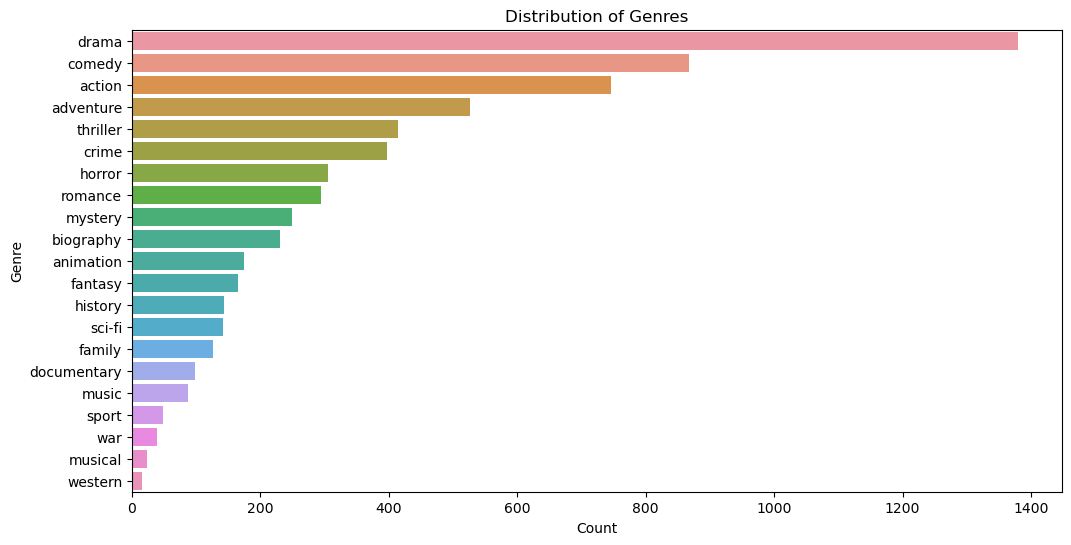

In [76]:
genre_counts = movies_df.filter(like='isgenre_').sum().sort_values(ascending=False)
genre_counts.index = [col.replace('isgenre_', '') for col in genre_counts.index]

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

## Remove Columns

In [77]:
try:
    genres_to_remove = ['isgenre_game-show', 'isgenre_news', 'isgenre_reality-tv', 'isgenre_talk-show']
    movies_df = movies_df[~movies_df[genres_to_remove].any(axis=1)]
    movies_df.drop(columns=genres_to_remove, inplace=True)
    display(movies_df.head())
except:
    print("bad cols not found")
    pass

bad cols not found


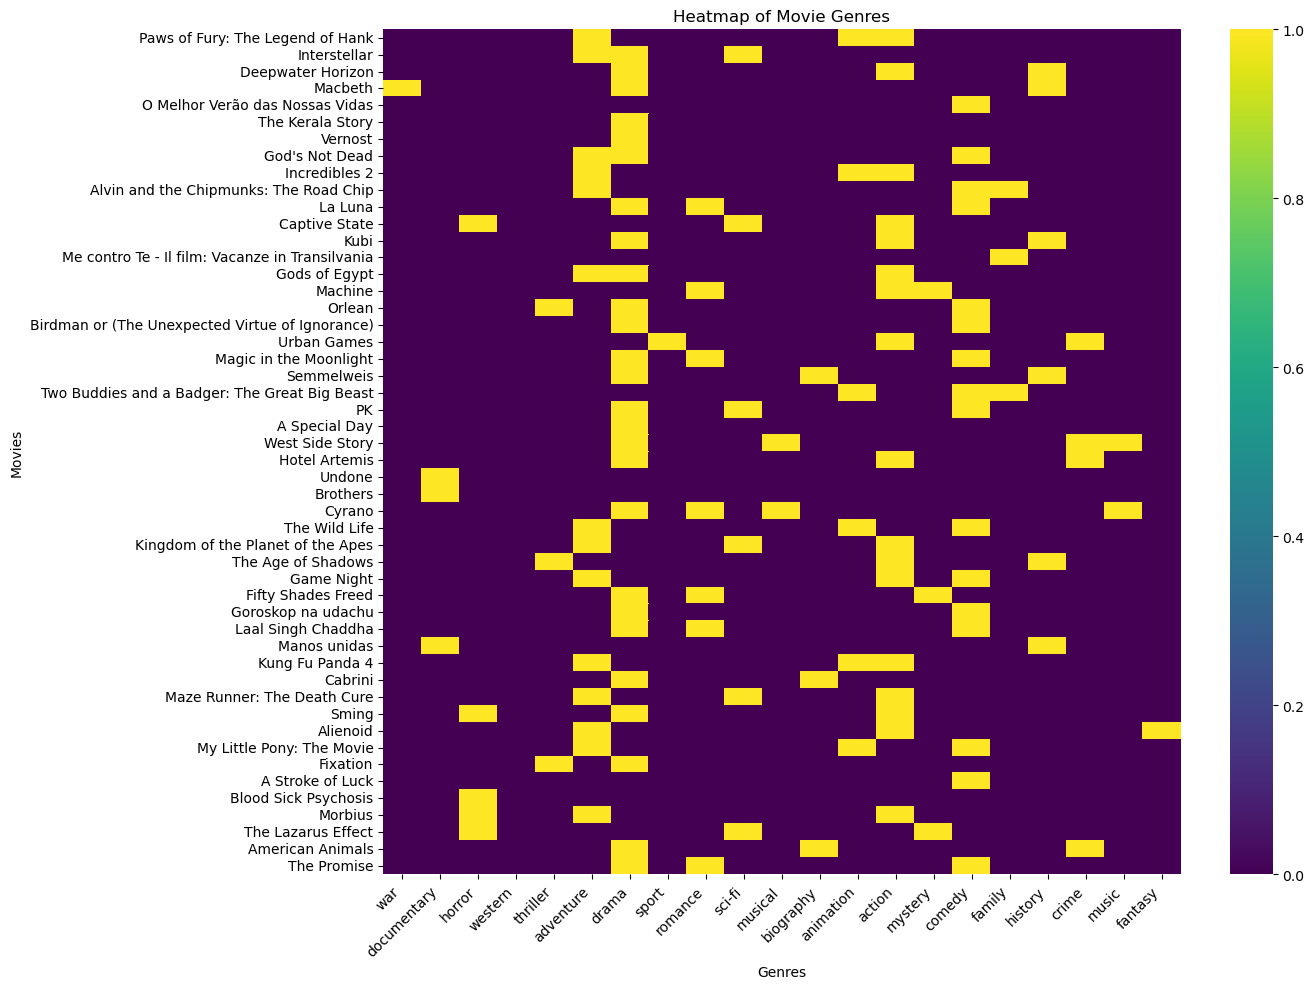

In [78]:
# Filter the columns that start with 'isgenre_'
genre_columns = movies_df.filter(like='isgenre_').columns

# Limit the number of movies for better readability
num_movies_to_display = 50  # Adjust this number based on your needs
movies_df_subset = movies_df.sample(n=num_movies_to_display, random_state=42)

# Generate the heatmap data
heatmap_data = movies_df_subset[genre_columns].astype(int)

# Update the column names to remove 'isgenre_'
heatmap_data.columns = heatmap_data.columns.str.replace('isgenre_', '')

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='viridis', cbar=True, yticklabels=movies_df_subset['primary_title'])
plt.title('Heatmap of Movie Genres')
plt.xlabel('Genres')
plt.ylabel('Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check Data again

## Double Check Data Types

In [79]:
movies_df.dtypes

movie_id                 object
primary_title            object
original_title           object
start_year                int64
runtime_minutes         float64
genres                   object
averagerating           float64
numvotes                float64
title_type               object
is_adult                  Int64
directors                object
writers                  object
actor1                   object
actor2                   object
actor3                   object
studio                   object
domestic_gross          float64
foreign_gross           float32
tn_production_budget    float32
tn_domestic_gross       float32
tn_worldwide_gross      float32
profit                  float32
profit_proportion       float32
isgenre_war                bool
isgenre_documentary        bool
isgenre_horror             bool
isgenre_western            bool
isgenre_thriller           bool
isgenre_adventure          bool
isgenre_drama              bool
isgenre_sport              bool
isgenre_

## Double Check Movie ID is unique

In [80]:
movies_df['movie_id'].value_counts()

tt0293429     1
tt3619854     1
tt3622592     1
tt3623726     1
tt3626742     1
             ..
tt1697800     1
tt1698641     1
tt1700841     1
tt17009348    1
tt9347476     1
Name: movie_id, Length: 2640, dtype: int64

# Genres setup for analysis

In [164]:
# List of genre columns
genre_columns = [col for col in movies_df.columns if col.startswith('isgenre_')]

# Initialize the genre metrics dictionary
genre_metrics = {
    'Genre': [],
    'TotalVotes': [],
    'WeightedAverageRating': [],
    'TotalProfits': [],
    'AverageProfit': [],
    'AverageProportionalProfit': []
}

for genre_col in genre_columns:
    genre_name = genre_col.replace('isgenre_', '')

    # Filter rows where this genre is True
    genre_df = movies_df[movies_df[genre_col]]

    # Calculate total votes
    total_votes = genre_df['numvotes'].sum()
    
    # Calculate weighted average rating
    if total_votes > 0:
        weighted_avg_rating = (genre_df['averagerating'] * genre_df['numvotes']).sum() / total_votes
    else:
        weighted_avg_rating = 0
    
    # Calculate total profits
    total_profits = genre_df['profit'].sum()
    
    # Calculate average profit
    num_movies = len(genre_df)
    if num_movies > 0:
        average_profit = total_profits / num_movies
        average_profit_proportion = genre_df['profit_proportion'].mean()
    else:
        average_profit = 0
        average_profit_proportion = 0

    # Append to metrics
    genre_metrics['Genre'].append(genre_name)
    genre_metrics['TotalVotes'].append(total_votes)
    genre_metrics['WeightedAverageRating'].append(weighted_avg_rating)
    genre_metrics['TotalProfits'].append(total_profits)
    genre_metrics['AverageProfit'].append(average_profit)
    genre_metrics['AverageProportionalProfit'].append(average_profit_proportion)

# Convert to DataFrame
genre_metrics_df = pd.DataFrame(genre_metrics)

# Scale the values for better readability
genre_metrics_df['TotalVotes'] = genre_metrics_df['TotalVotes'] / 1000  # to thousands
genre_metrics_df['TotalProfits'] = genre_metrics_df['TotalProfits'] / 1e6  # to millions
genre_metrics_df['AverageProfit'] = genre_metrics_df['AverageProfit'] / 1e3  # to thousands

# Display the DataFrame
display(genre_metrics_df)


,Genre,TotalVotes,WeightedAverageRating,TotalProfits,AverageProfit,AverageProportionalProfit
0,war,2185.63,7.41,206.47,5294.02,0.49
1,documentary,191.98,6.93,1018.58,10288.70,5.26
2,horror,20107.39,6.44,11169.86,36502.81,6.60
3,western,669.61,6.64,-78.74,-5249.16,-0.55
4,thriller,30946.74,6.79,17369.74,41854.80,4.31
5,adventure,78592.58,7.05,87289.55,165949.70,2.40
6,drama,91647.57,7.25,39748.14,28823.89,2.87
7,sport,1693.94,7.17,975.59,19910.06,0.82
8,romance,12705.44,6.78,6527.76,22128.02,2.92
9,sci-fi,35455.56,7.10,27355.72,192645.93,2.05


# Sample Size Question
Using Confidence Intervals and SEM to see if our sample size is big enough

We don't have a ton of movies with a profit but we need to know if it's enough to be reliable.  That is what we are testing for.

With this we can know if our sample size is enough.

No handles with labels found to put in legend.


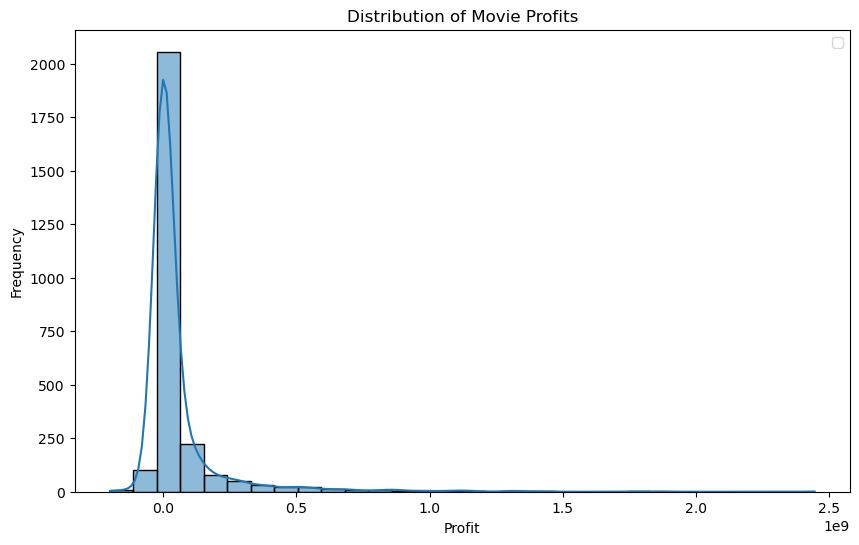

In [82]:
# Sample data: profits
sample_data = movies_df['profit'].dropna()

# Plot distribution of sample data
plt.figure(figsize=(10, 6))
sns.histplot(sample_data, kde=True, bins=30)
plt.title('Distribution of Movie Profits')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Since this is so skewed we can apply a log transformation to see if we can see a normal distribution
Financial data often needs a log transformation

/home/atrix/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


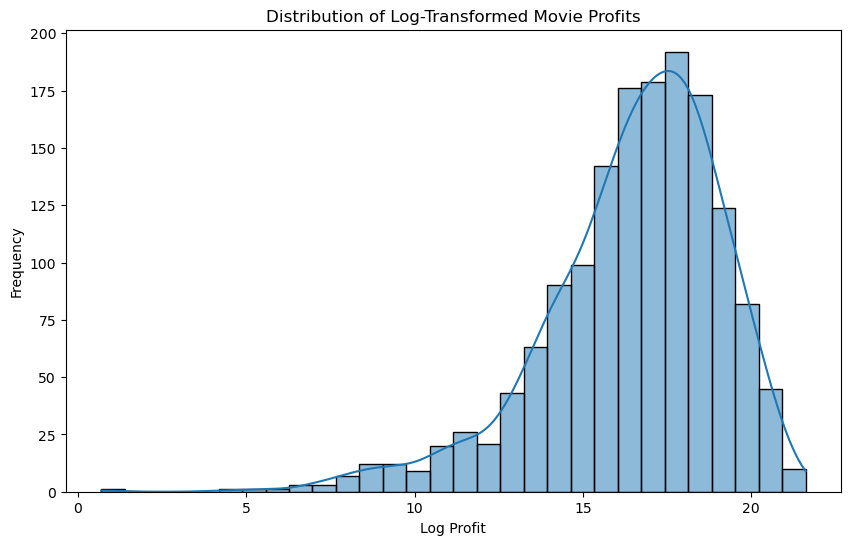

In [83]:
# Apply log transformation to the profit data to handle skewness
# Adding a small constant (1) to avoid log(0)
movies_df['log_profit'] = np.log1p(movies_df['profit'].dropna())

# Plot the distribution of log-transformed profits
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['log_profit'], kde=True, bins=30)
plt.title('Distribution of Log-Transformed Movie Profits')
plt.xlabel('Log Profit')
plt.ylabel('Frequency')
plt.show()


That looks a lot better.  We have some outliers where things aren't profitable pooling near the left side.  We expect that so it's fine.
We might divide our stats into profitable and not profitable tho?

In [84]:
# Function to identify outliers using IQR
def identify_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]
    return outliers

# Identify outliers in the profit data
profit_outliers = identify_outliers(movies_df['profit'].dropna())

# Filter the DataFrame to include only outliers
outliers_df = movies_df[movies_df['profit'].isin(profit_outliers)]

# Set display options to show full DataFrame
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

# Print the details of outliers
outliers_details = outliers_df[['movie_id', 'primary_title', 'tn_production_budget', 'tn_worldwide_gross', 'profit']]
display(outliers_details)


,movie_id,primary_title,tn_production_budget,tn_worldwide_gross,profit
932,tt0369610,Jurassic World,215000000.00,1648854912.00,1433854976.00
942,tt0437086,Alita: Battle Angel,170000000.00,402976032.00,232976032.00
949,tt0448115,Shazam!,85000000.00,362899744.00,277899744.00
951,tt0451279,Wonder Woman,150000000.00,821133376.00,671133376.00
952,tt0455944,The Equalizer,55000000.00,192903616.00,137903616.00
...,...,...,...,...,...
163875,tt6869948,Truth or Dare,3500000.00,95127344.00,91627344.00
164956,tt6966692,Green Book,23000000.00,322034432.00,299034432.00
165392,tt7002100,Coco,175000000.00,798008128.00,623008128.00
167938,tt7232438,The Promise,90000000.00,10551417.00,-79448584.00


# EDA Chisum

## Correlations of Movies
While this won't tell us causes it will inform us on what things usually occur together

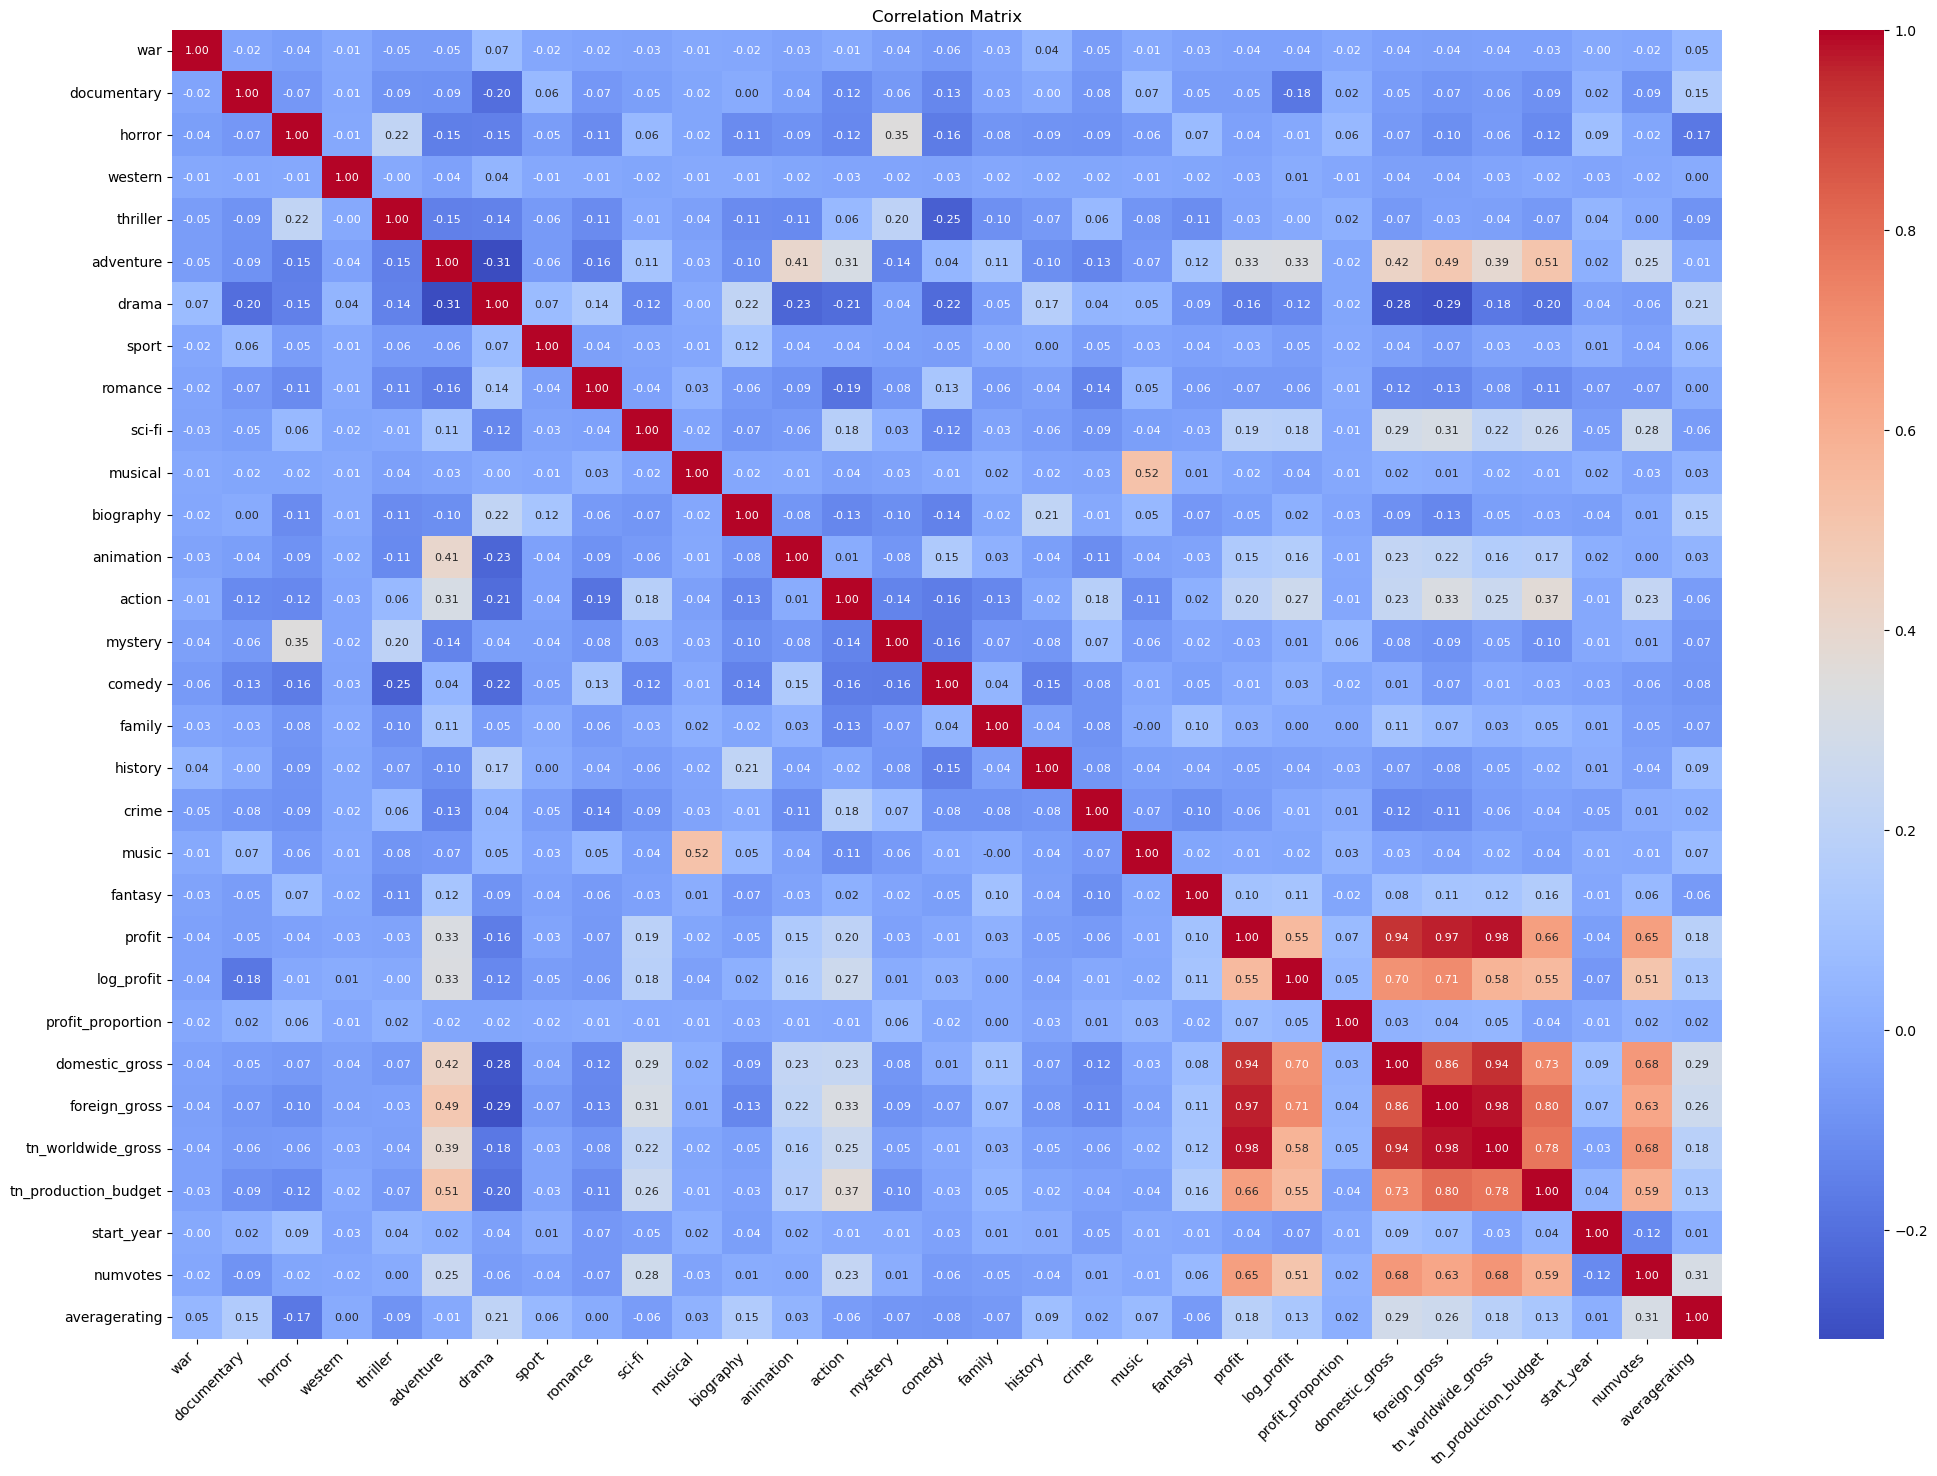

In [85]:
cols = movies_df.columns.to_list()
cols = [c for c in cols if c.startswith("isgenre_")]
cols = cols + ['profit', 'log_profit', 'profit_proportion','domestic_gross','foreign_gross','tn_worldwide_gross', 'tn_production_budget', 'start_year','numvotes','averagerating']

labels = [c.replace('isgenre_', '') for c in cols]
col_to_label = {cols[i]: labels[i] for i in range(len(cols))}
genre_to_profit = movies_df[cols]
genre_to_profit_renamed = genre_to_profit.rename(columns=col_to_label)

# Plot the heatmap
plt.figure(figsize=(25, 17))  # Increase the figure size
sns.heatmap(genre_to_profit_renamed.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})  # Adjust annotation font size
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are not rotated
plt.show()



### Notes on Correlation

In [86]:
def calc_and_show_corr(local_df,fpath,filter=.2):
    # Calculate the correlation matrix
    corr_matrix = local_df.corr()

    # Extract the upper triangle of the correlation matrix without the diagonal
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Convert the upper triangle to a tidy DataFrame
    corr_pairs = upper_triangle.stack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

    # Filter correlations with magnitudes less than 0.2
    filtered_corr_pairs = corr_pairs[corr_pairs['Correlation'].abs() >= filter]

    # Sort by correlation values, preserving direction
    sorted_corr_pairs = filtered_corr_pairs.sort_values(by='Correlation', ascending=False)

    # Display the sorted correlations
    #display(sorted_corr_pairs)

    # Initialize the notes column to be blank
    sorted_corr_pairs['Notes'] = ""

    # Step 2: Attempt to load existing notes from a CSV file
    try:
        notes_df = pd.read_csv(fpath)
        # Merge the notes into the sorted_corr_pairs DataFrame
        sorted_corr_pairs = sorted_corr_pairs.merge(
            notes_df[['Feature1', 'Feature2', 'Notes']],
            on=['Feature1', 'Feature2'],
            how='left',
            suffixes=('', '_old')
        )
        # If 'Notes' column from the old notes CSV is present, use it; otherwise, keep it blank
        sorted_corr_pairs['Notes'] = sorted_corr_pairs['Notes_old'].combine_first(sorted_corr_pairs['Notes'])
        sorted_corr_pairs.drop(columns=['Notes_old'], inplace=True)
    except FileNotFoundError:
        print("Notes file not found. Proceeding without loading existing notes.")

    # Step 3: Save the updated DataFrame to a CSV file with the new correlation order and notes
    sorted_corr_pairs.to_csv(fpath, index=False)

    # Display the updated DataFrame with notes
    display(sorted_corr_pairs)
calc_and_show_corr(movies_df,'correlation_analysis.csv')

,Feature1,Feature2,Correlation,Notes
0,domestic_gross,tn_domestic_gross,1.00,expected to match
1,tn_worldwide_gross,profit,0.98,Global box office performance is a primary driver of profitability.
2,foreign_gross,tn_worldwide_gross,0.98,Strong performance in international markets boosts overall revenue.
3,foreign_gross,profit,0.97,International markets significantly contribute to profitability.
4,tn_domestic_gross,tn_worldwide_gross,0.94,Domestic performance is closely tied to global success.
...,...,...,...,...
79,isgenre_thriller,isgenre_comedy,-0.25,
80,tn_domestic_gross,isgenre_drama,-0.26,Drama movies perform worse domestically.
81,domestic_gross,isgenre_drama,-0.28,Drama movies tend to perform worse domestically.
82,foreign_gross,isgenre_drama,-0.29,Drama movies perform worse internationally.


### Analysis of Correlation

**Key Insights**

Profitablity is heavily correlated with both domestic and international performance.  Performing well domestically or internationally predicts performing well overall and with each other.

Higher production budgets often lead to better profit and gross in all markets.

More reviews typically mean a higher profit and gross in all markets.

Adventure movies tend to have larger budgets and tend to make more profit and gross.

Action movies tend to have larger production budgets and tend to make more profit and gross.

Sci-fi movies tend to do well in both profit and gross.  Sci-fi movies have larger production budgets.

Documentaries tend to receive higher average ratings.

Higher rated movies tend to have higher profit and gross but it is a weaker indicator than genre or budgets.

Longer movies tend to be more profitable.  Longer movies tend to have larger budgets.

Animation movies perform well in profit and gross.

Worldwide gross and relative profitability has slightly decreased over time.

Documentaries tend to have lower profitability and gross but have higher ratings.

Drama movies tend to perform worse overall.

Horror movies tend to have lower average ratings.

Documentary and Comedy is a rare combination.

Documentary and Dramas is a rare combination.


In [87]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 909 to 190385
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              2640 non-null   object 
 1   primary_title         2640 non-null   object 
 2   original_title        2640 non-null   object 
 3   start_year            2640 non-null   int64  
 4   runtime_minutes       2606 non-null   float64
 5   genres                2640 non-null   object 
 6   averagerating         2591 non-null   float64
 7   numvotes              2591 non-null   float64
 8   title_type            2640 non-null   object 
 9   is_adult              2640 non-null   Int64  
 10  directors             1817 non-null   object 
 11  writers               1772 non-null   object 
 12  actor1                1777 non-null   object 
 13  actor2                1759 non-null   object 
 14  actor3                1737 non-null   object 
 15  studio           

### Profit Proportion Case
It doesn't seem to have a strong correlation to anything so we will investigate why

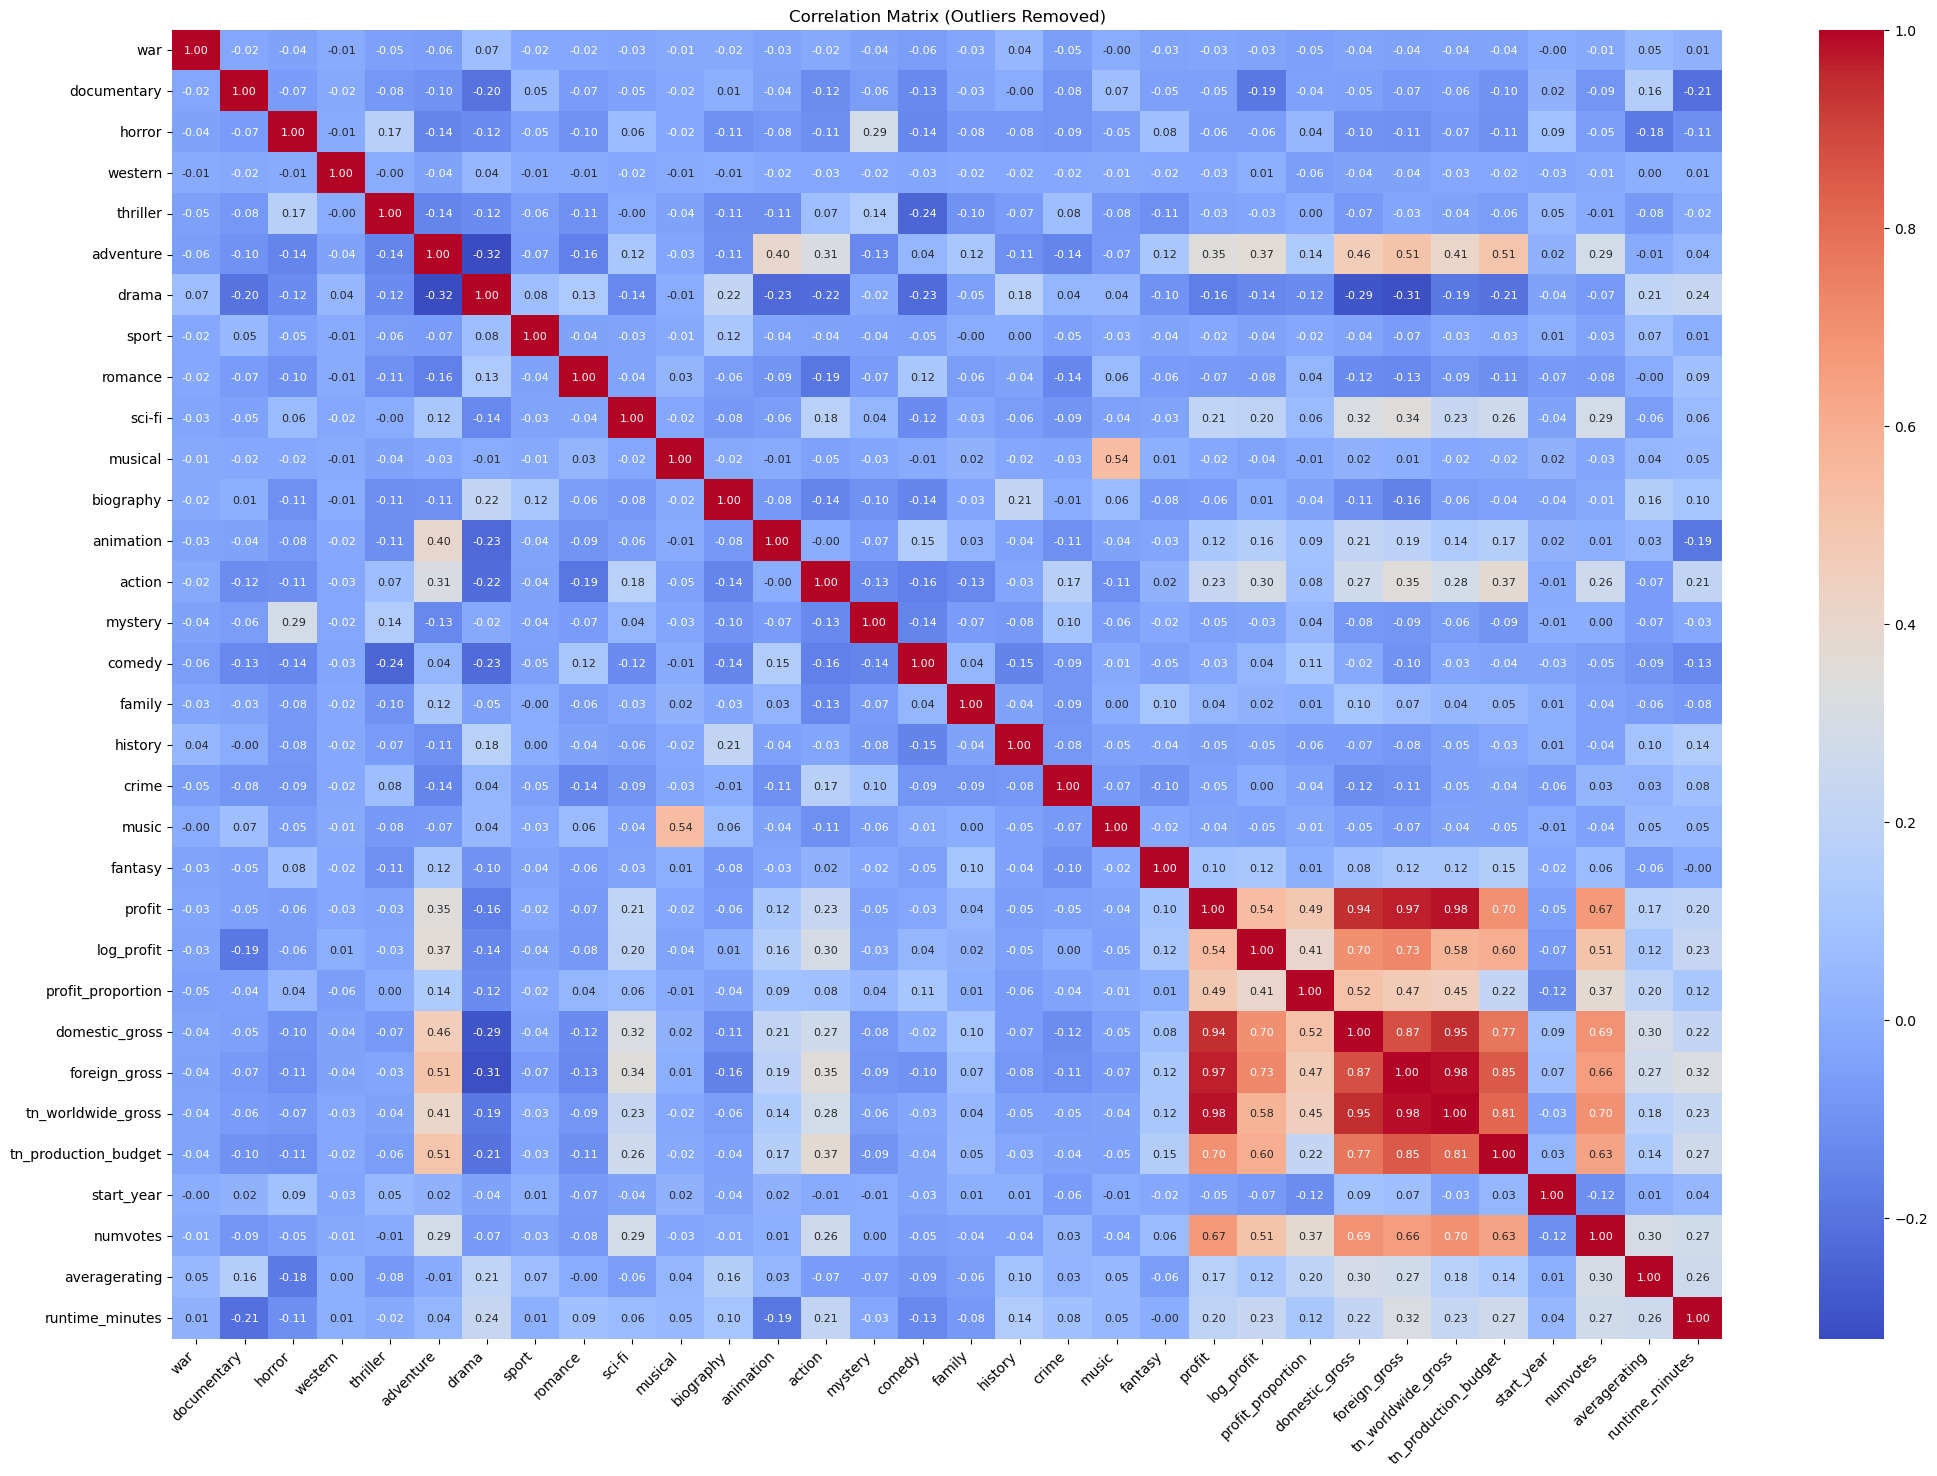

In [88]:
# Calculate the IQR for 'profit_proportion'
Q1 = movies_df['profit_proportion'].quantile(0.25)
Q3 = movies_df['profit_proportion'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
iqr_movies_df = movies_df[(movies_df['profit_proportion'] >= lower_bound) & (movies_df['profit_proportion'] <= upper_bound)]

# Recalculate the correlation matrix without outliers
cols = iqr_movies_df.columns.to_list()
cols = [c for c in cols if c.startswith("isgenre_")]
cols = cols + ['profit', 'log_profit', 'profit_proportion', 'domestic_gross', 'foreign_gross', 'tn_worldwide_gross', 'tn_production_budget', 'start_year', 'numvotes', 'averagerating','runtime_minutes']

labels = [c.replace('isgenre_', '') for c in cols]
col_to_label = {cols[i]: labels[i] for i in range(len(cols))}
genre_to_profit_filtered = iqr_movies_df[cols]
genre_to_profit_renamed_filtered = genre_to_profit_filtered.rename(columns=col_to_label)

# Plot the heatmap for the filtered data
plt.figure(figsize=(25, 17))  # Increase the figure size
sns.heatmap(genre_to_profit_renamed_filtered.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})  # Adjust annotation font size
plt.title('Correlation Matrix (Outliers Removed)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are not rotated
plt.show()


In [89]:
calc_and_show_corr(iqr_movies_df,'correlation_analysis_iqr.csv',.1)

,Feature1,Feature2,Correlation,Notes
0,domestic_gross,tn_domestic_gross,1.00,Domestic gross is almost perfectly correlated with tn_domestic_gross ensuring consistent revenue measurement.
1,foreign_gross,tn_worldwide_gross,0.98,High correlation indicates the significance of international markets in overall worldwide gross.
2,tn_worldwide_gross,profit,0.98,Worldwide gross strongly impacts overall profit; prioritize global appeal to maximize profit.
3,foreign_gross,profit,0.97,Foreign gross significantly contributes to profit; focus on international marketing.
4,tn_domestic_gross,tn_worldwide_gross,0.95,Domestic gross is a major component of worldwide gross; balance domestic and international strategies.
...,...,...,...,...
185,isgenre_thriller,isgenre_comedy,-0.24,Thriller and comedy genres are inversely related; target different audiences.
186,tn_domestic_gross,isgenre_drama,-0.27,Drama films tend to perform lower in domestic markets; strategize accordingly.
187,domestic_gross,isgenre_drama,-0.29,Drama films have lower domestic gross; consider market preferences.
188,foreign_gross,isgenre_drama,-0.31,Drama films have lower foreign gross; adjust international marketing strategies.


### IQR Profit Proporition Correlation Analysis
We'll focus on new insights from using the IQR

The biggest thing is that ROI/Profit Proportion now is properly correlated with things like profit, which make sense.

There is a smaller corrleation between genres and ROI suggesting that what correlates to ROI is multifacted and diverse.  Adventure and comedy have a slight impact on predicting ROI postively and drama does so negatively.

Number of votes and implicitly popularity is a better predictor of genre than quite a bit, suggesting picking well known IPs for example can be influential.

Average rating has MORE correlation with ROI than it does with raw profit, suggesting good movies tend to have a good return, despite budgets.


We'll also breakdown each genre a bit:

**Horror**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak negative relationship, suggesting they have weaker returns in scale to their budgets.
* **Budget**: weak negative relationship, indicating they tend to be lower budget.
* **Ratings**: very weak relationship with ratings, receive mixed reviews.
* **Numvotes**: weak relation to number of votes, suggesting moderate audience engagement with horror film reviews.

**Mystery**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, indicating potential for moderate returns.
* **Budget**: weak positive relationship, suggesting slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting slightly better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Western**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak negative relationship, suggesting weaker returns relative to their budgets.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: very weak positive relationship, suggesting mixed reviews.
* **Numvotes**: very weak relationship with number of votes, indicating low audience engagement.

**War**
* **Profit**: weak positive relationship, indicating potential for higher profits.
* **ROI**: weak positive relationship, suggesting potential for better returns.
* **Budget**: weak positive relationship, indicating higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Adventure**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: moderate positive relationship, indicating higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: moderate positive relationship, indicating higher audience engagement.

**Thriller**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting slightly better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Biography**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Documentary**
* **Profit**: weak negative relationship, suggesting lower profits.
* **ROI**: weak negative relationship, indicating lower returns relative to budgets.
* **Budget**: weak negative relationship, indicating lower budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak negative relationship, indicating lower audience engagement.

**Drama**
* **Profit**: weak negative relationship, suggesting lower profits.
* **ROI**: weak negative relationship, indicating lower returns relative to budgets.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Fantasy**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: moderate positive relationship, indicating higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Music**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Action**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: moderate positive relationship, indicating higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: moderate positive relationship, indicating higher audience engagement.

**Romance**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Sci-fi**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: moderate positive relationship, indicating higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: moderate positive relationship, indicating higher audience engagement.

**Sport**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Family**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Musical**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**History**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Comedy**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Crime**
* **Profit**: do not have a strong direct relationship with profit.
* **ROI**: weak positive relationship, suggesting potential for moderate returns.
* **Budget**: weak positive relationship, indicating slightly higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: weak positive relationship, indicating moderate audience engagement.

**Animation**
* **Profit**: weak positive relationship, suggesting potential for higher profits.
* **ROI**: weak positive relationship, indicating potential for better returns.
* **Budget**: moderate positive relationship, indicating higher budgets.
* **Ratings**: weak positive relationship, suggesting better reviews.
* **Numvotes**: moderate positive relationship, indicating higher audience engagement.


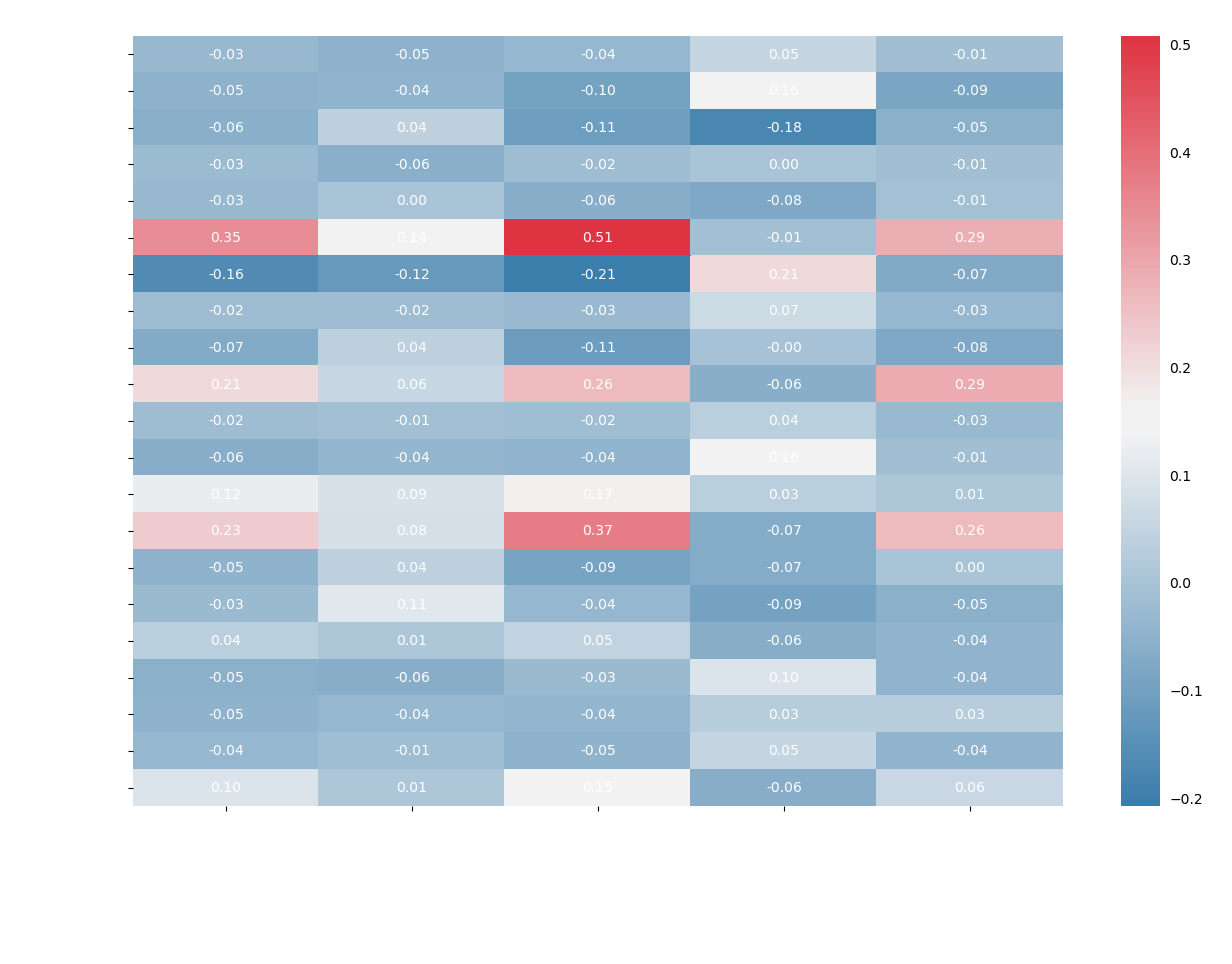

In [90]:
# Recalculate the correlation matrix for specific metrics and genres
metrics = ['profit', 'profit_proportion', 'tn_production_budget', 'averagerating', 'numvotes']
genres = [c for c in iqr_movies_df.columns if c.startswith("isgenre_")]

# Create a DataFrame to store the correlations
correlation_data = {}

for genre in genres:
    genre_name = genre.replace('isgenre_', '')
    correlation_data[genre_name] = []
    for metric in metrics:
        correlation = iqr_movies_df[genre].corr(iqr_movies_df[metric])
        correlation_data[genre_name].append(correlation)

# Convert the dictionary to a DataFrame
correlation_df = pd.DataFrame(correlation_data, index=metrics).T

# Define a custom palette for a movie-like feel
movie_palette = sns.diverging_palette(240, 10, n=9, sep=10, s=80, l=50, as_cmap=True)

# Plot the heatmap for the filtered data
plt.figure(figsize=(15, 10), facecolor='none')  # Adjust the figure size and set facecolor to none for transparency
ax = sns.heatmap(correlation_df, annot=True, cmap=movie_palette, fmt='.2f', annot_kws={"size": 10, "color": "white"})  # Adjust annotation font size and color
plt.title('Correlation between Genres and Key Metrics (Outliers Removed)', fontsize=16, color='white')
plt.xlabel('Metrics', fontsize=12, color='white')
plt.ylabel('Genres', fontsize=12, color='white')
plt.xticks(rotation=45, ha='right', fontsize=10, color='white')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=10, color='white')  # Ensure y-axis labels are not rotated

# Change the color of the x and y ticks
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('white')

# Change the color of the color bar ticks and label
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_tick_params(color='white')
colorbar.set_label('Correlation', color='white')
for tick in colorbar.ax.yaxis.get_major_ticks():
    tick.label1.set_color('white')

plt.gca().set_facecolor('none')  # Set the axes facecolor to none for transparency
plt.show()


# Recalc genres stats with IQR

In [165]:
# List of genre columns
genre_columns = [col for col in iqr_movies_df.columns if col.startswith('isgenre_')]

# Initialize the genre metrics dictionary
genre_metrics = {
    'Genre': [],
    'TotalVotes': [],
    'WeightedAverageRating': [],
    'TotalProfits': [],
    'AverageProfit': [],
    'AverageProportionalProfit': []
}

for genre_col in genre_columns:
    genre_name = genre_col.replace('isgenre_', '')

    # Filter rows where this genre is True
    genre_df = iqr_movies_df[iqr_movies_df[genre_col]]

    # Calculate total votes
    total_votes = genre_df['numvotes'].sum()
    
    # Calculate weighted average rating
    if total_votes > 0:
        weighted_avg_rating = (genre_df['averagerating'] * genre_df['numvotes']).sum() / total_votes
    else:
        weighted_avg_rating = 0
    
    # Calculate total profits
    total_profits = genre_df['profit'].sum()
    
    # Calculate average profit
    num_movies = len(genre_df)
    if num_movies > 0:
        average_profit = total_profits / num_movies
        average_profit_proportion = genre_df['profit_proportion'].mean()
    else:
        average_profit = 0
        average_profit_proportion = 0

    # Append to metrics
    genre_metrics['Genre'].append(genre_name)
    genre_metrics['TotalVotes'].append(total_votes)
    genre_metrics['WeightedAverageRating'].append(weighted_avg_rating)
    genre_metrics['TotalProfits'].append(total_profits)
    genre_metrics['AverageProfit'].append(average_profit)
    genre_metrics['AverageProportionalProfit'].append(average_profit_proportion)

# Convert to DataFrame
genre_metrics_df = pd.DataFrame(genre_metrics)

# Scale the values for better readability
genre_metrics_df['TotalVotes'] = genre_metrics_df['TotalVotes'] / 1000  # to thousands
genre_metrics_df['TotalProfits'] = genre_metrics_df['TotalProfits'] / 1e6  # to millions
genre_metrics_df['AverageProfit'] = genre_metrics_df['AverageProfit'] / 1e3  # to thousands

# Display the DataFrame
display(genre_metrics_df)


,Genre,TotalVotes,WeightedAverageRating,TotalProfits,AverageProfit,AverageProportionalProfit
0,war,2075.17,7.37,195.76,5151.53,0.08
1,documentary,167.55,6.78,524.91,5832.36,0.41
2,horror,11495.09,6.22,4448.94,18011.90,1.07
3,western,669.61,6.64,-78.74,-5249.16,-0.55
4,thriller,24202.46,6.82,11937.26,32704.83,0.84
5,adventure,74992.52,7.05,76184.47,150860.34,1.35
6,drama,75901.68,7.16,26594.69,20858.58,0.61
7,sport,1693.80,7.17,975.47,20322.24,0.58
8,romance,9805.50,6.71,3651.31,13936.28,1.03
9,sci-fi,32004.59,7.10,23799.89,181678.58,1.28


# Exploratory Data Analysis

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,scaled_dom_gross
0,1,2009-12-18,Avatar,425000000.00,760507648.00,2776345344.00,2009,760.51
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.00,241063872.00,1045663872.00,2011,241.06
2,3,2019-06-07,Dark Phoenix,350000000.00,42762352.00,149762352.00,2019,42.76
3,4,2015-05-01,Avengers: Age of Ultron,330600000.00,459005856.00,1403014016.00,2015,459.01
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.00,620181376.00,1316721792.00,2017,620.18


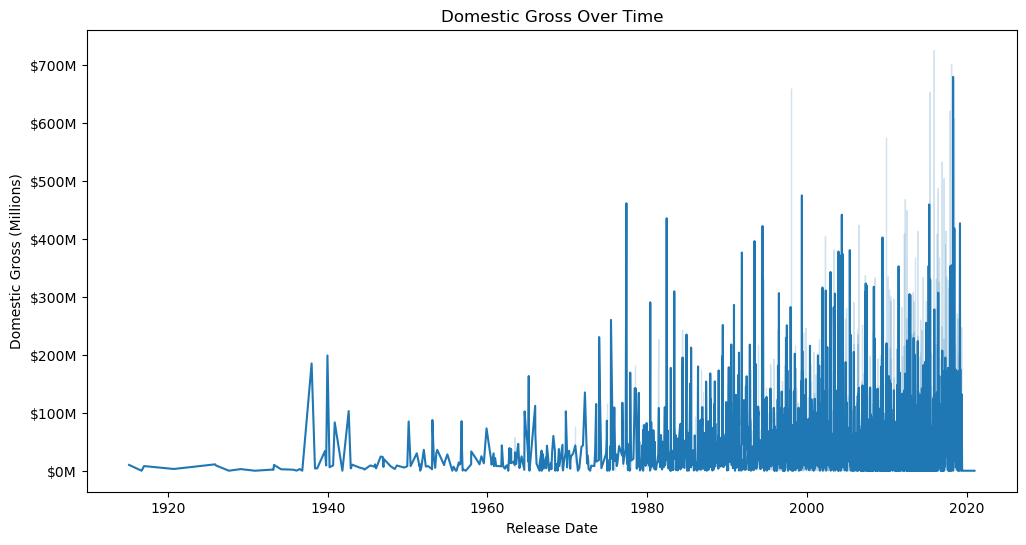

In [131]:
from matplotlib.ticker import FuncFormatter
# Just getting a visual of domestic gross over the years
#display(tn_movie_budgets.head())
tn_movie_budgets['scaled_dom_gross'] = tn_movie_budgets['domestic_gross'] / 1e6 #scale to millions

def add_currency_symbol(x, pos):
    return f'${x:,.0f}M'

# Plotting the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_date', y='scaled_dom_gross', data=tn_movie_budgets)
plt.title('Domestic Gross Over Time')
plt.xlabel('Release Date')
plt.ylabel('Domestic Gross (Millions)')

# Apply the currency formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(add_currency_symbol))

plt.show()

In [132]:
# Look at only the data with usable values for the gross/profits
movies_without_nan_profit = iqr_movies_df.dropna(subset=['profit'])

# Display the first few rows
movies_without_nan_profit.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,directors,writers,actor1,actor2,actor3,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,profit,profit_proportion,isgenre_war,isgenre_documentary,isgenre_horror,isgenre_western,isgenre_thriller,isgenre_adventure,isgenre_drama,isgenre_sport,isgenre_romance,isgenre_sci-fi,isgenre_musical,isgenre_biography,isgenre_animation,isgenre_action,isgenre_mystery,isgenre_comedy,isgenre_family,isgenre_history,isgenre_crime,isgenre_music,isgenre_fantasy,log_profit
909,tt0293429,Mortal Kombat,Mortal Kombat,2021,110.00,"Action,Adventure,Fantasy",6.00,191172.00,movie,0,Simon McQuoid,Greg Russo,NaN,NaN,NaN,NaN,NaN,NaN,55000000.00,NaN,83601016.00,28601016.00,0.52,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,17.17
914,tt0315642,Wazir,Wazir,2016,103.00,"Action,Crime,Drama",7.10,19991.00,movie,0,Bejoy Nambiar,Vidhu Vinod Chopra/Abhijat Joshi/Shubhra Swarup/Bejoy Nambiar/Abhijeet Shirish Deshpande/Natasha Sahgal/Gazal Dhaliwal/Shubhra Marfatia,Amitabh Bachchan,Farhan Akhtar,Aditi Rao Hydari,Relbig.,1100000.00,NaN,5200000.00,NaN,5633588.00,433588.00,0.08,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,12.98
930,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.00,"Action,Crime,Drama",6.50,127615.00,movie,0,Scott Frank,Lawrence Block/Scott Frank,Liam Neeson,Dan Stevens,David Harbour,Uni.,26017684.00,36090904.00,28000000.00,26017684.00,62108588.00,34108588.00,1.22,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,17.35
932,tt0369610,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",6.90,682448.00,movie,0,Colin Trevorrow,Michael Crichton/Rick Jaffa/Amanda Silver/Colin Trevorrow/Derek Connolly,Chris Pratt,Bryce Dallas Howard,Ty Simpkins,Uni.,652270656.00,996584256.00,215000000.00,652270656.00,1648854912.00,1433854976.00,6.67,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,21.08
934,tt0376479,American Pastoral,American Pastoral,2016,108.00,"Crime,Drama,Mystery",6.10,18140.00,movie,0,Ewan McGregor,John Romano/Philip Roth,Ewan McGregor,Jennifer Connelly,Dakota Fanning,LGF,544000.00,NaN,10000000.00,NaN,2063436.00,-7936564.00,-0.79,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,NaN


## Genre Analysis vs Profit and ROI

In [ ]:
# Looking at the top 10 movies with the highest profit
top_profitable_movies = movies_without_nan_profit.sort_values(by='profit', ascending=False)

# Display the top 10 most profitable movies
print(top_profitable_movies[['primary_title', 'tn_worldwide_gross', 'tn_production_budget', 'profit']].head(10))

                                     primary_title  tn_worldwide_gross  tn_production_budget        profit
125598                           Avengers: Endgame       2800000000.00          356000000.00 2444000000.00
53820                     Avatar: The Way of Water       2320250368.00          460000000.00 1860250368.00
78843   Star Wars: Episode VII - The Force Awakens       2068223616.00          245000000.00 1823223552.00
125597                      Avengers: Infinity War       2048134144.00          300000000.00 1748134144.00
932                                 Jurassic World       1648854912.00          215000000.00 1433854976.00
153635                               The Lion King       1663000064.00          260000000.00 1403000064.00
91101                                    Furious 7       1518722816.00          190000000.00 1328722816.00
56998                            Top Gun: Maverick       1488732800.00          170000000.00 1318732800.00
130715                               

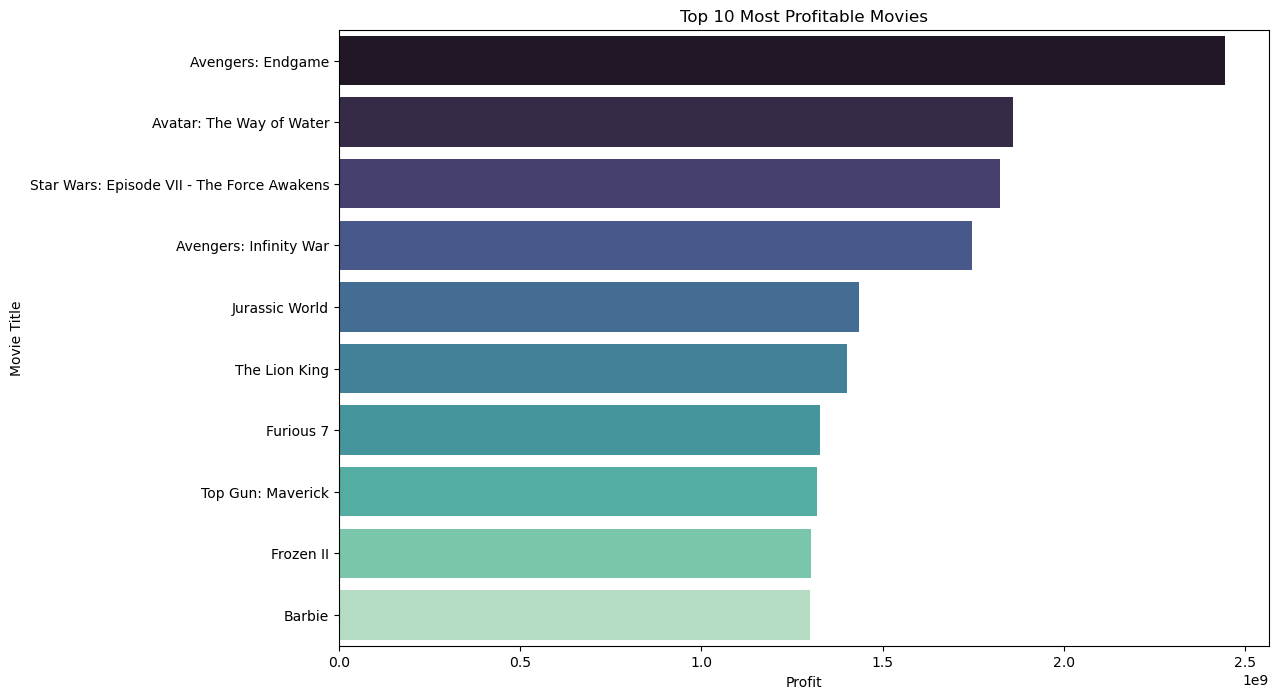

In [ ]:
# Putting those movies into something visual

top_10_profitable_movies = top_profitable_movies.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='profit', y='primary_title', data=top_10_profitable_movies, palette='mako')
plt.title('Top 10 Most Profitable Movies')
plt.xlabel('Profit')
plt.ylabel('Movie Title')
plt.show()

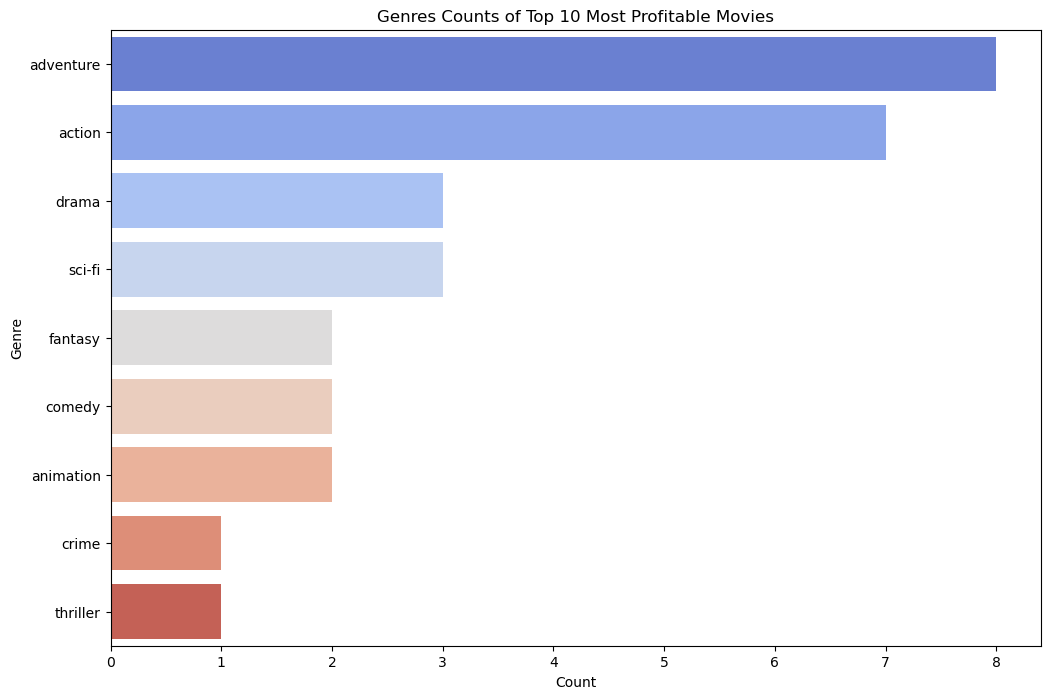

In [136]:
# Create a DataFrame for the top 10 profitable movies' genres using one-hot encoding
top_10_genres_df = top_10_profitable_movies[genre_columns]

# Sum the one-hot encoded columns to get the count of each genre
genre_counts_top10 = top_10_genres_df.sum().sort_values(ascending=False)

# Extract the genre names by removing the 'isgenre_' prefix
genre_counts_top10.index = genre_counts_top10.index.str.replace('isgenre_', '')

genre_counts_top10 = genre_counts_top10[genre_counts_top10 > 0]

#genre_counts_top10 = [genre_counts_top10[]]

# Plot the genre counts
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts_top10.values, y=genre_counts_top10.index, palette='coolwarm')
plt.title('Genres Counts of Top 10 Most Profitable Movies')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


In [160]:
display(genre_metrics_df.head())

,Genre,TotalVotes,WeightedAverageRating,TotalProfits,AverageProfit,AverageProportionalProfit
0,war,2075.17,7.37,195.76,5151.53,0.08
1,documentary,167.55,6.78,524.91,5832.36,0.41
2,horror,11495.09,6.22,4448.94,18011.90,1.07
3,western,669.61,6.64,-78.74,-5249.16,-0.55
4,thriller,24202.46,6.82,11937.26,32704.83,0.84


## Total Profit vs Genre

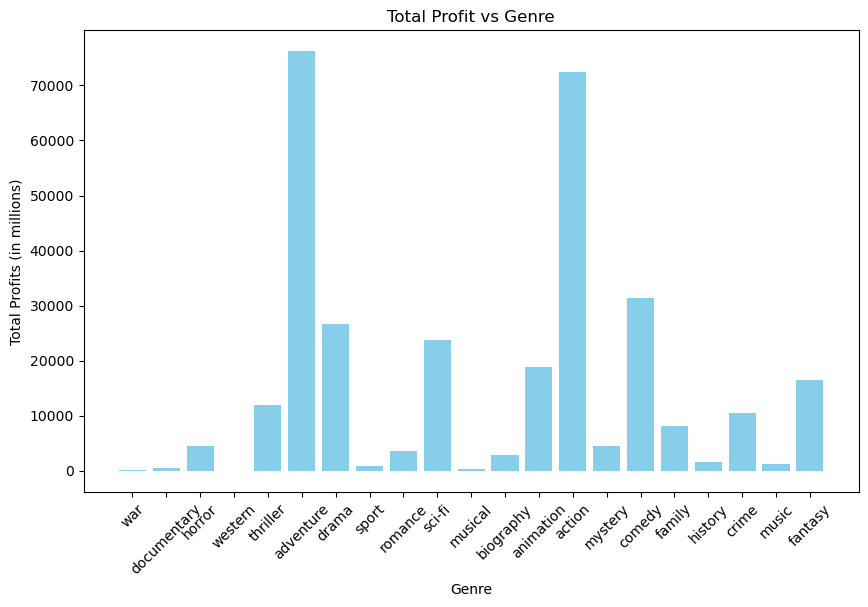

In [161]:
# Plotting Total Profit vs Genre
plt.figure(figsize=(10, 6))
plt.bar(genre_metrics_df['Genre'], genre_metrics_df['TotalProfits'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Total Profits (in millions)')
plt.title('Total Profit vs Genre')
plt.xticks(rotation=45)
plt.show()


## Average Profit vs Genre

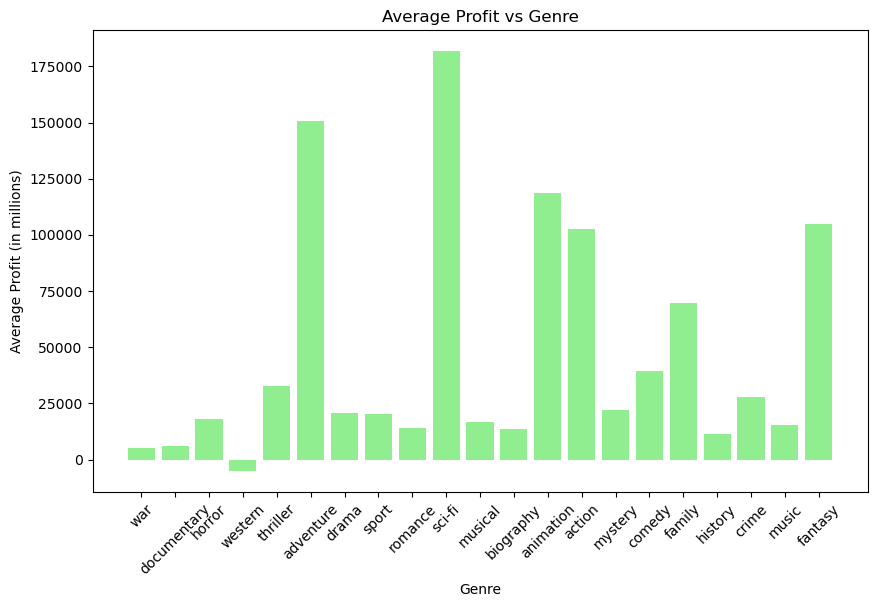

In [162]:
# Plotting Average Profit vs Genre
plt.figure(figsize=(10, 6))
plt.bar(genre_metrics_df['Genre'], genre_metrics_df['AverageProfit'], color='lightgreen')
plt.xlabel('Genre')
plt.ylabel('Average Profit (in millions)')
plt.title('Average Profit vs Genre')
plt.xticks(rotation=45)
plt.show()


## ROI vs Genre

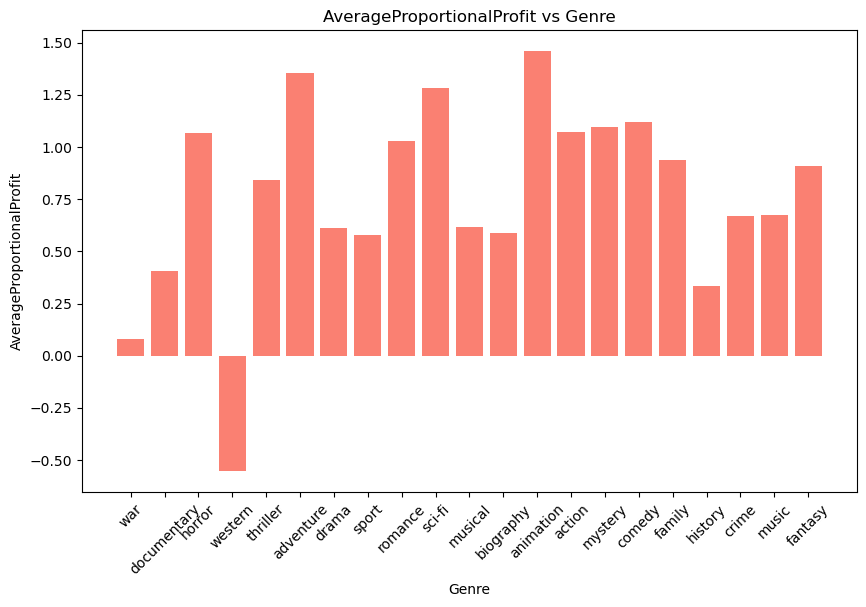

In [167]:
# Plotting ROI vs Genre
plt.figure(figsize=(10, 6))
plt.bar(genre_metrics_df['Genre'], genre_metrics_df['AverageProportionalProfit'], color='salmon')
plt.xlabel('Genre')
plt.ylabel('AverageProportionalProfit')
plt.title('AverageProportionalProfit vs Genre')
plt.xticks(rotation=45)
plt.show()


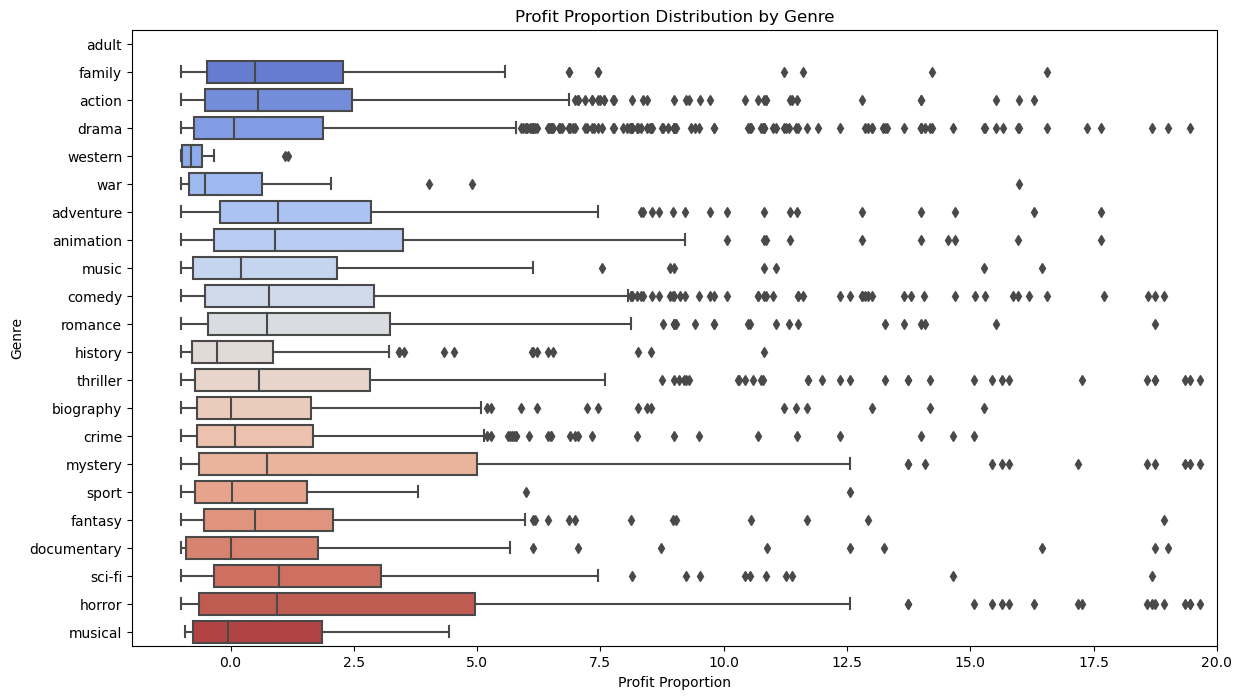

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='profit_proportion', y='genre', data=melted_df_prop, palette='coolwarm')
plt.title('Profit Proportion Distribution by Genre')
plt.xlabel('Profit Proportion')
plt.ylabel('Genre')
plt.xlim(-2, 20)
plt.show()

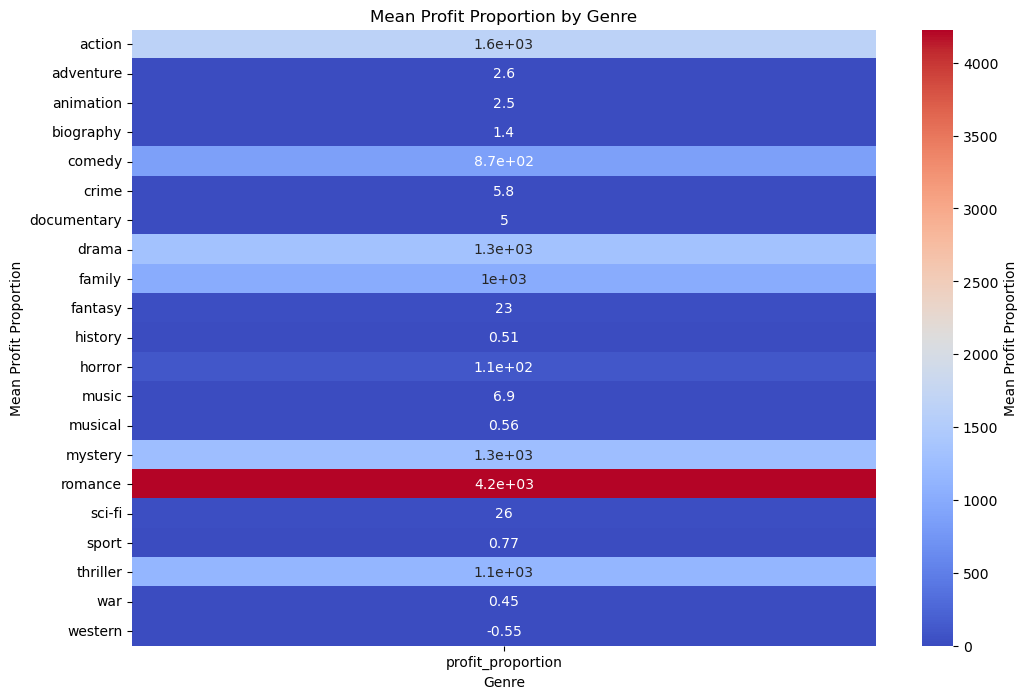

In [ ]:
# Visualizing a heatmap to compare the profit proportion

genre_profit_pivot = melted_df_prop.pivot_table(index='genre', values='profit_proportion', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(genre_profit_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Profit Proportion'})
plt.title('Mean Profit Proportion by Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Profit Proportion')
plt.show()

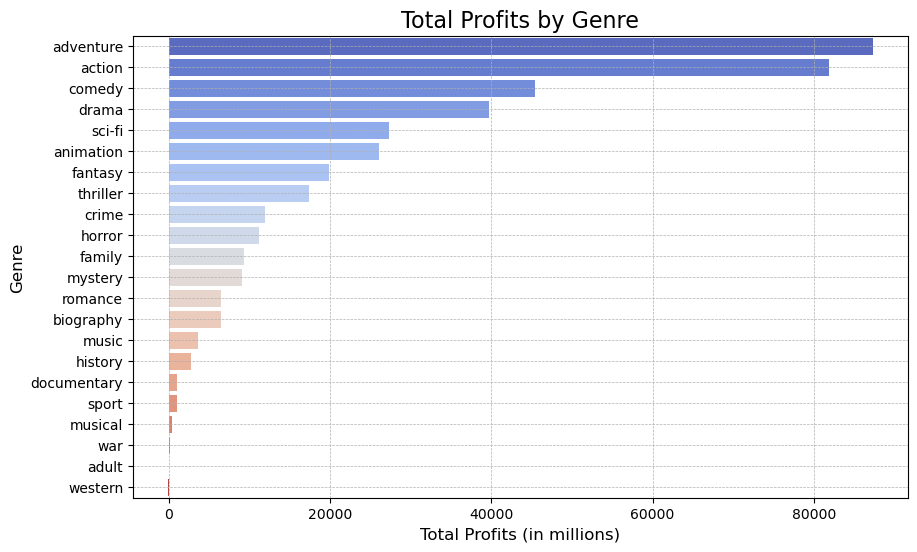

In [ ]:
# Create a color palette that spans from hot to cool
num_genres = len(genre_metrics_df)
hot_to_cool_palette = sns.color_palette("coolwarm", num_genres)
# Plot total profits by genre
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalProfits', y='Genre', data=genre_metrics_df.sort_values(by='TotalProfits', ascending=False), palette=hot_to_cool_palette)
plt.title('Total Profits by Genre', fontsize=16)
plt.xlabel('Total Profits (in millions)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

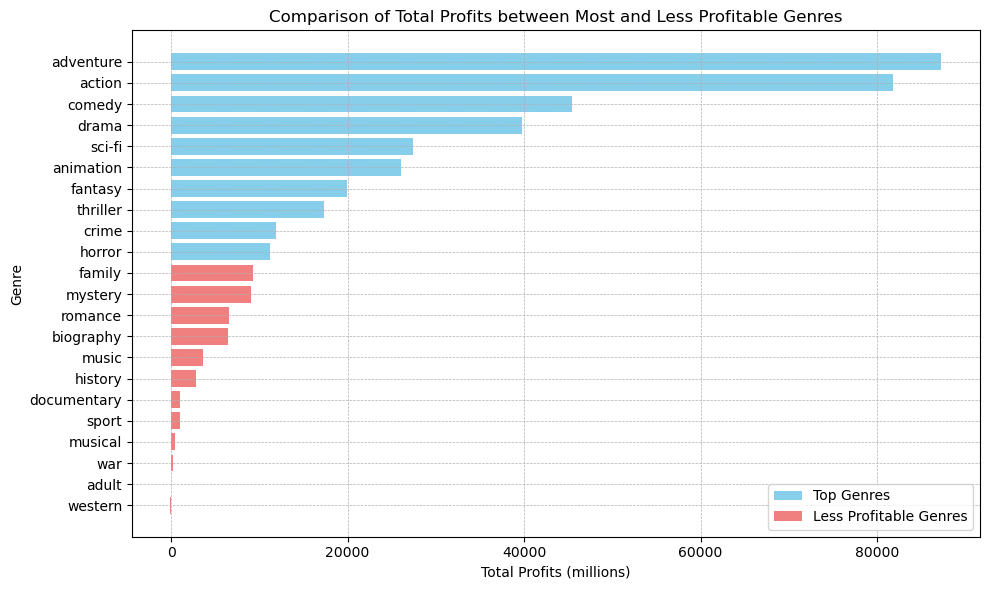

In [ ]:
# Creating variables to compare high profits with lesser profits

top_genres = most_profitable_genres

less_profitable_genres = genre_metrics_df[genre_metrics_df['TotalProfits'] <= 10000]

# Visualization: Compare total profits of top genres vs. less profitable genres
plt.figure(figsize=(10, 6))
plt.barh(top_genres['Genre'], top_genres['TotalProfits'], color='skyblue', label='Top Genres')
plt.barh(less_profitable_genres['Genre'], less_profitable_genres['TotalProfits'], color='lightcoral', label='Less Profitable Genres')
plt.xlabel('Total Profits (millions)')
plt.ylabel('Genre')
plt.title('Comparison of Total Profits between Most and Less Profitable Genres')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to show highest profits at the top
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

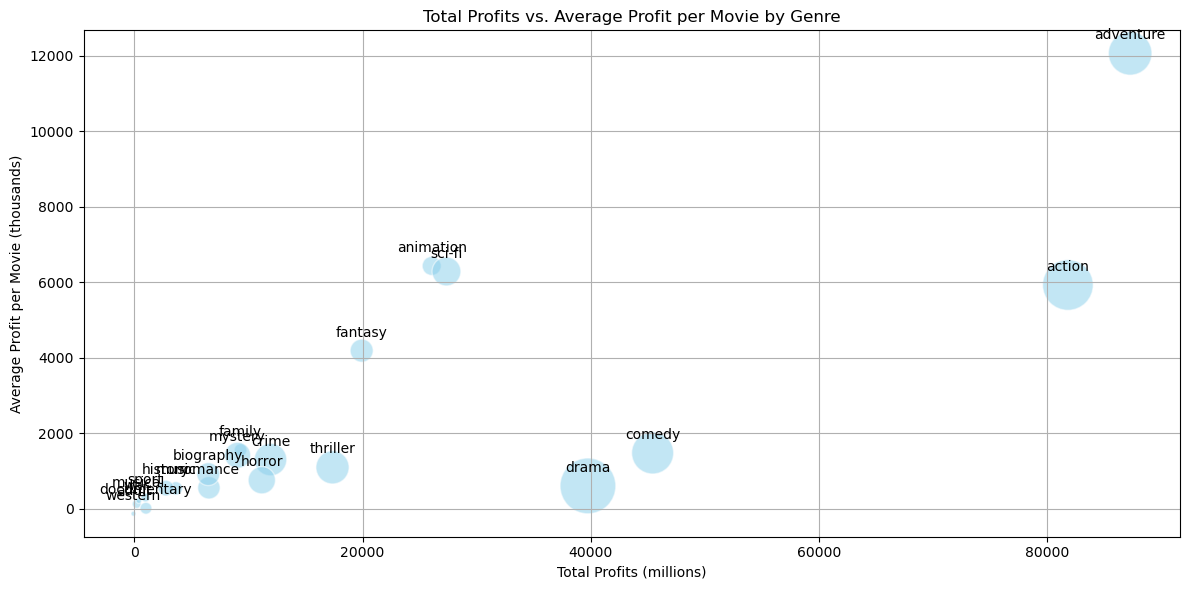

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(genre_metrics_df['TotalProfits'], genre_metrics_df['AverageProfit'], s=genre_metrics_df['TotalVotes']*0.01, c='skyblue', alpha=0.5, edgecolors='w')
plt.xlabel('Total Profits (millions)')
plt.ylabel('Average Profit per Movie (thousands)')
plt.title('Total Profits vs. Average Profit per Movie by Genre')
plt.grid(True)
plt.tight_layout()

# Highlight genres with high average profits
for genre, avg_profit in zip(highest_avg_profit_genres['Genre'], highest_avg_profit_genres['AverageProfit']):
    plt.annotate(genre, (genre_metrics_df.loc[genre_metrics_df['Genre'] == genre, 'TotalProfits'], 
                         genre_metrics_df.loc[genre_metrics_df['Genre'] == genre, 'AverageProfit']),
                    textcoords="offset points", xytext=(0,10), ha='center')
    

## Ratings

In [ ]:
# Looking at the relationship between ratings and profit

high_rating_threshold = 8.0
high_profit_threshold = movies_without_nan_profit['profit'].quantile(0.75)

# Filter movies
highly_rated_profitable_movies = movies_without_nan_profit[(movies_without_nan_profit['averagerating'] >= high_rating_threshold) & (movies_without_nan_profit['profit'] >= high_profit_threshold)]

print(highly_rated_profitable_movies[['primary_title', 'averagerating', 'profit']])

                                                  primary_title  averagerating        profit
991                                                Interstellar           8.70  501379392.00
8419                                           K.G.F: Chapter 2           8.30   77123936.00
10127                                   Spider-Man: No Way Home           8.20 1186428160.00
11881   Demon Slayer: Kimetsu no Yaiba - The Movie: Mugen Train           8.20  437274624.00
17273                                                      Dune           8.00  231142688.00
36332                                        Mad Max: Fury Road           8.10  220098016.00
39499                                                  Deadpool           8.00  743025600.00
47108                                            Dune: Part Two           8.60  521844352.00
47815                                                   Kantara           8.20   58513800.00
48487                                               Oppenheimer       

In [ ]:
# Looking for a correlation between ratings and profit

correlation = movies_without_nan_profit['averagerating'].corr(movies_without_nan_profit['profit'])
print(f"Correlation between average rating and profit: {correlation:.2f}")

Correlation between average rating and profit: 0.18


In [ ]:
# Looking at the relationship between ratings and profit of the top 10 profitable movies

high_rated_movies = top_10_profitable_movies[top_10_profitable_movies['averagerating'] > 7.0].sort_values(by='averagerating', ascending=False)
print(high_rated_movies[['primary_title', 'averagerating', 'profit']])


                                     primary_title  averagerating        profit
125598                           Avengers: Endgame           8.40 2444000000.00
125597                      Avengers: Infinity War           8.40 1748134144.00
56998                            Top Gun: Maverick           8.20 1318732800.00
78843   Star Wars: Episode VII - The Force Awakens           7.80 1823223552.00
53820                     Avatar: The Way of Water           7.50 1860250368.00
91101                                    Furious 7           7.10 1328722816.00


In [ ]:
# looking for the correlation of the top 10 profitable movies

correlation = movies_without_nan_profit['averagerating'].corr(top_10_profitable_movies['profit'])
print(f"Correlation between average rating and profit: {correlation:.2f}")

Correlation between average rating and profit: 0.67


,movie_id,primary_title,profit,averagerating,numvotes
125598,tt4154796,Avengers: Endgame,2444000000.00,8.40,1275156.00
53820,tt1630029,Avatar: The Way of Water,1860250368.00,7.50,499408.00
125597,tt4154756,Avengers: Infinity War,1748134144.00,8.40,1211853.00
932,tt0369610,Jurassic World,1433854976.00,6.90,682448.00
153635,tt6105098,The Lion King,1403000064.00,6.80,268284.00


,movie_id,primary_title,profit,averagerating,numvotes
2928,tt10207588,Floripes,4950.00,9.60,85.00
55307,tt16740148,Hidden Agenda,-25389.00,9.60,10.00
141770,tt5280308,Downup the Exit 796,700000.00,9.60,56.00
139065,tt5119202,Going Furthur,-60000.00,9.50,99.00
40089,tt14391292,Mr. Local Man,-99000.00,9.40,18.00


,movie_id,primary_title,profit,averagerating,numvotes
991,tt0816692,Interstellar,501379392.00,8.70,2118433.00
63615,tt2015381,Guardians of the Galaxy,600867520.00,8.00,1278198.00
125598,tt4154796,Avengers: Endgame,2444000000.00,8.40,1275156.00
125597,tt4154756,Avengers: Infinity War,1748134144.00,8.40,1211853.00
36332,tt1392190,Mad Max: Fury Road,220098016.00,8.10,1106401.00


,start_year,runtime_minutes,averagerating,numvotes,is_adult,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross,profit,profit_proportion,log_profit,scaled_profit
count,2419.00,2387.00,2374.00,2374.00,2419.00,845.00,771.00,2419.00,685.00,2419.00,2419.00,2419.00,1314.00,2419.00
mean,2017.86,110.51,6.25,70107.36,0.00,53931836.01,94768528.00,29473682.00,62014084.00,74802384.00,45328644.00,0.83,16.36,45.33
std,3.03,21.69,1.14,144399.94,0.00,88884512.21,171131584.00,49099060.00,94407768.00,194361472.00,156970432.00,1.91,2.67,156.97
min,2014.00,25.00,1.20,7.00,0.00,0.00,0.00,1000.00,0.00,1000.00,-199545984.00,-1.00,0.69,-199.55
25%,2015.00,96.00,5.70,1984.00,0.00,3511417.00,4158986.00,2406000.00,6670765.00,764705.50,-2956918.00,-0.72,14.98,-2.96
50%,2017.00,107.00,6.40,15222.00,0.00,22395806.00,22628118.00,10000000.00,30718108.00,8465845.00,286136.00,0.18,16.74,0.29
75%,2020.00,122.00,7.00,71630.25,0.00,58700000.00,97911056.00,30000000.00,70259872.00,50382648.00,24163744.00,1.78,18.14,24.16
max,2024.00,319.00,9.60,2118433.00,0.00,700100000.00,1369318656.00,460000000.00,700059584.00,2800000000.00,2444000000.00,7.22,21.62,2444.00


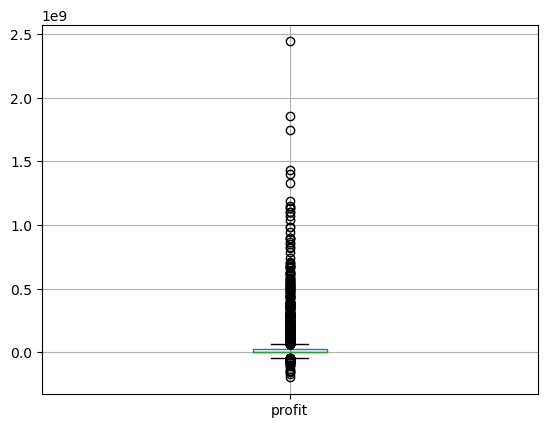

In [180]:

# Inspect the first few rows and summary statistics
display(movies_without_nan_profit[['movie_id','primary_title','profit','averagerating','numvotes']].sort_values(['profit'],ascending=False).head())
display(movies_without_nan_profit[['movie_id','primary_title','profit','averagerating','numvotes']].sort_values(['averagerating'],ascending=False).head())
display(movies_without_nan_profit[['movie_id','primary_title','profit','averagerating','numvotes']].sort_values(['numvotes'],ascending=False).head())
display(movies_without_nan_profit.describe())

# Identify any potential outliers or incorrect values
movies_without_nan_profit.boxplot(column=['profit'])
plt.show()

/tmp/ipykernel_212190/920233817.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['${:,.0f}M'.format(y) for y in y_ticks])


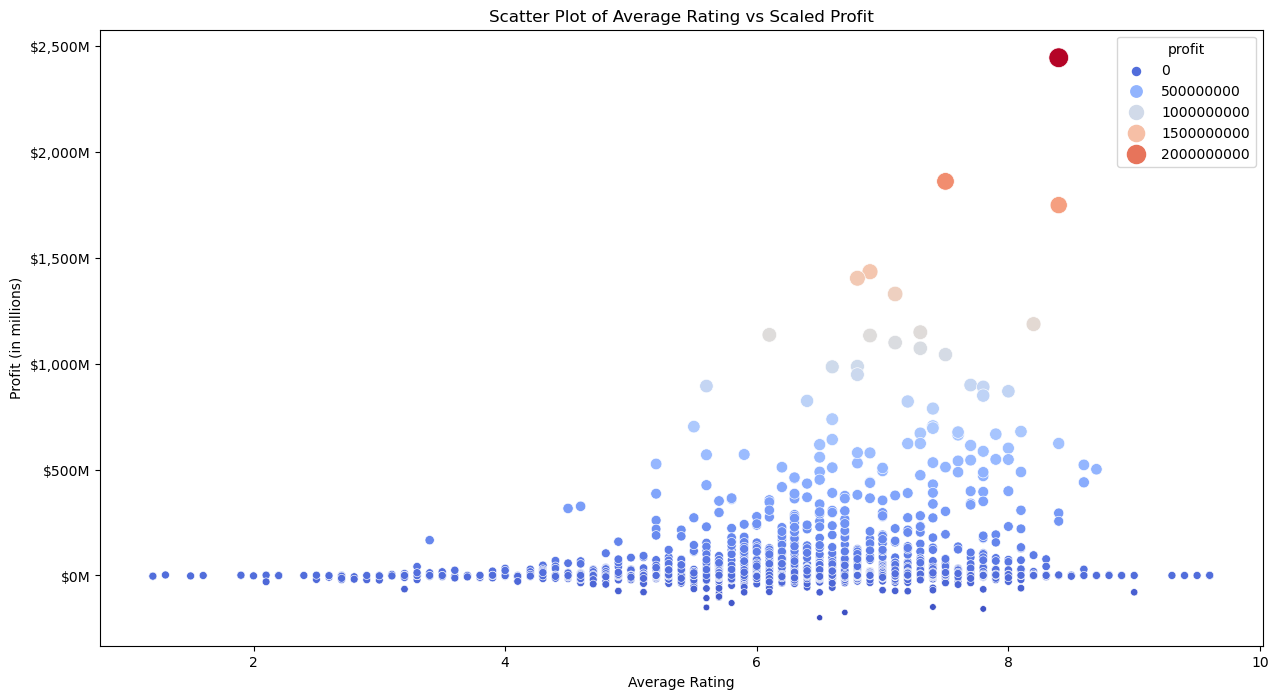

In [171]:
movies_without_nan_profit['scaled_profit'] = movies_without_nan_profit['profit'] / 1e6

plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=movies_without_nan_profit, 
    x='averagerating', 
    y='scaled_profit', 
    hue='profit', 
    palette='coolwarm', 
    size='profit', 
    sizes=(20, 200)
)
plt.title('Scatter Plot of Average Rating vs Scaled Profit')
plt.xlabel('Average Rating')
plt.ylabel('Profit (in millions)')

# Format y-axis with dollar signs
y_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}M'.format(y) for y in y_ticks])

plt.show()

## ROI

In [ ]:
# Seeing what the return on investment looks like for each movie

genre_metrics_df

,Genre,TotalVotes,WeightedAverageRating,TotalProfits,AverageProfit,AverageProportionalProfit
0,adult,3.16,5.44,0.00,0.00,NaN
1,family,8292.18,6.50,9303.84,1560.00,1017.20
2,action,132652.57,6.79,81831.73,5932.84,1641.19
3,drama,160993.25,7.00,39757.26,609.53,1328.35
4,western,1296.87,6.51,-78.74,-127.41,-0.55
5,war,4090.53,7.12,205.47,131.12,0.45
6,adventure,98175.72,6.96,87288.30,12069.73,2.58
7,animation,18620.09,7.23,26060.88,6437.96,2.54
8,music,9400.87,7.15,3632.67,543.73,6.92
9,comedy,91233.48,6.69,45431.21,1481.87,871.69


In [ ]:
directors

,movie_id,primary_name
0,tt0063540,Harnam Singh Rawail
1,tt0066787,Mani Kaul
2,tt0069049,Orson Welles
3,tt0069204,Hrishikesh Mukherjee
4,tt0100275,Raoul Ruiz
...,...,...
163290,tt9916622,Ana Célia de Oliveira
163291,tt9916706,Kanchan Nayak
163292,tt9916730,Kiran Gawade
163293,tt9916754,Vinicius Augusto Bozzo


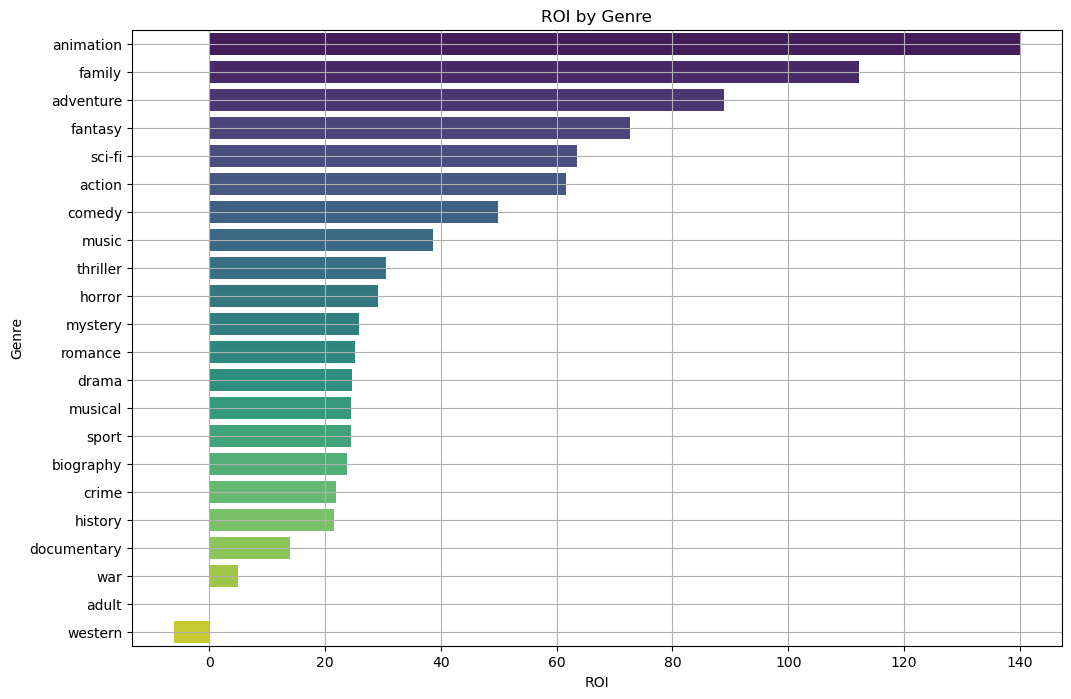

In [ ]:
genre_metrics_df['ROI'] = (genre_metrics_df['TotalProfits'] / genre_metrics_df['TotalVotes']) * 100

genre_metrics_df = genre_metrics_df.sort_values(by='ROI', ascending=False)

# Plotting ROI by Genre
plt.figure(figsize=(12, 8))
sns.barplot(x='ROI', y='Genre', data=genre_metrics_df, palette='viridis')
plt.title('ROI by Genre')
plt.xlabel('ROI')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

/tmp/ipykernel_212190/1183682274.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter.set_yticklabels(['${:,.0f}M'.format(y / 1e6) for y in y_ticks])


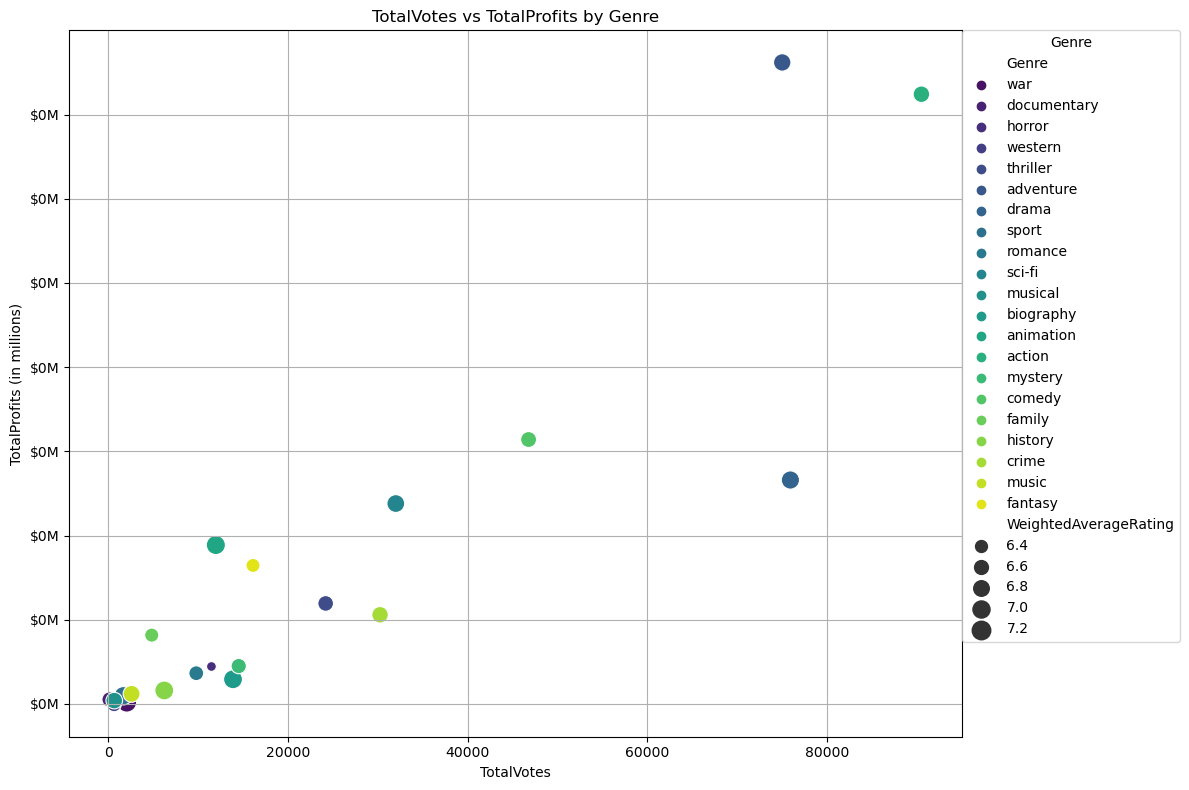

In [172]:
# Assuming genre_metrics_df is already defined and contains the data

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='TotalVotes', 
    y='TotalProfits', 
    hue='Genre', 
    size='WeightedAverageRating', 
    sizes=(50, 200),
    data=genre_metrics_df, 
    palette='viridis', 
    legend='brief'
)

# Formatting y-axis to display dollar signs and scale to millions
y_ticks = scatter.get_yticks()
scatter.set_yticklabels(['${:,.0f}M'.format(y / 1e6) for y in y_ticks])

plt.title('TotalVotes vs TotalProfits by Genre')
plt.xlabel('TotalVotes')
plt.ylabel('TotalProfits (in millions)')

# Adjust legend
plt.legend(title='Genre', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Close the im.db connection
It's always good practice to ensure you closed the connection

In [ ]:

# Close the connection
conn.close()